## Import libraries

In [1]:
from stockfish import Stockfish
from stockfish import StockfishException
import pandas as pd
import numpy as np
import re
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
from timeit import default_timer as timer
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import chess.svg
from IPython.display import SVG, display, HTML, Image

## Import dataset

In [2]:
with open('valid_positions.txt') as f:
    pos = f.readlines()
pos1 = []
for i in range(len(pos)):
    pos1.append(re.sub('\n','', pos[i]))    
dataset = pos1

We are using a reduced version of the original dataset, with some invalid positions excluded

## Additional fucntions

In [3]:
STOCKFISH15_LOCATION = '/home/mathieuacher/Downloads/stockfish_15_linux_x64_avx2/stockfish_15_x64_avx2'

#evaluation function
def evaluation(pos, elo, depth):
    stockfish = Stockfish(STOCKFISH15_LOCATION)
    stockfish.set_elo_rating(elo)        
    stockfish.set_depth(depth)
    stockfish.set_fen_position(pos)
    ev = stockfish.get_evaluation()
    pos = stockfish.get_top_moves(1)
    return ev, pos

def evaluationdouble(pos1, pos2, elo, depth):
    stockfish = Stockfish(STOCKFISH15_LOCATION)
    stockfish.set_elo_rating(elo)
    stockfish.set_depth(depth)
    stockfish.set_fen_position(pos1)
    ev1 = stockfish.get_evaluation()
    stockfish.set_fen_position(pos2)
    ev2 = stockfish.get_evaluation()
    return ev1, ev2

def show_pos(fen_list, size, space=10):
    boards = [chess.Board(fen) for fen in fen_list]
    svg_boards = [chess.svg.board(board=board, size=size) for board in boards]
    html_code = "<div style='display: inline-block; margin-right: {}px;'>{}</div>".format(space, "</div><div style='display: inline-block; margin-right: {}px;'>".format(space).join(svg_boards))
    display(HTML(html_code))


In [4]:
#delta
def dif1(val1, val2):
    if abs(val1) + abs(val2) == 0:
        return 0
    else:
        return abs(val1 - val2) / (abs(val1) + abs(val2))

#epsilon
def dif2(val1, val2):
    return float(abs(val1 - val2))

In [5]:
def checkcheckW(pos):
    def make_matrix(board):  # type(board) == chess.Board()
        pgn = board
        foo = []  # Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        for row in rows:
            foo2 = []  # This is the row I make
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        foo2.append('.')
                else:
                    foo2.append(thing)
            foo.append(foo2)
        return foo

    whites = ['Q', 'K', 'R', 'B', 'N', 'P']
    blacks = ['q', 'k', 'r', 'b', 'n', 'p']
    a = make_matrix(pos)
    check = False
    pos = []
    for i in range(8):
        for j in range(8):
            if a[i][j] == 'K':
                pos.append(i)
                pos.append(j)
    for i in list(reversed(range(pos[1]))):
        if a[pos[0]][i] in whites or a[pos[0]][i] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'q' or a[pos[0]][i] == 'r':
            check = True
            break
    for i in list(range(pos[1] + 1, 8)):
        if a[pos[0]][i] in whites or a[pos[0]][i] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'q' or a[pos[0]][i] == 'r':
            check = True
            break
    for i in list(reversed(range(pos[0]))):
        if a[i][pos[1]] in whites or a[i][pos[1]] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'q' or a[i][pos[1]] == 'r':
            check = True
            break
    for i in list(range(pos[0] + 1, 8)):
        if a[i][pos[1]] in whites or a[i][pos[1]] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'q' or a[i][pos[1]] == 'r':
            check = True
            break
    r = 8 - np.maximum(abs(pos[0]), abs(pos[1]))
    r1 = np.minimum(abs(pos[0]), abs(pos[1]))
    r2 = np.minimum(r, r1)
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] + i] in whites or a[pos[0] + i][pos[1] + i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] + i] == 'b' or a[pos[0] + i][pos[1] + i] == 'q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] + i] in whites or a[pos[0] - i][pos[1] + i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] + i] == 'b' or a[pos[0] - i][pos[1] + i] == 'q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] - i] in whites or a[pos[0] - i][pos[1] - i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] - i] == 'b' or a[pos[0] - i][pos[1] - i] == 'q':
            check = True
            break
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] - i] in whites or a[pos[0] + i][pos[1] - i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] - i] == 'b' or a[pos[0] + i][pos[1] - i] == 'q':
            check = True
            break
    if pos[0] + 2 < 8 and pos[1] - 1 > 0 and a[pos[0] + 2][pos[1] - 1] == 'n':
        check = True
    if pos[0] + 2 < 8 and pos[1] + 1 < 8 and a[pos[0] + 2][pos[1] + 1] == 'n':
        check = True
    if pos[0] - 2 > 0 and pos[1] - 1 > 0 and a[pos[0] - 2][pos[1] - 1] == 'n':
        check = True
    if pos[0] - 2 > 0 and pos[1] + 1 < 8 and a[pos[0] - 2][pos[1] + 1] == 'n':
        check = True
    if pos[0] + 1 < 8 and pos[1] - 2 > 0 and a[pos[0] + 1][pos[1] - 2] == 'n':
        check = True
    if pos[0] + 1 < 8 and pos[1] + 2 < 8 and a[pos[0] + 1][pos[1] + 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 2 > 0 and a[pos[0] - 1][pos[1] - 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 2 < 8 and a[pos[0] - 1][pos[1] + 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 1 > 0 and a[pos[0] - 1][pos[1] - 1] == 'p':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 1 < 8 and a[pos[0] - 1][pos[1] + 1] == 'p':
        check = True
    return check


def checkcheckB(pos):
    def make_matrix(board):  # type(board) == chess.Board()
        pgn = board
        foo = []  # Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        for row in rows:
            foo2 = []  # This is the row I make
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        foo2.append('.')
                else:
                    foo2.append(thing)
            foo.append(foo2)
        return foo

    whites = ['Q', 'K', 'R', 'B', 'N', 'P']
    blacks = ['q', 'k', 'r', 'b', 'n', 'p']
    a = make_matrix(pos)
    check = False
    pos = []
    for i in range(8):
        for j in range(8):
            if a[i][j] == 'k':
                pos.append(i)
                pos.append(j)
    for i in list(reversed(range(pos[1]))):
        if a[pos[0]][i] in blacks or a[pos[0]][i] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'Q' or a[pos[0]][i] == 'R':
            check = True
            break
    for i in list(range(pos[1] + 1, 8)):
        if a[pos[0]][i] in blacks or a[pos[0]][i] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'Q' or a[pos[0]][i] == 'R':
            check = True
            break
    for i in list(reversed(range(pos[0]))):
        if a[i][pos[1]] in blacks or a[i][pos[1]] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'Q' or a[i][pos[1]] == 'R':
            check = True
            break
    for i in list(range(pos[0] + 1, 8)):
        if a[i][pos[1]] in blacks or a[i][pos[1]] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'Q' or a[i][pos[1]] == 'R':
            check = True
            break
    r = 8 - np.maximum(abs(pos[0]), abs(pos[1]))
    r1 = np.minimum(abs(pos[0]), abs(pos[1]))
    r2 = np.minimum(r, r1)
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] + i] in blacks or a[pos[0] + i][pos[1] + i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] + i] == 'B' or a[pos[0] + i][pos[1] + i] == 'Q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] + i] in blacks or a[pos[0] - i][pos[1] + i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] + i] == 'B' or a[pos[0] - i][pos[1] + i] == 'Q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] - i] in blacks or a[pos[0] - i][pos[1] - i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] - i] == 'B' or a[pos[0] - i][pos[1] - i] == 'Q':
            check = True
            break
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] - i] in blacks or a[pos[0] + i][pos[1] - i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] - i] == 'B' or a[pos[0] + i][pos[1] - i] == 'Q':
            check = True
            break
    if pos[0] + 2 < 8 and pos[1] - 1 > 0 and a[pos[0] + 2][pos[1] - 1] == 'N':
        check = True
    if pos[0] + 2 < 8 and pos[1] + 1 < 8 and a[pos[0] + 2][pos[1] + 1] == 'N':
        check = True
    if pos[0] - 2 > 0 and pos[1] - 1 > 0 and a[pos[0] - 2][pos[1] - 1] == 'N':
        check = True
    if pos[0] - 2 > 0 and pos[1] + 1 < 8 and a[pos[0] - 2][pos[1] + 1] == 'N':
        check = True
    if pos[0] + 1 < 8 and pos[1] - 2 > 0 and a[pos[0] + 1][pos[1] - 2] == 'N':
        check = True
    if pos[0] + 1 < 8 and pos[1] + 2 < 8 and a[pos[0] + 1][pos[1] + 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 2 > 0 and a[pos[0] - 1][pos[1] - 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 2 < 8 and a[pos[0] - 1][pos[1] + 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 1 > 0 and a[pos[0] - 1][pos[1] - 1] == 'P':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 1 < 8 and a[pos[0] - 1][pos[1] + 1] == 'P':
        check = True
    return check


def bothcheck(pos):
    both = False
    if checkcheckB(pos) == True and checkcheckW(pos) == True:
        both = True
    return both

## Functions to alterate positions

In [6]:
def sim_axis(pos):
    pos_transformed = []
    col = pos[-1:]
    aux1 = pos[:-2]
    aux2 = aux1.split("/")
    aux3 = []
    for j in range(8):
        aux3.append(aux2[j][::-1])
    aux4 = '/'.join(aux3)
    pos_transformed.append(aux4)
    if col == 'w':
        pos_transformed = pos_transformed[0] + ' w'
    if col == 'b':
        pos_transformed = pos_transformed[0] + ' b'
    return pos_transformed


def sim_diag(pos):
    def Convert(string):
        list1 = []
        list1[:0] = string
        return list1

    pos_transformed = []
    colour = pos[-1:]
    aux = pos.replace('8', '11111111').replace('7', '1111111').replace('6', '111111').replace('5', '11111').replace('4',
                                                                                                                    '1111').replace(
        '3', '111').replace('2', '11')
    aux2 = aux.split('/')
    for i in range(8):
        aux2[i] = Convert(aux2[i])
        aux3 = [] * 8

    for j in reversed(range(8)):
        aux4 = []
        for i in reversed(range(8)):
            aux4.append(aux2[i][j])
        aux3.append(aux4)
    for i in reversed(range(8)):
        aux3[i] = "".join(aux3[i])
    pos_transformed = "/".join(aux3)
    if colour == 'b':
        pos_transformed = pos_transformed + ' b'
    else:
        pos_transformed = pos_transformed + ' w'
    pos_transformed = pos_transformed.replace('11111111', '8').replace('1111111', '7').replace('111111', '6').replace(
        '11111', '5').replace('1111', '4').replace('111', '3').replace('11', '2')

    return pos_transformed


def sim_mirror(pos):
    pos_transformed = []
    colour = pos[-1:]
    aux1 = pos[:-2]
    aux2 = aux1.swapcase()
    aux3 = aux2.split("/")
    aux4 = []
    for j in reversed(aux3):
        aux4.append(j)
        aux5 = '/'.join(aux4)
    pos_transformed.append(aux5)
    if colour == 'b':
        pos_transformed = pos_transformed[0] + ' w'
    else:
        pos_transformed = pos_transformed[0] + ' b'
    return pos_transformed


def replace(pos):
    if pos.count('B') > 0 & pos.count('R') > 0:
        n = random.random()
        if n > 0.5:
            aux = pos.replace('R', 'Q', 1)
        else:
            aux = pos.replace('B', 'Q', 1)
    elif pos.count('B') > 0 & pos.count('R') == 0:
        aux = pos.replace('B', 'Q', 1)
    elif pos.count('R') > 0 & pos.count('B') == 0:
        aux = pos.replace('R', 'Q', 1)
    else:
        aux = pos
    return aux

## MRs

In [7]:
#for sim_axis and sim_diag
def MR_equi(o1, o2, delta, epsilon):
    final = False
    if o1.get('type') != o2.get('type'):
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') != o2.get('value'):
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and dif1(o1.get('value'), o2.get('value')) > delta and dif2(
            o1.get('value'), o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

#for sim_mirror
def MR_mirror(o1, o2, delta, epsilon):
    final = False
    if o1.get('type') != o2.get('type'):
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') != (-1 * o2.get('value')):
    #elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') * (-1 * o2.get('value'))<0:
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and dif1(o1.get('value'), (-1 * o2.get('value'))) > delta and dif2(
            o1.get('value'), (-1 * o2.get('value'))) >= epsilon:
        final = False
    else:
        final = True
    return final

#for replace
def MR_better_original(o1,o2,delta,epsilon):
    final = bool()
    if o1.get('type') != o2.get('type') and o2.get('type') != 'mate':
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') < o2.get('value') and o1.get('value') > 0:
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') > o2.get('value') and o1.get('value') < 0:
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and o1.get('value') > o2.get('value') and dif1(o1.get('value'),o2.get('value')) > delta and dif2(o1.get('value'),o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

#when using the evaluation after the best move
def MR_first(o1, o2, delta, epsilon):
    final = False
    if o1[0].get('Mate') != o2[0].get('Mate'):
        final = False
    elif o1[0].get('Mate') == o2[0].get('Mate') == None and dif1(o1[0].get('Centipawn'),
                                                                 o2[0].get('Centipawn')) > delta and dif2(
            o1[0].get('Centipawn'), o2[0].get('Centipawn')) >= epsilon:
        final = False
    else:
        final = True
    return final

### Problem with the original MR_better : example

In [8]:
pos = '1B1n1r2/8/8/1n5b/3r4/8/5k2/2K5'
pos2 = replace(pos)
ev1 = evaluation(pos,5000,10)[0]
ev2 = evaluation (pos2, 5000, 10)[0]

print(ev1, '\n', ev2)

{'type': 'mate', 'value': -10} 
 {'type': 'cp', 'value': -824}


Before replace --> mate in 10 for Black
After replace --> advantage of 824 centipawns for Black

The evaluation got better for White, which should meet the MR requirements but:

In [9]:
print(MR_better_original(ev1,ev2,1,100))

False


It seems that some conditions are incorrect in the original MR_better function, so we modified it as follows:

In [10]:
def MR_better(o1, o2, delta, epsilon):
    final = False
    # knowing that we're upgrading white pieces (always)
    # if we switch from diff in centipawns to mate for Black --> False
    if o1.get('type') == 'cp' and o2.get('type') == 'mate' and o2.get('value') < 0:
        final = False
    # if we switch from mate to diff in centipawns for White --> False
    elif o1.get('type') == 'mate' and o2.get('type') == 'cp' and o1.get('value') > 0:
        final = False
    # ex : from #7 to #9 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and o2.get('value') > o1.get('value') > 0:
        final = False
    # ex : from #-9 to #-7 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and 0 > o2.get('value') > o1.get('value'):
        final = False
    # ex : from #5 to #-5 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') > 0 > o2.get('value'):
        final = False
    # if centipawns diff for both evaluations, will depend on thresholds
    elif o1.get('type') == o2.get('type') == 'cp' and o1.get('value') > o2.get('value') and dif1(o1.get('value'),
                                                                                                 o2.get('value')) > delta and dif2(
            o1.get('value'), o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

## Main functions

### Function for mass evaluations

In [11]:

def main(dataset, elo, depth, type):
    global threadsfinis
    global threadstotaux
    pos1 = []
    pos2 = []
    results1 = []
    results2 = []
    start = timer()
    index = []
    if type == 0:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_mirror(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_mirror(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_mirror(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 1:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_axis(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_axis(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_axis(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 2:
        for i in range(len(dataset)):
            #ignoring positions with pawns
            if bothcheck(dataset[i]) == False and bothcheck(sim_diag(dataset[i])) == False and 'p' not in dataset[
                i] and 'P' not in dataset[i]:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_diag(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_diag(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 3:
        for i in range(len(dataset)):
            #ignoring positions without white rooks or bishops
            if bothcheck(dataset[i]) == False and bothcheck(replace(dataset[i])) == False and (
                    'B' in dataset[i] or 'R' in dataset[i]):
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(replace(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(replace(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass

    elif type == 4:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_axis(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[1]
                    ev2 = evaluation(sim_axis(dataset[i]), elo, depth)[1]
                    # ajout d'un len à la fin parce que souci si on essaie de faire jouer un coup sur une position où ça n'est pas possible (mat, pat)
                    if len(ev1) != 0 and len(ev2) != 0:
                        # MR.append(MR_first(evaluation(dataset[i],elo,depth)[1],evaluation(sim_axis(dataset[i]), elo, depth)[1], delta, epsilon)) ## adding MR to dataframe
                        pos1.append(dataset[i])  ## adding original position to dataframe
                        pos2.append(sim_axis(dataset[i]))  ## adding transformed position to dataframe
                        results1.append(ev1)  ## adding evaluation of original position to dataframe
                        results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                        index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass

    d = {'index': index, 'pos1': pos1, 'evaluation pos1': results1, 'pos2': pos2, 'evaluation pos2': results2}
    df = pd.DataFrame(data=d)  ## creating dataframe

    # print(timer()-start)
    return df

### Function for mass MR checks

In [12]:
def MR(df, type, delta, epsilon):
    ev1s = df["evaluation pos1"]
    ev2s = df["evaluation pos2"]
    MRs = []
    if type == 0:
        for k in range(len(ev1s)):
            MRs.append(MR_mirror(ev1s[k], ev2s[k], delta, epsilon))
    if type == 1 or type == 2:
        for k in range(len(ev1s)):
            MRs.append(MR_equi(ev1s[k], ev2s[k], delta, epsilon))
    if type == 3:
        for k in range(len(ev1s)):
            MRs.append(MR_better(ev1s[k], ev2s[k], delta, epsilon))
    if type == 6:
        for k in range(len(ev1s)):
            MRs.append(MR_better_original(ev1s[k], ev2s[k], delta, epsilon))
    if type == 4:
        for k in range(len(ev1s)):
            MRs.append(MR_first(ev1s[k], ev2s[k], delta, epsilon))
    falses = trues = 0
    for k in range(len(MRs)):
        if MRs[k]:
            trues += 1
        else:
            falses += 1
    #print("MR valides : ", trues, "; MR invalides : ", falses, "; Ratio : ", trues / (trues + falses) * 100, "%")
    return trues / (trues + falses) * 100

### Function for grids

In [13]:
deltas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
epsilons = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 100]

def tests(evas, typent, d, add='',size1 = 100):
    if typent==5:
        type = 1
    else:
        type = typent
    results_grid = []

    for delta in deltas:
        delta_results = []

        for epsilon in epsilons:
            result = 100 - MR(evas, type, delta, epsilon)

            delta_results.append(result)

        results_grid.append(delta_results)

    df_results = pd.DataFrame(results_grid, index=deltas, columns=epsilons)

    plt.figure(figsize=(10*size1//100, 6*size1//100))
    sns.heatmap(df_results, cmap='RdYlGn_r', annot=True, fmt=".2f", cbar_kws={'label': 'Valeurs'},annot_kws={"size": 10*size1//100})
    typent = ["sim_mirror", "sim_axis", "sim_diag", "replace", "best_move","SF15 vs SF16","replace_mr_og"][typent]

    label = 'MR violation rate, ' + typent + ', depth=' + str(d) + add

    plt.title(label)
    plt.xlabel('Epsilons')
    plt.ylabel('Deltas')
    plt.plot()
    return df_results


## Application of main functions

An example with the first 40 positions of our dataset. 

0
5
10
15
20
25
30
35


0     5     10    15    20    25    30    40    50    60    75   100
0.05  25.0  22.5  22.5  17.5  17.5  15.0  15.0  15.0  12.5  10.0  10.0  5.0
0.10  22.5  20.0  20.0  15.0  15.0  12.5  12.5  12.5  10.0   7.5   7.5  5.0
0.15  15.0  12.5  12.5   7.5   7.5   5.0   5.0   5.0   5.0   2.5   2.5  2.5
0.20  10.0   7.5   7.5   5.0   5.0   2.5   2.5   2.5   2.5   2.5   2.5  2.5
0.25  10.0   7.5   7.5   5.0   5.0   2.5   2.5   2.5   2.5   2.5   2.5  2.5
0.30  10.0   7.5   7.5   5.0   5.0   2.5   2.5   2.5   2.5   2.5   2.5  2.5
0.40  10.0   7.5   7.5   5.0   5.0   2.5   2.5   2.5   2.5   2.5   2.5  2.5
0.50   5.0   2.5   2.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0

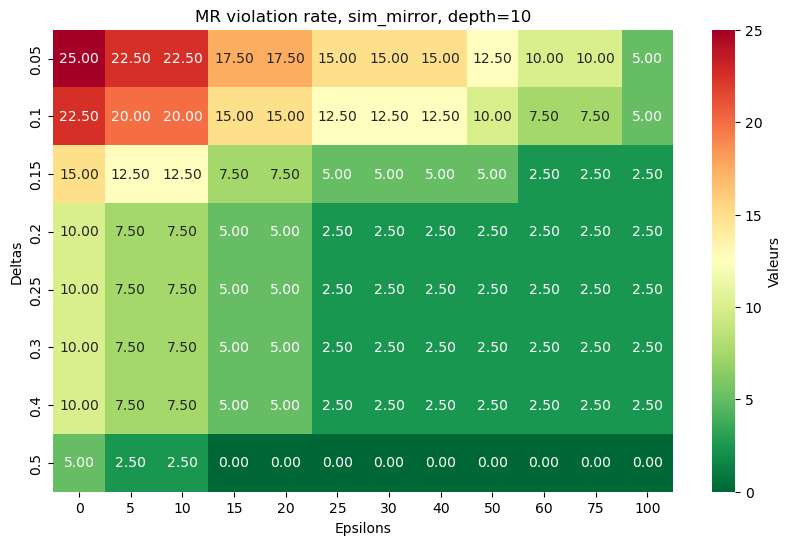

In [14]:
evas = main(dataset[0:40], 4000, 10,0) 
#last parameter --> type; 
#0 : mirror, 
#1 : sim_axis, 
#2 : sim_diag, 
#3 : better, 
#4 : first
tests(evas,0,10)

## Observations
### sim_mirror
Evaluations are stored in pickle files.
#### depth = 10, entire dataset <a id='mirror15entire10'>[(Link V16)](#mirror16entire10)</a>

Showing at first the grid we got ourselves.

0          5          10         15         20         25   \
0.05  36.145707  33.529848  30.933510  29.352282  28.259087  27.478234   
0.10  24.924843  23.339710  21.582790  20.438840  19.607231  19.048920   
0.15  20.411510  19.169953  17.873736  17.006989  16.394019  15.952836   
0.20  17.975247  16.964042  15.913794  15.230547  14.750322  14.375512   
0.25  16.511147  15.578027  14.680045  14.106118  13.676649  13.364307   
0.30  15.523367  14.637098  13.883575  13.403350  13.044157  12.774763   
0.40  14.246672  13.481435  12.884082  12.501464  12.228165  12.036856   
0.50  13.270605  12.571741  12.064186  11.751845  11.537110  11.380939   

            30         40         50         60         75         100  
0.05  26.767657  25.592473  24.604693  23.722329  22.570570  20.907352  
0.10  18.545270  17.729278  17.116308  16.643892  16.077773  15.421856  
0.15  15.597548  14.976770  14.531683  14.219342  13.778160  13.344786  
0.20  14.106118  13.618085  13.270605  13.036349  12.704486  12.364815  
0.25  13.137860  12.708390  12.454613  12.263304  11.993909  11.724515  
0.30  12.575645  12.196931  11.990005  11.814313  11.583961  11.369227  
0.40  11.892398  11.587866  11.423886  11.271620  11.076407  10.916332  
0.50  11.256003  11.017843  10.881193  10.760161  10.611799  10.479054

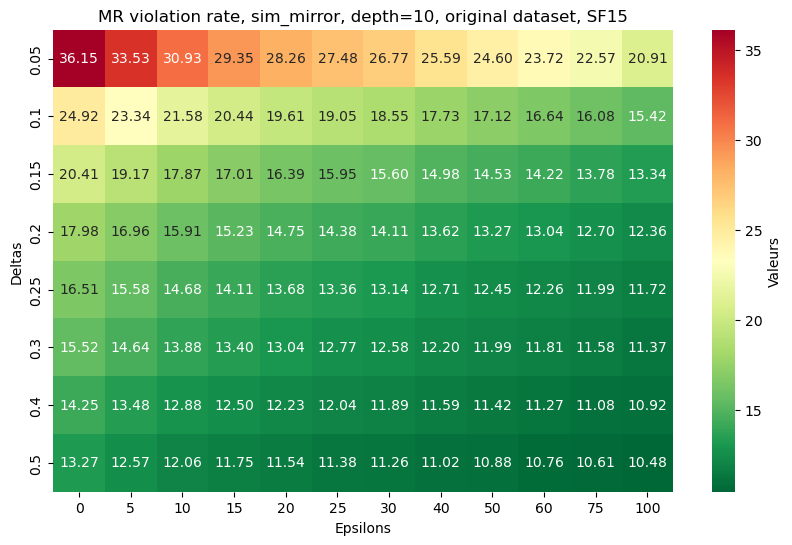

In [15]:
path = os.path.join('sim_mirror_d=10','evaluations50000_sim_mirror_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_10 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')

Here is the grid from the article.

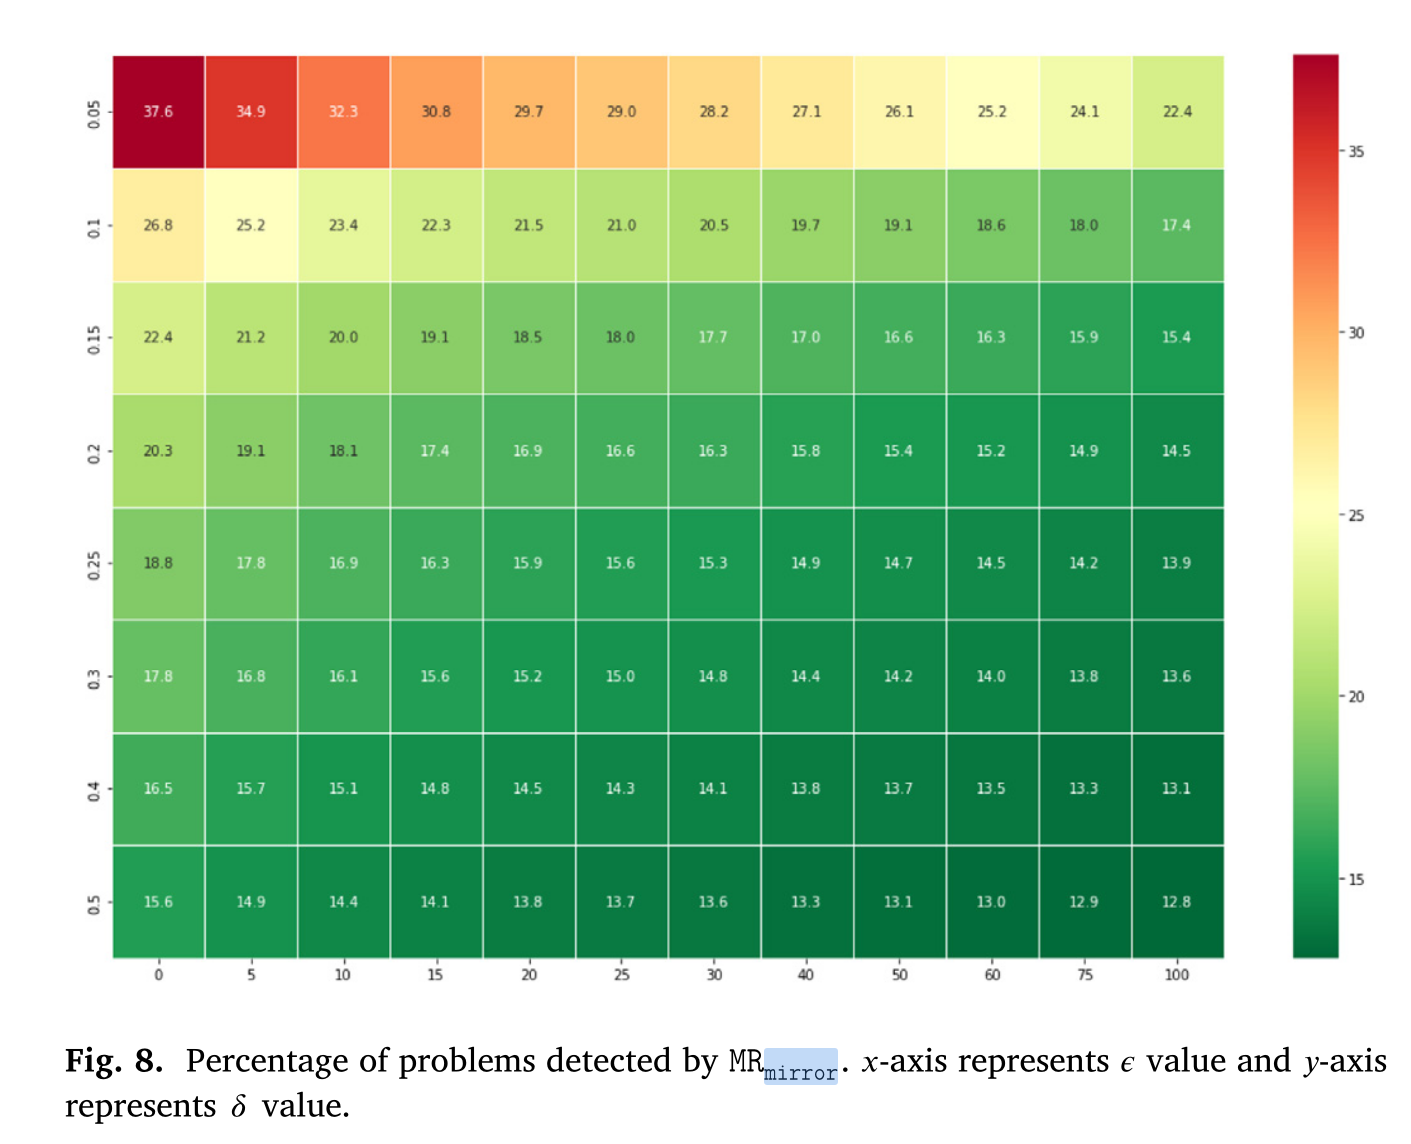

In [16]:
from IPython.display import display, Image

display(Image(filename='originalmirror10_am.png',width=900,height=900))

The results are really similar, the minor differences we observe could be to system differences. Same comment for the other mutations, replace() aside.

#### depth = 15, entire dataset

0          5          10         15         20         25   \
0.05  37.262788  34.568528  32.003124  30.667708  29.761812  29.098009   
0.10  28.594299  26.973838  25.216712  24.252245  23.643108  23.240922   
0.15  24.927763  23.713393  22.471691  21.733698  21.253417  20.937134   
0.20  23.073018  22.053885  21.140180  20.577899  20.183522  19.918001   
0.25  21.991410  21.101132  20.367044  19.890668  19.539242  19.336197   
0.30  21.233893  20.382663  19.757907  19.367435  19.058961  18.887153   
0.40  20.089809  19.367435  18.902772  18.609918  18.367825  18.246779   
0.50  19.230769  18.594299  18.211636  17.969543  17.758688  17.653260   

            30         40         50         60         75         100  
0.05  28.559157  27.750879  27.235455  26.720031  26.200703  25.454900  
0.10  22.881687  22.331121  22.038266  21.792269  21.550176  21.315892  
0.15  20.644280  20.245998  20.050761  19.867239  19.714955  19.590004  
0.20  19.691527  19.375244  19.222960  19.086294  18.992581  18.914487  
0.25  19.137056  18.867630  18.742679  18.625537  18.563061  18.500586  
0.30  18.727060  18.504490  18.410777  18.332683  18.278016  18.227255  
0.40  18.133542  17.953924  17.899258  17.844592  17.797735  17.770402  
0.50  17.571261  17.418977  17.376025  17.329168  17.294026  17.274502

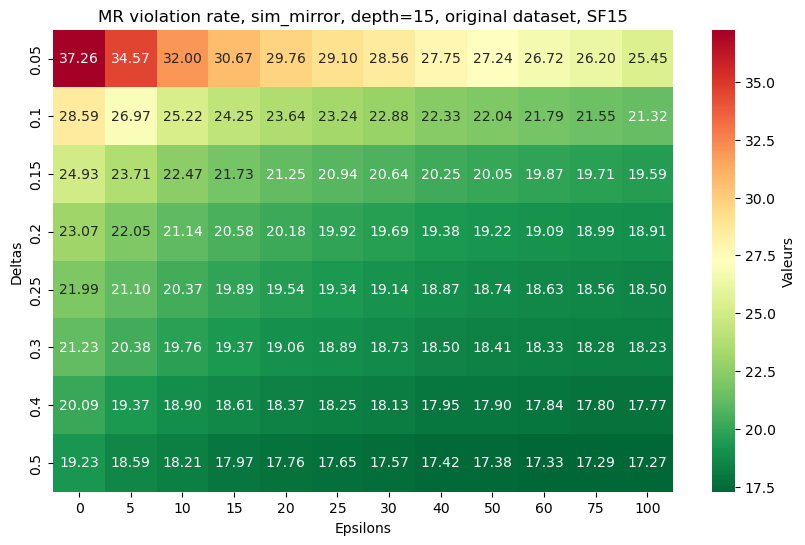

In [17]:
path = os.path.join('sim_mirror_d=15','evaluations50000_sim_mirror_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_15 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_15,0,15, ', original dataset, SF15')

#### depth = 20, entire dataset <a id='mirror15entire'>[(Link V16)](#mirror16entire)</a>

0          5          10         15         20         25   \
0.05  36.314204  34.041388  31.592536  30.184251  29.370575  28.756406   
0.10  29.476196  28.157884  26.534444  25.423464  24.813207  24.433752   
0.15  26.323202  25.435199  24.289011  23.404921  22.923757  22.638188   
0.20  24.523726  23.756993  22.955052  22.286117  21.902750  21.675860   
0.25  23.577045  22.896374  22.250910  21.730626  21.413762  21.214255   
0.30  22.861167  22.207879  21.668036  21.237726  20.979541  20.815241   
0.40  21.785393  21.257286  20.807417  20.490553  20.298869  20.158041   
0.50  20.995188  20.510112  20.111098  19.825529  19.672965  19.555608   

            30         40         50         60         75         100  
0.05  28.361303  27.856668  27.547627  27.309001  27.023432  26.530532  
0.10  24.195126  23.913469  23.749169  23.623988  23.534014  23.401009  
0.15  22.477800  22.270469  22.168760  22.094433  22.047491  21.984900  
0.20  21.562414  21.405938  21.331612  21.288581  21.257286  21.206431  
0.25  21.108634  20.971717  20.901303  20.866096  20.838712  20.799593  
0.30  20.721355  20.596174  20.537496  20.506200  20.482729  20.451434  
0.40  20.087627  19.970270  19.919415  19.903767  19.895943  19.876384  
0.50  19.504753  19.391308  19.352189  19.344365  19.336541  19.324805

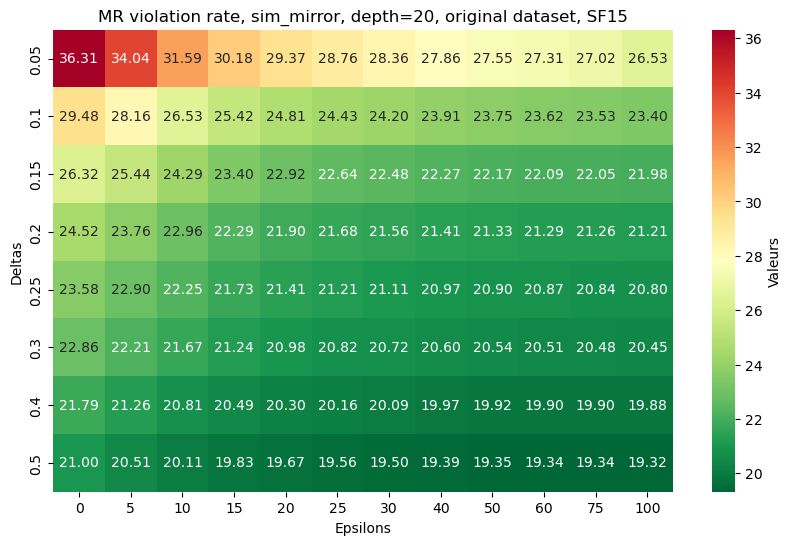

In [18]:
path = os.path.join('sim_mirror_d=20','evaluations50000_sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_20 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_20,0,20, ', original dataset, SF15')

We can observe that despite increasing the depth, the results are not getting better, we could even say that it is worsening. We also observed that with each position mutations. We decided to check positions that had important deviations on depth 10 (that we found by setting important thresholds) when evaluating their equivalent counterpart.
After checking many positions, we found that big differences are often observed when the advante for one side is big, in centipawns or when it is not far from a mate.
Examples :

In [19]:
pos1 = '1B4R1/7B/8/2K3n1/8/7k/R1r5/1B6 w'
pos2 = '1N5k/3Kb2q/1NP3p1/1R4B1/3R4/1B6/8/n3Q3 w'
show_pos([pos1,pos2],300)

print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,10))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,10))

pos1 :  ({'type': 'mate', 'value': 9}, {'type': 'cp', 'value': -2101})
pos2 :  ({'type': 'cp', 'value': 7305}, {'type': 'cp', 'value': 2850})


It seems that Stockfish starts to return high values when the positions are not far from a mate. If we increase the depth, the second evaluation also indicate a mate:

In [20]:
print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,15))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,15))

pos1 :  ({'type': 'mate', 'value': 6}, {'type': 'mate', 'value': -5})
pos2 :  ({'type': 'mate', 'value': 8}, {'type': 'mate', 'value': 7})


Reaching a certain depth, Stockfish returns the same values for both original and mutated positions.

In [21]:
print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,20))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,20))

pos1 :  ({'type': 'mate', 'value': 5}, {'type': 'mate', 'value': -5})
pos2 :  ({'type': 'mate', 'value': 7}, {'type': 'mate', 'value': 7})


We have to notice that MRs will always detect a problem if the evaluations' types are different OR if they are a mate for both positions but their values are not exactly the same. It is therefore strange to observe that increasing the depth does not improve the rate of respected MRs, but it could explain why that much problem are detected. We then checked the biggest deviations with depth 15.

In [22]:
pos3 = '2N5/3k4/8/3B4/1K6/5n1r/8/4r3 b'
show_pos([pos3],300)
ev10 = evaluationdouble(pos3,sim_diag(pos3),50000,10)
print("pos3, d=10 : ", ev10, " - ", MR_equi(ev10[0],ev10[1],0.25,20))
ev15 = evaluationdouble(pos3,sim_diag(pos3),50000,15)
print("pos3, d=15 : ", ev15, " - ", MR_equi(ev15[0],ev15[1],0.25,20))
ev20 = evaluationdouble(pos3,sim_diag(pos3),50000,20)
print("pos3, d=20 : ", ev20, " - ", MR_equi(ev20[0],ev20[1],0.25,20))
ev25 = evaluationdouble(pos3,sim_diag(pos3),50000,25)
print("pos3, d=25 : ", ev25, " - ", MR_equi(ev25[0],ev25[1],0.25,20))
ev30 = evaluationdouble(pos3,sim_diag(pos3),50000,30)
print("pos3, d=30 : ", ev30, " - ", MR_equi(ev30[0],ev30[1],0.25,20))

pos3, d=10 :  ({'type': 'cp', 'value': -1088}, {'type': 'cp', 'value': -1114})  -  True
pos3, d=15 :  ({'type': 'cp', 'value': -5972}, {'type': 'cp', 'value': -1543})  -  False
pos3, d=20 :  ({'type': 'mate', 'value': -11}, {'type': 'mate', 'value': -18})  -  False
pos3, d=25 :  ({'type': 'mate', 'value': -9}, {'type': 'mate', 'value': -12})  -  False
pos3, d=30 :  ({'type': 'mate', 'value': -9}, {'type': 'mate', 'value': -9})  -  True


As we can see, positions with a big advantage for a side can have no problems when we use a low depth, then show big deviations when Stockfish starts to find a mate thanks to an increase in depth, and then converge when increasing the depth even more. That could explain why increasing the depth doesn't improbe our results, since the large majority of the positions in our dataset are random positions, many of them have a strange and unlikely arrangement of pieces, often leading to an overwhelming advantage for a side.
In the first time, we consequently decided to split positions where a mate is detected and positions where the difference is in centipawns.

#### Additional function

In [23]:
def split_mate_cp(evaluations):
    pos1s_mate = []
    pos2s_mate = []
    ev1s_mate = []
    ev2s_mate = []
    indexy_mate = []
    pos1s_cp = []
    pos2s_cp = []
    ev1s_cp = []
    ev2s_cp = []
    indexy_cp = []
    index_cp = 0
    index_mate = 0
    for index, eva in evaluations.iterrows():
        if type(eva['evaluation pos1'])==list:
            if eva['evaluation pos1'][0].get('Mate')!=None or eva['evaluation pos2'][0].get('type')!=None:
                indexy_mate.append(index_mate)
                index_mate+=1
                pos1s_mate.append(eva['pos1'])
                pos2s_mate.append(eva['pos2'])
                ev1s_mate.append(eva['evaluation pos1'])
                ev2s_mate.append(eva['evaluation pos2'])
            else:
                indexy_cp.append(index_mate)
                index_cp += 1
                pos1s_cp.append(eva['pos1'])
                pos2s_cp.append(eva['pos2'])
                ev1s_cp.append(eva['evaluation pos1'])
                ev2s_cp.append(eva['evaluation pos2'])
        elif eva['evaluation pos1'].get('type')=='mate' or eva['evaluation pos2'].get('type')=='mate':
            indexy_mate.append(index_mate)
            index_mate+=1
            pos1s_mate.append(eva['pos1'])
            pos2s_mate.append(eva['pos2'])
            ev1s_mate.append(eva['evaluation pos1'])
            ev2s_mate.append(eva['evaluation pos2'])
        else:
            indexy_cp.append(index_mate)
            index_cp += 1
            pos1s_cp.append(eva['pos1'])
            pos2s_cp.append(eva['pos2'])
            ev1s_cp.append(eva['evaluation pos1'])
            ev2s_cp.append(eva['evaluation pos2'])
    dmate = {'index': indexy_mate, 'pos1': pos1s_mate, 'evaluation pos1': ev1s_mate,
             'pos2': pos2s_mate, 'evaluation pos2': ev2s_mate}
    dcp = {'index': indexy_cp, 'pos1': pos1s_cp, 'evaluation pos1': ev1s_cp,
             'pos2': pos2s_cp, 'evaluation pos2': ev2s_cp}
    mate_evas = pd.DataFrame(data=dmate)
    cp_evas = pd.DataFrame(data=dcp)
    return cp_evas, mate_evas

#### depth = 10, splitting <a id='mirror15split10'>[(Link V16)](#mirror16split10)</a>

We check the proportion of mate, and print the grids corresponding to the evaluations with a centipawns difference, then the ones with a mate, even though mate positions won't be affected by thresholds.

In [24]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_10)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])))

Mates proportion :  0.283332682622106


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  36.740031  33.089998  29.467204  27.260841  25.735454  24.645892   
0.10  21.083025  18.871214  16.419699  14.823491  13.663107  12.884071   
0.15  14.785356  13.052953  11.244280  10.034866   9.179560   8.563957   
0.20  11.385923   9.974940   8.509479   7.556112   6.886032   6.363042   
0.25   9.342994   8.040968   6.787971   5.987143   5.387884   4.952059   
0.30   7.964698   6.728045   5.676618   5.006537   4.505339   4.129440   
0.40   6.183264   5.115494   4.281979   3.748093   3.366747   3.099804   
0.50   4.821312   3.846154   3.137939   2.702114   2.402484   2.184572   

            30         40         50         60         75         100  
0.05  23.654391  22.014600  20.636304  19.405099  17.797995  15.477228  
0.10  12.181303  11.042711  10.187405   9.528220   8.738287   7.823055  
0.15   8.068207   7.202005   6.580954   6.145130   5.529527   4.924820  
0.20   5.987143   5.306167   4.821312   4.494443   4.031379   3.557420  
0.25   4.636086   4.036827   3.682720   3.415777   3.039878   2.663979  
0.30   3.851602   3.323164   3.034430   2.789279   2.467858   2.168228  
0.40   2.898235   2.473306   2.244498   2.032033   1.759643   1.536282  
0.50   2.010242   1.677925   1.487252   1.318370   1.111353   0.926128

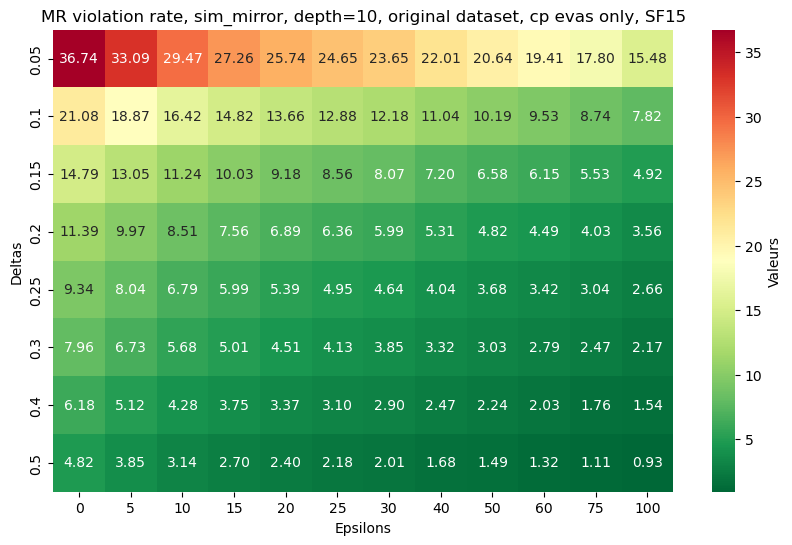

In [25]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10)[0],0,10, ', original dataset, cp evas only, SF15')

##### Evaluations with a mate

0          5          10         15         20         25   \
0.05  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.10  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.15  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.20  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.25  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.30  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.40  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   
0.50  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414   

            30         40         50         60         75         100  
0.05  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.10  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.15  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.20  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.25  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.30  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.40  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414  
0.50  34.642414  34.642414  34.642414  34.642414  34.642414  34.642414

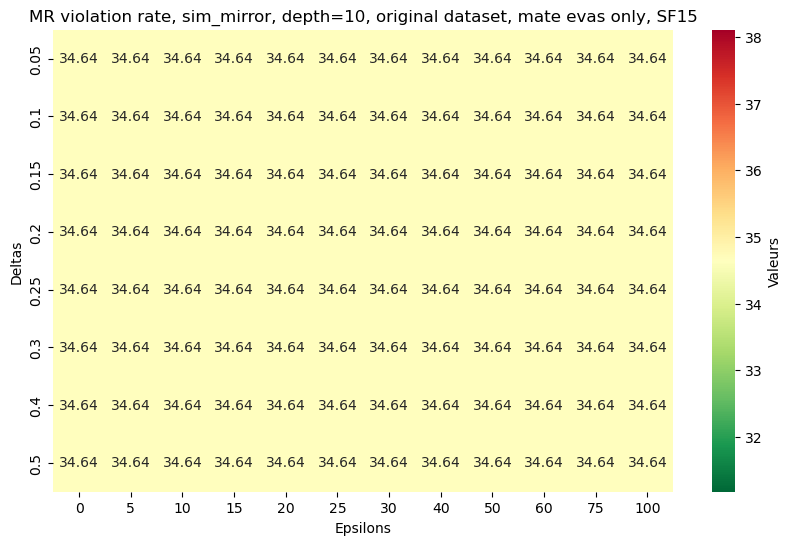

In [26]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10)[1],0,10, ', original dataset, mate evas only, SF15')

As we said, mate positions are not affected by thresholds. Since 30.43% of the mate positions have problems detected by MRs, regardless of the thresholds every grid square sees its value affected by a 30.43% of failure rate with a weight of 26.6%. If we check only the positions with a difference in centipawns, we can see that many squares of the grid have now a way lower value than before.

Note : as the MRs were designed by the original article, MRs are violated if the type is mate and value isn't exactly the same after mutation. Actually on these positions, there is no case where both evaluations show a mate but indicate values with an opposite sign.

Now we'll try to increase the depth.

#### depth = 15, splitting

In [27]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_15)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_15)[1])))

Mates proportion :  0.4397500976181179


The mates proportion became higher, which may be the reason why increasing the depth was not improving our results.

##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  36.841372  32.032339  27.453304  25.069696  23.452746  22.267912   
0.10  21.368832  18.476443  15.340117  13.618623  12.531363  11.813493   
0.15  14.824366  12.656816  10.440480   9.123223   8.265960   7.701422   
0.20  11.513800   9.694731   8.063842   7.060217   6.356287   5.882353   
0.25   9.583217   7.994146   6.683858   5.833566   5.206301   4.843881   
0.30   8.231112   6.711737   5.596599   4.899638   4.349038   4.042375   
0.40   6.189016   4.899638   4.070254   3.547533   3.115417   2.899359   
0.50   4.655701   3.519654   2.836632   2.404516   2.028157   1.839978   

            30         40         50         60         75         100  
0.05  21.306105  19.863396  18.943407  18.023418  17.096459  15.765263  
0.10  11.172289  10.189573   9.666853   9.227767   8.795651   8.377474  
0.15   7.178701   6.467800   6.119320   5.791748   5.519933   5.296905  
0.20   5.478115   4.913577   4.641762   4.397825   4.230555   4.091163  
0.25   4.488430   4.007527   3.784500   3.575411   3.463897   3.352384  
0.30   3.756621   3.359353   3.192083   3.052690   2.955116   2.864511  
0.40   2.697240   2.376638   2.279063   2.181489   2.097853   2.049066  
0.50   1.693616   1.421801   1.345135   1.261500   1.198773   1.163925

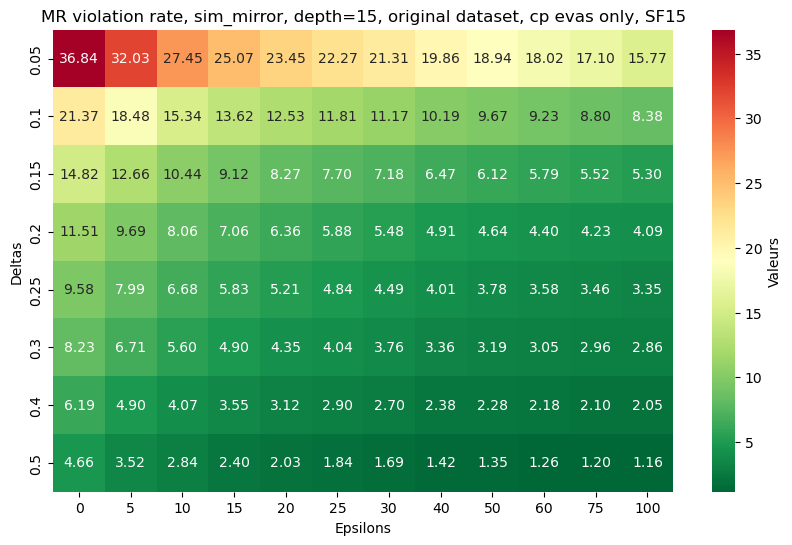

In [28]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_15)[0],0,15, ', original dataset, cp evas only, SF15')

##### Evaluations with a mate

In [29]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_15)[1],0,1,1),'%')

Mates failure rate :  37.79968034096963 %


#### depth = 20, splitting <a id='mirror15split'>[(Link V16)](#mirror16split)</a>

In [30]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_20)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_20)[1])))

Mates proportion :  0.5365958612056488


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  38.671281  33.766672  28.482188  25.443188  23.687321  22.361979   
0.10  23.915246  21.070404  17.567111  15.169678  13.852777  13.033936   
0.15  17.111261  15.195003  12.721594  10.813777   9.775452   9.159210   
0.20  13.228094  11.573527   9.842985   8.399460   7.572176   7.082560   
0.25  11.185210   9.716360   8.323485   7.200743   6.516968   6.086443   
0.30   9.640385   8.230626   7.065676   6.137093   5.579943   5.225393   
0.40   7.318926   6.179301   5.208509   4.524734   4.111092   3.807192   
0.50   5.613709   4.566942   3.705892   3.089651   2.760425   2.507175   

            30         40         50         60         75         100  
0.05  21.509370  20.420395  19.753503  19.238562  18.622320  17.558670  
0.10  12.518994  11.911194  11.556644  11.286510  11.092352  10.805335  
0.15   8.813101   8.365693   8.146210   7.985818   7.884518   7.749451  
0.20   6.837751   6.500084   6.339693   6.246834   6.179301   6.069559  
0.25   5.858518   5.563059   5.411109   5.335134   5.276043   5.191626  
0.30   5.022793   4.752659   4.626034   4.558501   4.507851   4.440317  
0.40   3.655242   3.401992   3.292251   3.258484   3.241601   3.199392  
0.50   2.397434   2.152625   2.068209   2.051325   2.034442   2.009117

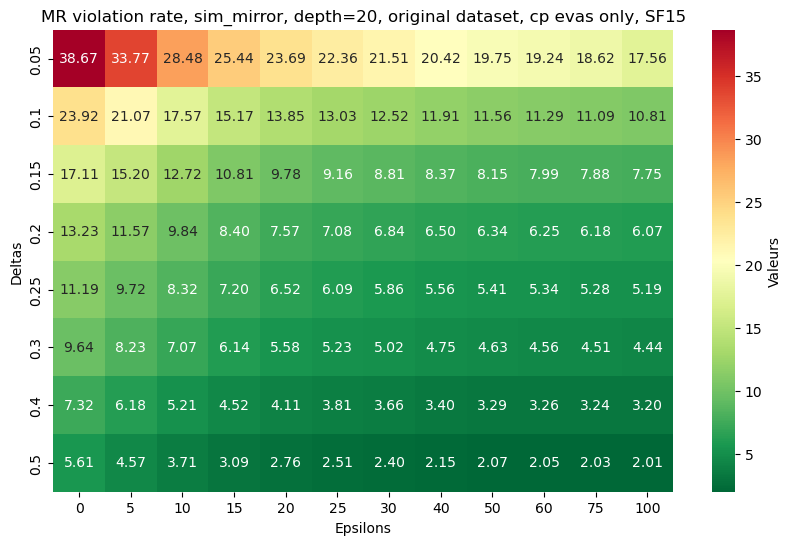

In [31]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_20)[0],0,20, ', original dataset, cp evas only, SF15')

##### Evaluations with a mate

In [32]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_20)[1],0,1,1),'%')

Mates failure rate :  34.27863235401327 %


Increasing the depth did not improve our results, now we will make the grid for only the positions that were taken from real games. These positions are the 1234 last ones in our dataset.

#### depth = 10, real positions <a id='mirror15real10'>[(Link V16)](#mirror16real10)</a>

In [33]:
#function to get real positions
def real_positions(evas):
    real = []
    real2 = []
    indexy = []
    ev1s = []
    ev2s = []
    index = 0
    real_pos = dataset[24768:]
    #indexent2 = 0
    for indexent, eva in evas.iterrows():
        for pos in real_pos:
            if eva['pos1'] == pos and eva['pos1'] not in real:
                #print(indexent - indexent2, index)
                #indexent2 = indexent
                indexy.append(index)
                index+=1
                real.append(eva['pos1'])
                real2.append(eva['pos2'])
                ev1s.append(eva['evaluation pos1'])
                ev2s.append(eva['evaluation pos2'])
    d = {'index': indexy, 'pos1': real, 'evaluation pos1': ev1s,
             'pos2': real2, 'evaluation pos2': ev2s} 
    df = pd.DataFrame(data=d)
    return df
                
    

0          5          10         15         20         25   \
0.05  66.334992  64.759536  58.291874  47.761194  39.054726  32.172471   
0.10  46.683250  45.854063  42.620232  36.567164  30.679934  25.953566   
0.15  34.660033  33.996683  31.260365  26.948590  23.383085  19.734660   
0.20  26.368159  26.036484  23.963516  20.812604  18.325041  15.422886   
0.25  22.470978  22.139303  20.232172  17.412935  15.257048  12.935323   
0.30  19.237148  18.905473  17.247098  14.842454  13.018242  11.111111   
0.40  15.422886  15.174129  13.847430  11.857380  10.199005   8.789386   
0.50  12.852405  12.603648  11.276949   9.784411   8.457711   7.131012   

            30         40         50        60        75        100  
0.05  26.119403  17.330017  11.691542  8.955224  5.555556  2.736318  
0.10  21.641791  15.091211  10.530680  8.208955  5.058043  2.570481  
0.15  16.998342  12.354892   9.038143  7.462687  4.560531  2.238806  
0.20  13.598673  10.116086   7.628524  6.467662  4.311774  2.238806  
0.25  11.525705   8.374793   6.384743  5.389718  3.648425  1.990050  
0.30   9.784411   7.048093   5.638474  4.726368  3.316750  1.741294  
0.40   7.877280   5.472637   4.228856  3.399668  2.321725  1.326700  
0.50   6.384743   4.394693   3.399668  2.736318  1.990050  1.077944

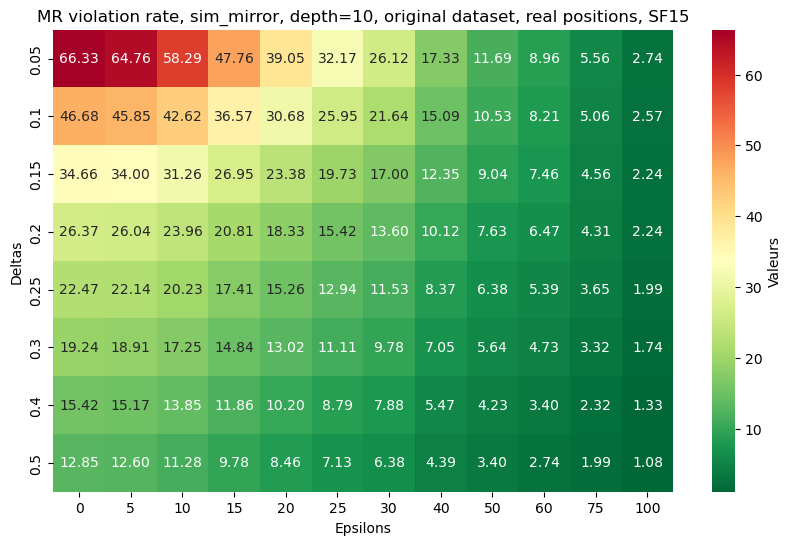

In [34]:
evaluations50000_sim_mirror_d_10_real = real_positions(evaluations50000_sim_mirror_d_10[24000:])
evaluations50000_sim_mirror_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_10_real,0,10, ', original dataset, real positions, SF15')

#### depth = 15, real positions

0          5          10         15         20         25   \
0.05  56.965174  54.228856  46.434494  37.230514  28.441128  22.636816   
0.10  34.577114  33.333333  29.187396  24.378109  19.734660  16.915423   
0.15  24.875622  23.880597  20.895522  17.744610  14.510779  12.437811   
0.20  19.154229  18.242123  15.754561  13.515755  10.945274   9.369818   
0.25  15.257048  14.510779  12.520730  11.028192   8.789386   7.711443   
0.30  12.271973  11.525705   9.867330   8.789386   6.799337   5.970149   
0.40   9.286899   8.623549   7.213930   6.384743   4.643449   3.814262   
0.50   8.208955   7.545605   6.384743   5.638474   3.897181   3.316750   

            30         40        50        60        75        100  
0.05  17.247098  10.862355  7.213930  4.809287  3.067993  1.575456  
0.10  13.184080   8.706468  5.804312  4.311774  2.985075  1.575456  
0.15   9.369818   6.053068  4.063018  3.067993  2.072968  1.160862  
0.20   6.965174   4.311774  2.736318  2.072968  1.492537  0.746269  
0.25   5.555556   3.233831  2.072968  1.658375  1.243781  0.746269  
0.30   4.394693   2.487562  1.575456  1.326700  0.995025  0.663350  
0.40   2.819237   1.575456  0.995025  0.829187  0.497512  0.414594  
0.50   2.570481   1.326700  0.912106  0.746269  0.497512  0.414594

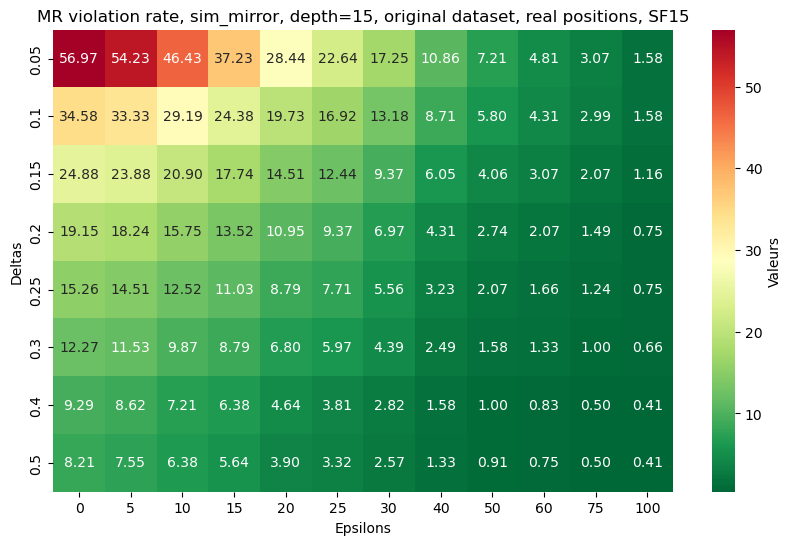

In [35]:
evaluations50000_sim_mirror_d_15_real = real_positions(evaluations50000_sim_mirror_d_15[24000:])
evaluations50000_sim_mirror_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_15_real,0,15, ', original dataset, real positions, SF15')

#### depth = 20, real positions <a id='mirror15real'>[(Link V16)](#mirror16real)</a>

0          5          10         15         20         25   \
0.05  50.671141  48.489933  39.513423  30.453020  23.489933  17.281879   
0.10  29.362416  28.187919  24.244966  19.127517  14.597315  11.409396   
0.15  19.630872  19.043624  16.862416  13.255034  10.151007   7.718121   
0.20  14.010067  13.506711  11.912752   9.144295   7.046980   5.201342   
0.25  11.912752  11.409396   9.899329   7.466443   5.788591   4.362416   
0.30   9.899329   9.395973   7.969799   5.956376   4.781879   3.607383   
0.40   7.885906   7.382550   6.208054   4.697987   3.775168   2.768456   
0.50   6.963087   6.459732   5.369128   3.859060   2.936242   2.097315   

            30        40        50        60        75        100  
0.05  13.422819  9.479866  7.885906  6.459732  5.117450  3.355705  
0.10   8.892617  6.375839  5.369128  4.362416  3.607383  2.684564  
0.15   6.124161  4.697987  3.942953  3.271812  2.684564  2.097315  
0.20   4.194631  3.271812  2.684564  2.348993  2.013423  1.510067  
0.25   3.439597  2.684564  2.097315  1.929530  1.677852  1.258389  
0.30   2.768456  2.097315  1.510067  1.342282  1.174497  0.922819  
0.40   2.097315  1.426174  0.922819  0.755034  0.755034  0.587248  
0.50   1.510067  0.838926  0.503356  0.419463  0.419463  0.251678

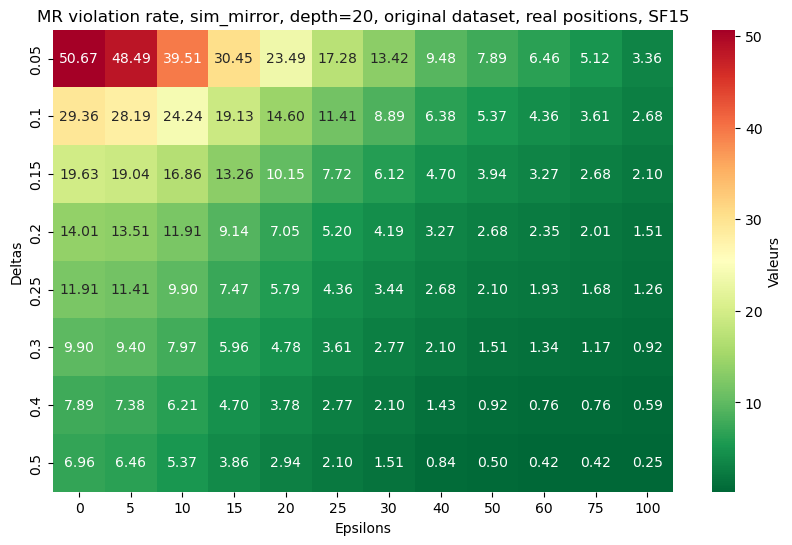

In [36]:
evaluations50000_sim_mirror_d_20_real = real_positions(evaluations50000_sim_mirror_d_20[24000:])
evaluations50000_sim_mirror_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_20_real,0,20, ', original dataset, real positions, SF15')

On plausible positions, we an see that beside for the tightest thresholds, the number of problems detected by the MRs are way lower, and increasing the depth is now improving our results. We can explain the increase in detected problems for tight thresholds with the fact that on real positions, centipawns values tend to be really lower than before. If for instance, we have a position with an evaluation with a centipawns value of 5 (meaning an advantage of 0.05 for White), and its mirrored version gets an evaluation with a centipawns value of -7 (meaning an advantage of 0.07 for Black), the delta value will be abs((5-7)/(5+7)) = 0.17, which is superior to 0.05. Since the centipawns difference is not equal to 0, the MRs will detect a problem, even though the difference is meaningless.

### sim_axis

#### depth = 10, entire dataset <a id='axis15entire10'>[(Link V16)](#axis16entire10)</a>

Our grid in the first time.

0          5          10         15         20         25   \
0.05  35.898634  33.193196  30.701857  29.210946  28.128771  27.229554   
0.10  24.594184  22.846354  21.215306  20.117560  19.339017  18.696718   
0.15  20.063062  18.720075  17.575616  16.711433  16.131418  15.644829   
0.20  17.583401  16.446728  15.578652  14.846822  14.375803  14.005995   
0.25  16.209272  15.181595  14.422515  13.834715  13.449336  13.134026   
0.30  15.251664  14.259021  13.605045  13.130134  12.818716  12.546226   
0.40  13.912570  13.063957  12.507299  12.153062  11.923391  11.732648   
0.50  13.087314  12.336019  11.861108  11.588618  11.401767  11.238273   

            30         40         50         60         75         100  
0.05  26.486045  25.287088  24.419012  23.550936  22.457083  20.973958  
0.10  18.198451  17.377087  16.824322  16.361088  15.827786  15.232201  
0.15  15.259450  14.640508  14.220094  13.865857  13.484371  13.079528  
0.20  13.733505  13.254700  12.943283  12.659115  12.378839  12.082993  
0.25  12.888785  12.499513  12.234809  12.001246  11.763790  11.549691  
0.30  12.332127  12.009031  11.783254  11.592510  11.401767  11.246059  
0.40  11.553583  11.312235  11.148741  11.012496  10.872358  10.743898  
0.50  11.078672  10.876251  10.747791  10.634902  10.518121  10.416910

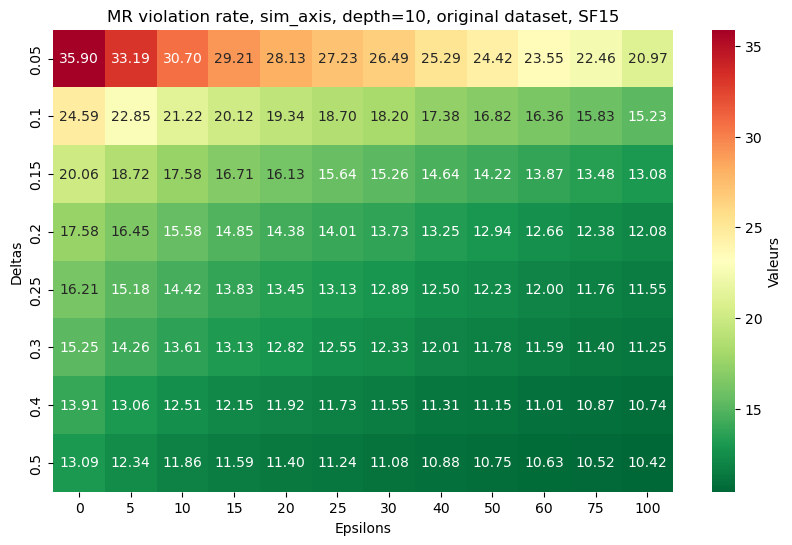

In [37]:
path = os.path.join('sim_axis_d=10','evaluations50000_sim_axis_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_10 = pickle.load(file)

tests(evaluations50000_sim_axis_d_10,1,10, ', original dataset, SF15')

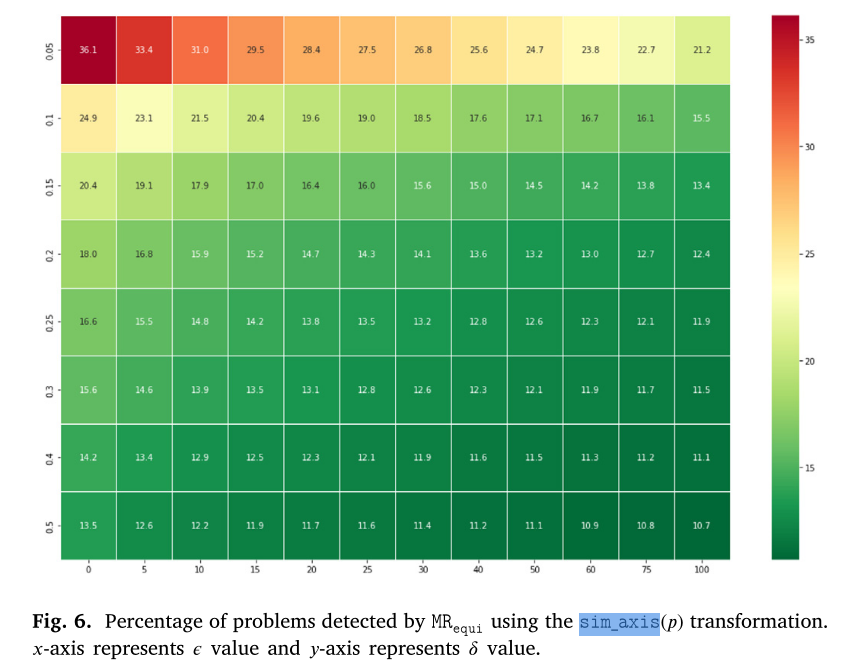

In [38]:
from IPython.display import display, Image

display(Image(filename='originalaxis10_am.png',width=900,height=900))

#### depth = 10, splitting <a id='axis15split10'>[(Link V16)](#axis16split10)</a>

In [39]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_10)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_10)[1])))

Mates proportion :  0.28385690373311534


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  36.538566  32.760776  29.281948  27.200087  25.688971  24.433332   
0.10  20.753384  18.312768  16.035223  14.502365  13.415231  12.518345   
0.15  14.426265  12.550959  10.952873   9.746154   8.936240   8.256781   
0.20  10.963744   9.376529   8.164375   7.142469   6.484753   5.968364   
0.25   9.044953   7.609936   6.549981   5.729195   5.191064   4.750775   
0.30   7.707778   6.321683   5.408491   4.745339   4.310485   3.929989   
0.40   5.837908   4.652933   3.875632   3.380986   3.060282   2.793934   
0.50   4.685547   3.636462   2.973311   2.592814   2.331902   2.103604   

            30         40         50         60         75         100  
0.05  23.395119  21.720933  20.508779  19.296624  17.769202  15.698212  
0.10  11.822580  10.675654   9.903789   9.256944   8.512257   7.680600  
0.15   7.718650   6.854378   6.267326   5.772680   5.239985   4.674675  
0.20   5.587868   4.919280   4.484427   4.087623   3.696255   3.283144  
0.25   4.408327   3.864761   3.495135   3.168995   2.837419   2.538457  
0.30   3.631027   3.179866   2.864597   2.598250   2.331902   2.114475  
0.40   2.543893   2.206882   1.978583   1.788335   1.592651   1.413274  
0.50   1.880741   1.598087   1.418710   1.261075   1.098005   0.956678

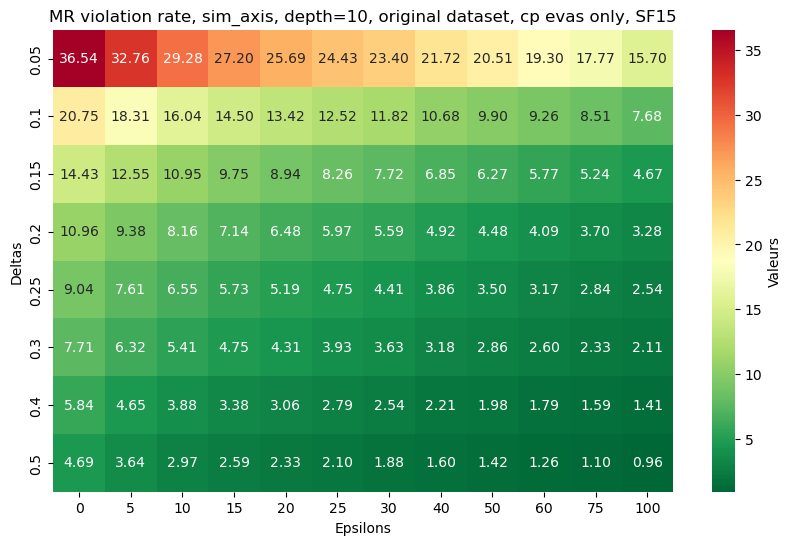

In [40]:
tests(split_mate_cp(evaluations50000_sim_axis_d_10)[0],1,10, ', original dataset, cp evas only, SF15')

##### Evaluations with a mate

In [41]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_10)[1],1,1,1),'%')

Mates failure rate :  34.28414701042239 %


#### depth = 10, real positions

0          5          10         15         20         25   \
0.05  65.339967  62.603648  55.140962  45.605307  36.815920  29.187396   
0.10  44.112769  42.703151  39.137645  34.079602  28.441128  23.548922   
0.15  32.255390  31.094527  28.689884  24.958541  21.558872  18.159204   
0.20  25.290216  24.295191  22.305141  19.237148  16.500829  14.179104   
0.25  20.978441  19.983416  18.159204  15.754561  13.515755  11.774461   
0.30  17.827529  16.915423  15.174129  13.184080  11.194030   9.618574   
0.40  13.266998  12.520730  11.111111   9.452736   8.291874   7.213930   
0.50  11.525705  10.779436   9.452736   8.540630   7.462687   6.467662   

            30         40         50        60        75        100  
0.05  23.880597  16.169154  11.774461  9.121061  5.970149  3.233831  
0.10  20.398010  14.344942  10.696517  8.291874  5.721393  3.233831  
0.15  15.920398  11.525705   8.955224  7.296849  5.306799  3.067993  
0.20  12.852405   9.286899   7.545605  6.218905  4.643449  2.819237  
0.25  10.613599   7.628524   6.135987  4.975124  3.648425  2.570481  
0.30   8.623549   6.053068   4.809287  3.980100  2.985075  2.238806  
0.40   6.467662   4.477612   3.814262  3.316750  2.487562  1.907131  
0.50   5.721393   3.980100   3.399668  2.985075  2.155887  1.741294

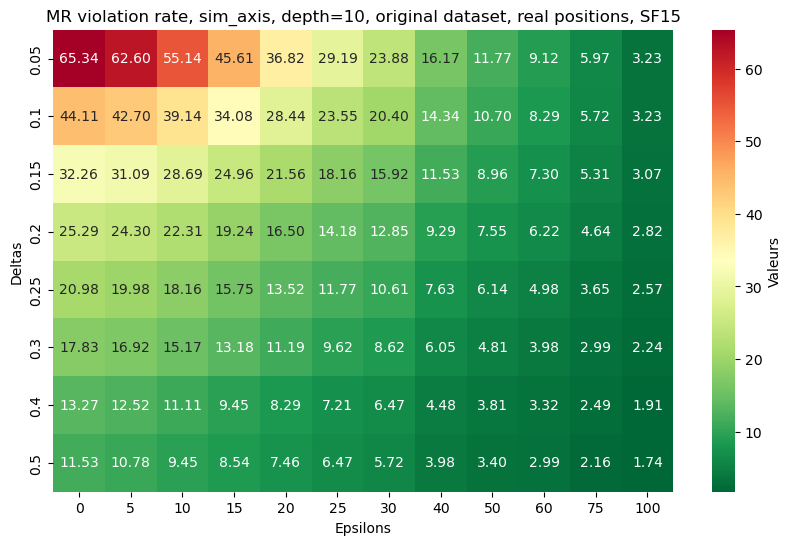

In [42]:
evaluations50000_sim_axis_d_10_real = real_positions(evaluations50000_sim_axis_d_10[24000:])
evaluations50000_sim_axis_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_10_real,1,10, ', original dataset, real positions, SF15')

#### depth = 15, entire dataset

0          5          10         15         20         25   \
0.05  36.909721  34.250788  31.693074  30.365555  29.384514  28.660412   
0.10  28.399580  26.819014  25.090513  24.156188  23.517733  23.027212   
0.15  24.736248  23.607272  22.342041  21.621832  21.115739  20.757582   
0.20  22.867598  21.956632  20.995056  20.442247  20.029587  19.749290   
0.25  21.781446  20.952233  20.200880  19.733717  19.414490  19.173123   
0.30  21.139098  20.364387  19.729824  19.336629  19.068011  18.846109   
0.40  19.998443  19.336629  18.822751  18.491844  18.293300  18.125900   
0.50  19.145871  18.546346  18.094756  17.822245  17.662631  17.541947   

            30         40         50         60         75         100  
0.05  28.150426  27.496399  26.928018  26.519251  26.098805  25.281271  
0.10  22.661268  22.256394  21.956632  21.777553  21.571223  21.314283  
0.15  20.442247  20.158057  19.963406  19.819364  19.698680  19.546852  
0.20  19.500136  19.278234  19.141978  19.032974  18.947327  18.838323  
0.25  18.962900  18.787714  18.670923  18.585277  18.515202  18.441235  
0.30  18.678709  18.519095  18.425663  18.351695  18.304979  18.246584  
0.40  18.020789  17.915677  17.849496  17.779421  17.752170  17.709347  
0.50  17.467980  17.390120  17.331724  17.273329  17.249971  17.211041

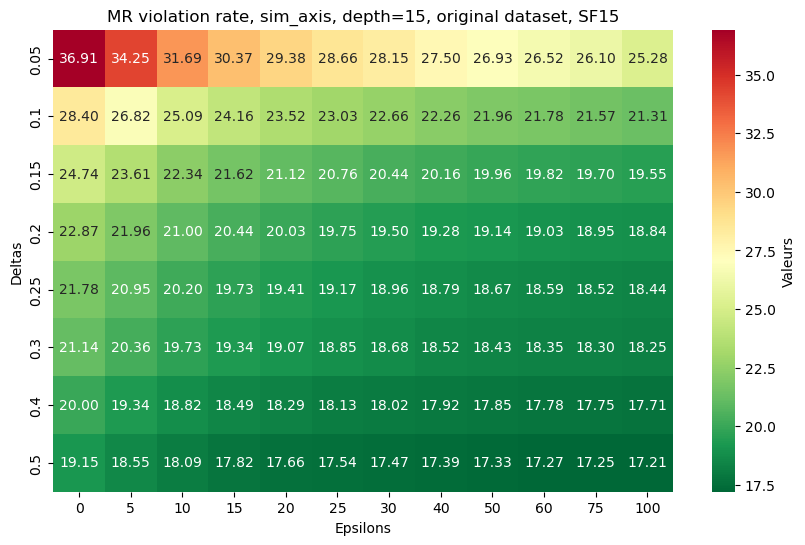

In [43]:
path = os.path.join('sim_axis_d=15','evaluations50000_sim_axis_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_15 = pickle.load(file)

tests(evaluations50000_sim_axis_d_15,1,15, ', original dataset, SF15')

#### depth = 15, splitting

In [44]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_15)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_15)[1])))

Mates proportion :  0.44193560945225213


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  36.309731  31.545169  26.961981  24.583188  22.825253  21.527729   
0.10  21.060342  18.228113  15.130799  13.456575  12.312522  11.433554   
0.15  14.495989  12.472968  10.205790   8.915242   8.008371   7.366585   
0.20  11.147541   9.515173   7.792117   6.801535   6.062086   5.559819   
0.25   9.201256   7.715382   6.369027   5.531915   4.959888   4.527381   
0.30   8.050227   6.662016   5.524939   4.820370   4.339030   3.941402   
0.40   6.006278   4.820370   3.899547   3.306592   2.950820   2.650855   
0.50   4.478549   3.404255   2.595047   2.106732   1.820719   1.604465   

            30         40         50         60         75         100  
0.05  20.613882  19.441925  18.423439  17.690966  16.937565  15.472619  
0.10  10.777817  10.052319   9.515173   9.194280   8.824555   8.364144  
0.15   6.801535   6.292292   5.943495   5.685385   5.469131   5.197070  
0.20   5.113359   4.715731   4.471573   4.276247   4.122776   3.927450  
0.25   4.150680   3.836763   3.627485   3.474015   3.348448   3.215905  
0.30   3.641437   3.355424   3.188001   3.055459   2.971747   2.867108  
0.40   2.462504   2.274154   2.155563   2.029997   1.981165   1.904430  
0.50   1.471922   1.332403   1.227764   1.123125   1.081270   1.011510

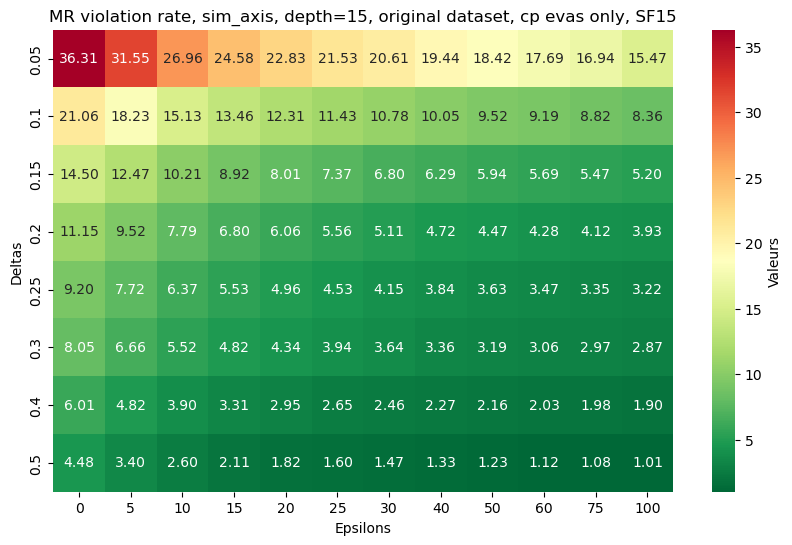

In [45]:
tests(split_mate_cp(evaluations50000_sim_axis_d_15)[0],1,15, ', original dataset, cp evas only, SF15')

In [46]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_15)[1],1,1,1),'%')

Mates failure rate :  37.66737138830162 %


#### depth = 15, real positions

0          5          10         15         20         25   \
0.05  57.131012  54.726368  45.854063  36.898839  27.611940  20.978441   
0.10  35.903814  34.742952  30.182421  25.456053  20.232172  15.837479   
0.15  25.456053  24.543947  21.144279  18.076285  14.262023  11.276949   
0.20  19.154229  18.325041  15.588723  13.432836  10.530680   8.208955   
0.25  15.671642  14.925373  12.686567  10.696517   8.540630   6.633499   
0.30  13.184080  12.437811  10.530680   8.789386   6.799337   5.223881   
0.40   9.618574   8.872305   7.296849   5.970149   4.726368   3.399668   
0.50   8.291874   7.545605   6.053068   4.975124   3.897181   2.736318   

            30         40        50        60        75        100  
0.05  16.003317  10.199005  7.462687  5.058043  3.482587  1.658375  
0.10  12.106136   8.043118  5.721393  4.228856  3.233831  1.575456  
0.15   8.126036   5.472637  4.063018  2.902156  2.321725  1.326700  
0.20   5.970149   3.980100  3.067993  2.238806  1.824212  1.160862  
0.25   4.809287   3.233831  2.570481  1.824212  1.575456  1.077944  
0.30   3.980100   2.653400  2.155887  1.409619  1.160862  0.829187  
0.40   2.570481   1.658375  1.492537  0.829187  0.663350  0.497512  
0.50   2.072968   1.492537  1.326700  0.663350  0.580431  0.414594

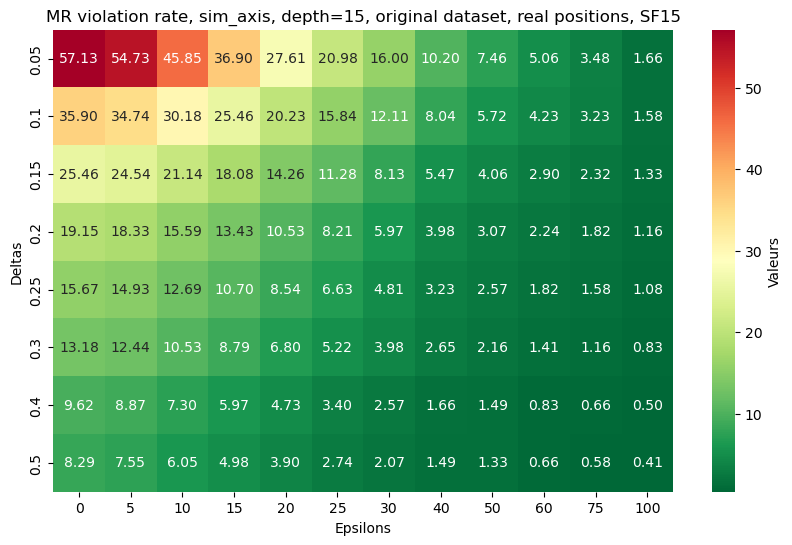

In [47]:
evaluations50000_sim_axis_d_15_real = real_positions(evaluations50000_sim_axis_d_15[24000:])
evaluations50000_sim_axis_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_15_real,1,15, ', original dataset, real positions, SF15')

#### depth = 20, entire dataset <a id='axis15entire'>[(Link V16)](#axis16entire)</a>

0          5          10         15         20         25   \
0.05  36.108294  33.833971  31.302177  29.909495  29.039557  28.575330   
0.10  29.125380  27.799017  26.176172  25.150191  24.557229  24.249044   
0.15  26.074744  25.146290  24.011079  23.187953  22.696419  22.474058   
0.20  24.447999  23.698994  22.844659  22.228291  21.818678  21.615823   
0.25  23.453226  22.790044  22.126863  21.608021  21.299836  21.124288   
0.30  22.743232  22.107357  21.533900  21.065772  20.831708  20.695170   
0.40  21.728954  21.147694  20.679566  20.305064  20.125614  20.008582   
0.50  20.886323  20.347975  19.953967  19.614574  19.466334  19.384411   

            30         40         50         60         75         100  
0.05  28.274947  27.736600  27.373800  27.108528  26.761333  26.293204  
0.10  24.046189  23.714598  23.527346  23.402512  23.258173  23.113833  
0.15  22.318015  22.080050  21.935710  21.861590  21.771865  21.705547  
0.20  21.510494  21.319341  21.210112  21.155497  21.089178  21.057970  
0.25  21.018959  20.866818  20.769291  20.718577  20.675665  20.656160  
0.30  20.605446  20.472810  20.390887  20.351876  20.320668  20.305064  
0.40  19.938363  19.817430  19.758914  19.719903  19.696497  19.684794  
0.50  19.325895  19.220566  19.177655  19.158149  19.146446  19.146446

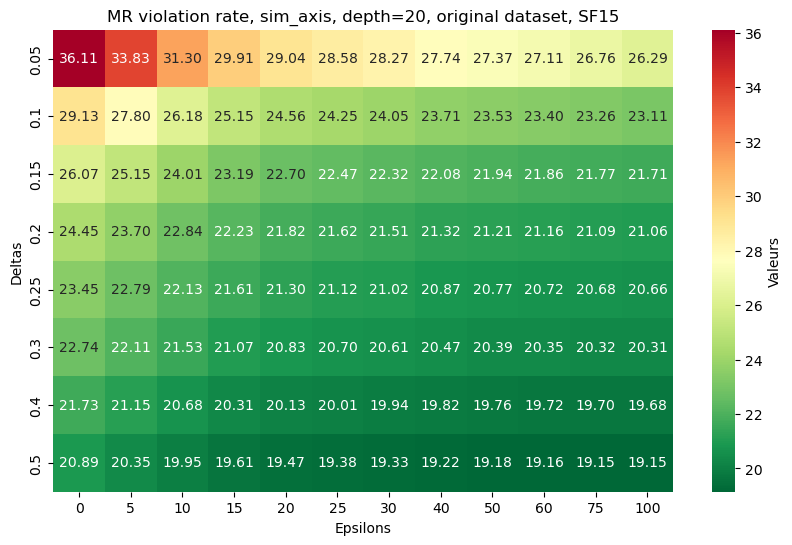

In [48]:
path = os.path.join('sim_axis_d=20','evaluations50000_sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_20 = pickle.load(file)

tests(evaluations50000_sim_axis_d_20,1,20, ', original dataset, SF15')

#### depth = 20, splitting <a id='axis15split'>[(Link V16)](#axis16split)</a>

In [49]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_20)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_20)[1])))

Mates proportion :  0.5357728017476788


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  38.588235  33.689076  28.235294  25.235294  23.361345  22.361345   
0.10  23.546218  20.689076  17.193277  14.983193  13.705882  13.042017   
0.15  16.974790  14.974790  12.529412  10.756303   9.697479   9.218487   
0.20  13.470588  11.857143  10.016807   8.689076   7.806723   7.369748   
0.25  11.327731   9.899160   8.470588   7.352941   6.689076   6.310924   
0.30   9.798319   8.428571   7.193277   6.184874   5.680672   5.386555   
0.40   7.613445   6.361345   5.352941   4.546218   4.159664   3.907563   
0.50   5.798319   4.638655   3.789916   3.058824   2.739496   2.563025   

            30         40         50         60         75         100  
0.05  21.714286  20.554622  19.773109  19.201681  18.453782  17.445378  
0.10  12.605042  11.890756  11.487395  11.218487  10.907563  10.596639  
0.15   8.882353   8.369748   8.058824   7.899160   7.705882   7.563025  
0.20   7.142857   6.731092   6.495798   6.378151   6.235294   6.168067  
0.25   6.084034   5.756303   5.546218   5.436975   5.344538   5.302521  
0.30   5.193277   4.907563   4.731092   4.647059   4.579832   4.546218  
0.40   3.756303   3.495798   3.369748   3.285714   3.235294   3.210084  
0.50   2.436975   2.210084   2.117647   2.075630   2.050420   2.050420

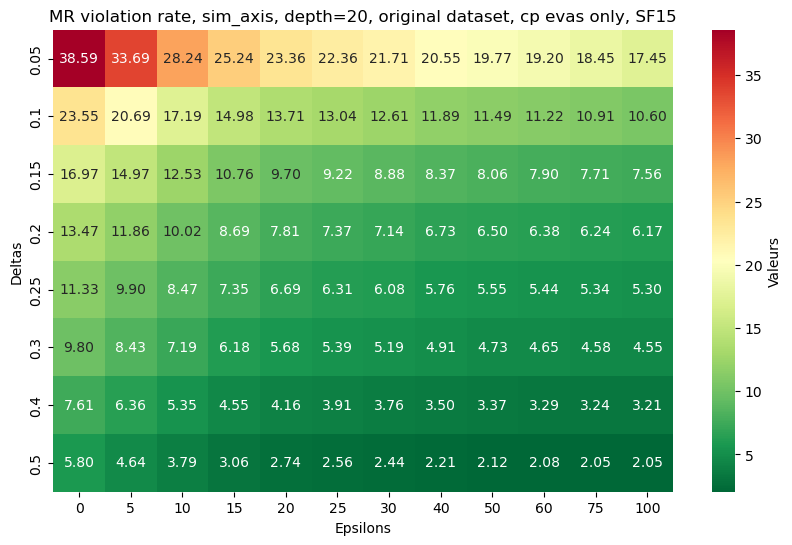

In [50]:
tests(split_mate_cp(evaluations50000_sim_axis_d_20)[0],1,20, ', original dataset, cp evas only, SF15')

In [51]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_20)[1],1,1,1),'%')

Mates failure rate :  33.95951652832386 %


#### depth = 20, real positions <a id='axis15real'>[(Link V16)](#axis16real)</a>

0          5          10         15         20         25   \
0.05  50.041982  47.355164  37.867338  28.379513  20.403023  16.204870   
0.10  29.051217  27.959698  23.929471  19.059614  14.609572  11.922754   
0.15  19.311503  18.387909  15.952981  12.426532   9.319899   7.640638   
0.20  14.273720  13.350126  11.502939   8.816121   6.717045   5.205709   
0.25  11.251050  10.327456   8.732158   6.549118   5.205709   4.030227   
0.30   9.655751   8.900084   7.556675   5.541562   4.366079   3.442485   
0.40   7.892527   7.136860   6.045340   4.366079   3.358522   2.602855   
0.50   6.129303   5.457599   4.617968   2.938707   2.183039   1.679261   

            30        40        50        60        75        100  
0.05  13.014274  9.068010  6.884971  5.877414  3.610411  2.099076  
0.10   9.739715  6.884971  5.205709  4.450042  3.106633  2.015113  
0.15   6.045340  4.198153  3.022670  2.854744  1.847187  1.343409  
0.20   4.198153  2.938707  2.099076  2.015113  1.259446  1.007557  
0.25   3.022670  2.099076  1.511335  1.427372  0.839631  0.755668  
0.30   2.434929  1.679261  1.175483  1.175483  0.755668  0.671704  
0.40   1.847187  1.175483  0.839631  0.839631  0.503778  0.419815  
0.50   1.091520  0.587741  0.503778  0.503778  0.251889  0.251889

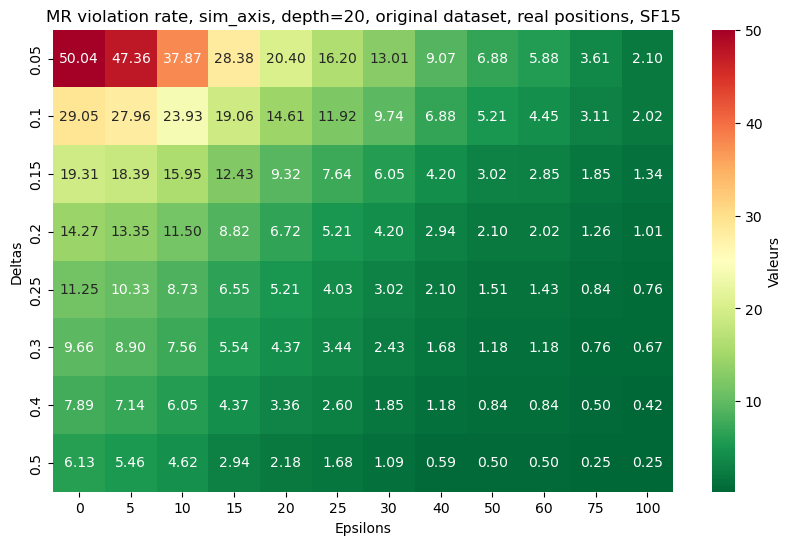

In [52]:
evaluations50000_sim_axis_d_20_real = real_positions(evaluations50000_sim_axis_d_20[24000:])
evaluations50000_sim_axis_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_20_real,1,20, ', original dataset, real positions, SF15')

### sim_diag

#### depth = 10, entire dataset

Our grid.

0          5          10         15         20         25   \
0.05  43.995485  38.623025  33.408578  30.948081  30.045147  29.367946   
0.10  31.083521  27.742664  24.063205  21.896163  21.128668  20.609481   
0.15  25.665914  22.911964  20.564334  18.690745  17.968397  17.629797   
0.20  22.618510  20.293454  18.668172  17.155756  16.613995  16.275395   
0.25  20.925508  18.690745  17.381490  16.252822  15.801354  15.485327   
0.30  19.593679  17.494357  16.343115  15.462754  15.033860  14.808126   
0.40  18.171558  16.410835  15.485327  14.853273  14.514673  14.334086   
0.50  17.246050  15.688488  14.920993  14.356659  14.153499  14.063205   

            30         40         50         60         75         100  
0.05  28.916479  27.787810  26.749436  25.801354  24.762980  23.250564  
0.10  20.225734  19.593679  19.345372  19.029345  18.735892  18.036117  
0.15  17.404063  16.930023  16.749436  16.523702  16.320542  15.914221  
0.20  16.072235  15.665914  15.553047  15.417607  15.237020  14.988713  
0.25  15.304740  14.966140  14.853273  14.717833  14.559819  14.356659  
0.30  14.627540  14.424379  14.379233  14.243792  14.108352  13.950339  
0.40  14.198646  14.018059  13.972912  13.860045  13.724605  13.634312  
0.50  13.927765  13.747178  13.702032  13.589165  13.521445  13.453725

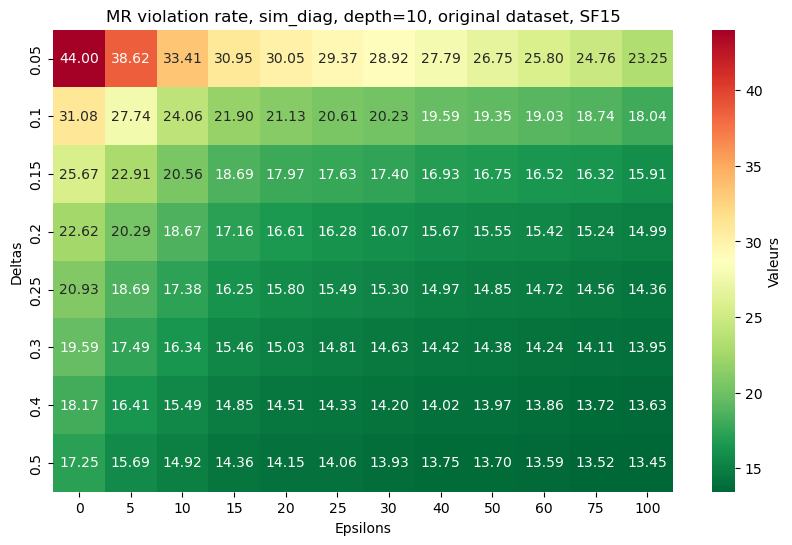

In [53]:
path = os.path.join('sim_diag_d=10','evaluations50000_sim_diag_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_10 = pickle.load(file)

tests(evaluations50000_sim_diag_d_10,2,10, ', original dataset, SF15')

The grid from the article.

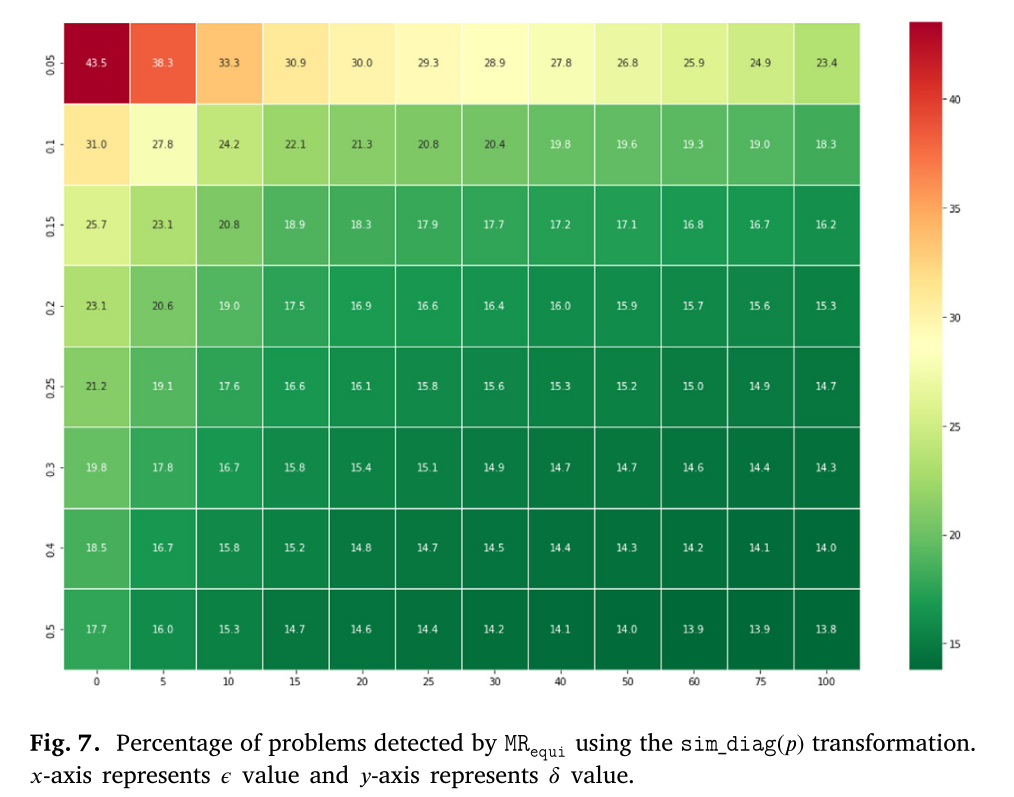

In [54]:
from IPython.display import display, Image

display(Image(filename='originaldiag10_am.png',width=900,height=900))

#### depth = 10, splitting

In [55]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_10)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_10)[1])))

Mates proportion :  0.3148984198645598


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  45.172982  37.331137  29.719934  26.128501  24.810544  23.822076   
0.10  26.326194  21.449753  16.079077  12.915980  11.795717  11.037891   
0.15  18.418451  14.398682  10.971993   8.237232   7.182867   6.688633   
0.20  13.970346  10.576606   8.204283   5.996705   5.205931   4.711697   
0.25  11.499176   8.237232   6.326194   4.678748   4.019769   3.558484   
0.30   9.555189   6.490939   4.810544   3.525535   2.899506   2.570016   
0.40   7.479407   4.909390   3.558484   2.635914   2.141680   1.878089   
0.50   6.128501   3.855025   2.734761   1.911038   1.614498   1.482702   

            30         40         50         60         75         100  
0.05  23.163097  21.515651  20.000000  18.616145  17.100494  14.892916  
0.10  10.477759   9.555189   9.192751   8.731466   8.303130   7.281713  
0.15   6.359143   5.667216   5.403624   5.074135   4.777595   4.184514  
0.20   4.415157   3.822076   3.657331   3.459638   3.196046   2.833608  
0.25   3.294893   2.800659   2.635914   2.438221   2.207578   1.911038  
0.30   2.306425   2.009885   1.943987   1.746293   1.548600   1.317957  
0.40   1.680395   1.416804   1.350906   1.186161   0.988468   0.856672  
0.50   1.285008   1.021417   0.955519   0.790774   0.691928   0.593081

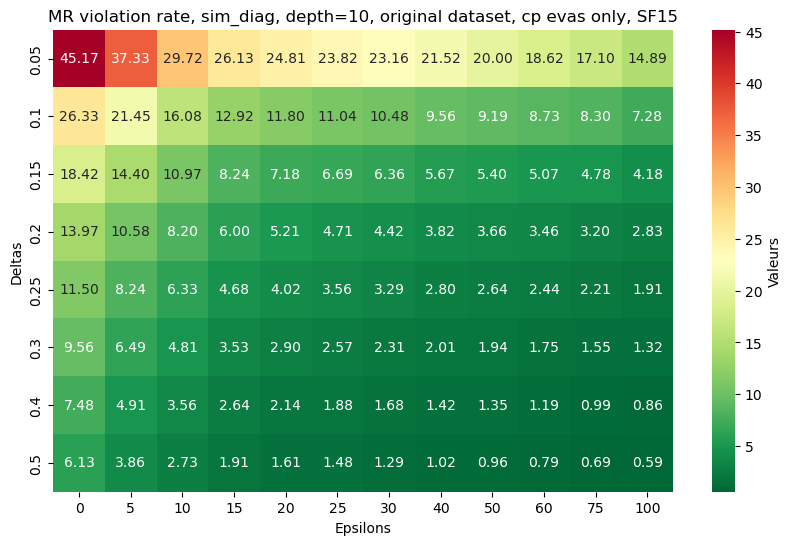

In [56]:
tests(split_mate_cp(evaluations50000_sim_diag_d_10)[0],2,10, ', original dataset, cp evas only, SF15')

In [57]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_10)[1],2,1,1),'%')

Mates failure rate :  41.43369175627241 %


#### depth = 10, real positions

Since this mutation only works on positions without any pawn, its interest on real positions is deeply lowered. Furthermore, our dataset doesn't contain real positions with no pawn.

In [58]:
len(real_positions(evaluations50000_sim_diag_d_10))

0

#### depth = 15, entire dataset

0          5          10         15         20         25   \
0.05  45.079007  40.383747  34.627540  33.069977  32.302483  31.670429   
0.10  36.185102  33.318284  29.006772  27.629797  26.930023  26.478555   
0.15  31.286682  29.097065  26.185102  24.988713  24.334086  23.950339   
0.20  28.397291  26.681716  24.604966  23.656885  23.069977  22.731377   
0.25  26.952596  25.417607  23.769752  23.115124  22.595937  22.279910   
0.30  26.185102  24.717833  23.318284  22.821670  22.437923  22.144470   
0.40  25.011287  23.724605  22.618510  22.279910  21.963883  21.693002   
0.50  24.108352  22.957111  22.076749  21.805869  21.557562  21.354402   

            30         40         50         60         75         100  
0.05  31.038375  30.361174  29.796840  29.277652  28.623025  27.742664  
0.10  25.981941  25.598194  25.395034  25.191874  25.033860  24.785553  
0.15  23.566591  23.295711  23.115124  23.047404  22.957111  22.821670  
0.20  22.370203  22.167043  22.031603  21.986456  21.963883  21.918736  
0.25  22.009029  21.828442  21.693002  21.647856  21.625282  21.580135  
0.30  21.896163  21.715576  21.625282  21.580135  21.557562  21.557562  
0.40  21.467269  21.376975  21.331828  21.286682  21.264108  21.264108  
0.50  21.173815  21.106095  21.060948  21.038375  21.015801  21.015801

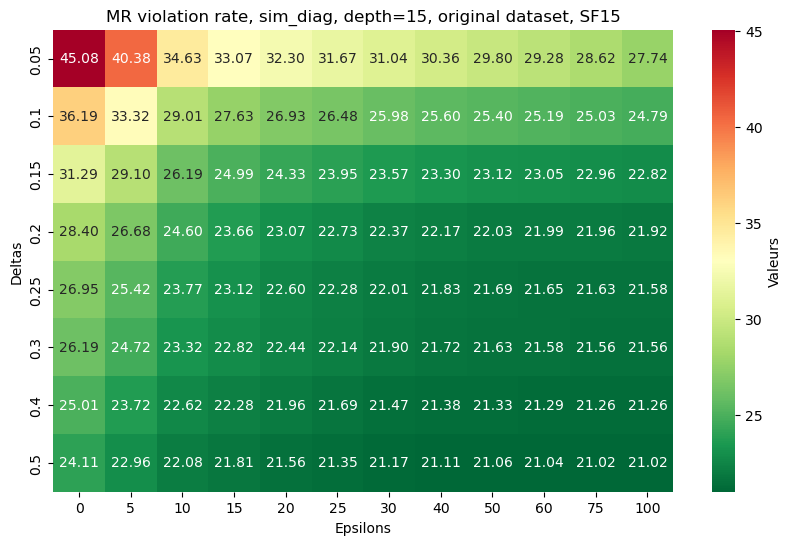

In [59]:
path = os.path.join('sim_diag_d=15','evaluations50000_sim_diag_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_15 = pickle.load(file)

tests(evaluations50000_sim_diag_d_15,2,15, ', original dataset, SF15')

#### depth = 15, splitting

In [60]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_15)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_15)[1])))

Mates proportion :  0.46772009029345374


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  46.480068  37.659033  26.844784  23.918575  22.476675  21.289228   
0.10  29.770992  24.385072  16.284987  13.698049  12.383376  11.535199   
0.15  20.568278  16.454623  10.983885   8.736217   7.506361   6.785411   
0.20  15.139949  11.916879   8.015267   6.234097   5.131467   4.495335   
0.25  12.425785   9.541985   6.446141   5.216285   4.240882   3.647159   
0.30  10.983885   8.227311   5.597964   4.664970   3.944020   3.392706   
0.40   8.778626   6.361323   4.283291   3.647159   3.053435   2.544529   
0.50   7.082273   4.919423   3.265479   2.756573   2.290076   1.908397   

            30         40         50         60         75         100  
0.05  20.101781  18.829517  17.769296  16.793893  15.564037  13.910093  
0.10  10.602205   9.881255   9.499576   9.117897   8.821035   8.354538  
0.15   6.064461   5.555556   5.216285   5.089059   4.919423   4.664970  
0.20   3.816794   3.435115   3.180662   3.095844   3.053435   2.968617  
0.25   3.138253   2.798982   2.544529   2.459712   2.417303   2.332485  
0.30   2.926209   2.586938   2.417303   2.332485   2.290076   2.290076  
0.40   2.120441   1.950806   1.865988   1.781170   1.738762   1.738762  
0.50   1.569126   1.441900   1.357082   1.314673   1.272265   1.272265

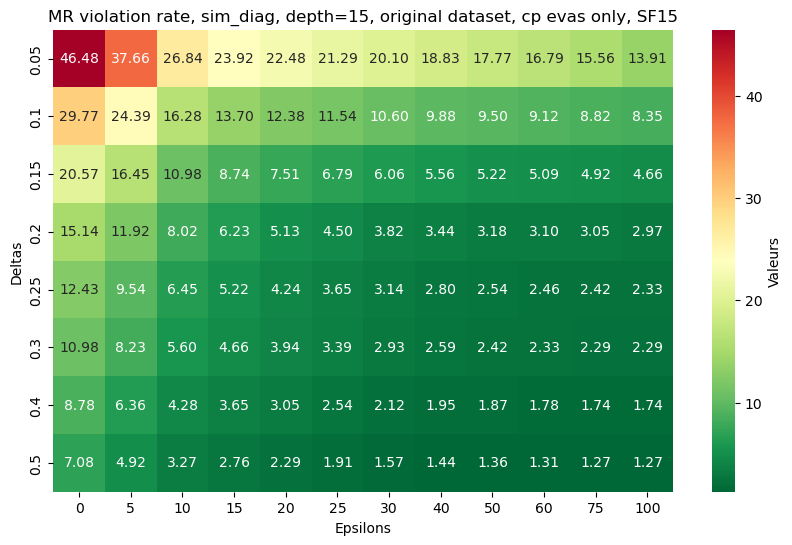

In [61]:
tests(split_mate_cp(evaluations50000_sim_diag_d_15)[0],2,15, ', original dataset, cp evas only, SF15')

In [62]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_15)[1],2,1,1),'%')

Mates failure rate :  43.48455598455598 %


#### depth = 20, entire dataset <a id='diag15entire'>[(Link V16)](#diag16entire)</a>

0          5          10         15         20         25   \
0.05  41.363739  36.915782  32.987130  31.000226  30.142244  29.510047   
0.10  34.499887  31.903364  29.013321  27.229623  26.597426  26.123278   
0.15  30.864755  29.058478  27.229623  25.603974  25.016934  24.542786   
0.20  28.516595  27.184466  26.010386  24.881463  24.317002  23.955746   
0.25  27.319937  26.078121  25.242718  24.339580  23.842854  23.526755   
0.30  26.597426  25.378189  24.700835  23.978325  23.504177  23.210657   
0.40  25.649131  24.610522  24.000903  23.459020  23.120343  22.894559   
0.50  24.858885  23.910589  23.413863  22.984872  22.759088  22.578460   

            30         40         50         60         75         100  
0.05  29.081057  28.606909  27.997291  27.613457  27.365094  26.597426  
0.10  25.897494  25.671709  25.423346  25.333032  25.333032  25.129826  
0.15  24.407315  24.226688  24.023482  23.955746  23.955746  23.842854  
0.20  23.820275  23.639648  23.504177  23.436442  23.436442  23.368706  
0.25  23.391285  23.233235  23.142922  23.097765  23.097765  23.052608  
0.30  23.097765  22.939716  22.871980  22.826823  22.826823  22.781666  
0.40  22.781666  22.646196  22.623617  22.578460  22.578460  22.533303  
0.50  22.488146  22.375254  22.352676  22.307519  22.307519  22.284940

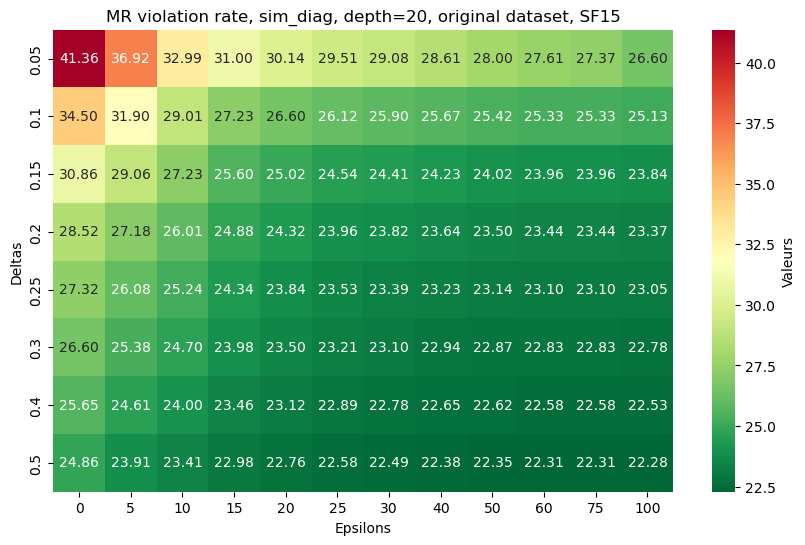

In [63]:
path = os.path.join('sim_diag_d=20','evaluations50000_sim_diag_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_20 = pickle.load(file)

tests(evaluations50000_sim_diag_d_20,2,20, ', original dataset, SF15')

#### depth = 20, splitting <a id='diag15split'>[(Link V16)](#diag16split)</a>

In [64]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_20)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_20)[1])))

Mates proportion :  0.5502370738315647


##### Evaluations with a difference in centipawns

0          5          10         15         20         25   \
0.05  44.829317  34.939759  26.204819  21.787149  19.879518  18.473896   
0.10  29.568273  23.795181  17.369478  13.403614  11.997992  10.943775   
0.15  21.485944  17.469880  13.403614   9.789157   8.483936   7.429719   
0.20  16.265060  13.303213  10.692771   8.182731   6.927711   6.124498   
0.25  13.604418  10.843373   8.985944   6.977912   5.873494   5.170683   
0.30  11.997992   9.287149   7.781124   6.174699   5.120482   4.467871   
0.40   9.889558   7.580321   6.224900   5.020080   4.267068   3.765060   
0.50   8.132530   6.024096   4.919679   3.965863   3.463855   3.062249   

            30         40         50         60         75         100  
0.05  17.520080  16.465863  15.110442  14.257028  13.704819  11.997992  
0.10  10.441767   9.939759   9.387550   9.186747   9.186747   8.734940  
0.15   7.128514   6.726908   6.275100   6.124498   6.124498   5.873494  
0.20   5.823293   5.421687   5.120482   4.969880   4.969880   4.819277  
0.25   4.869478   4.518072   4.317269   4.216867   4.216867   4.116466  
0.30   4.216867   3.865462   3.714859   3.614458   3.614458   3.514056  
0.40   3.514056   3.212851   3.162651   3.062249   3.062249   2.961847  
0.50   2.861446   2.610442   2.560241   2.459839   2.459839   2.409639

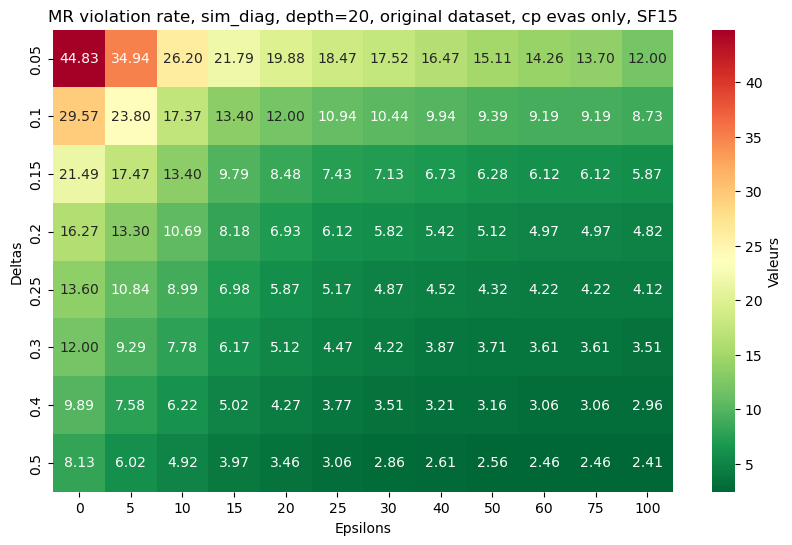

In [65]:
tests(split_mate_cp(evaluations50000_sim_diag_d_20)[0],2,20, ', original dataset, cp evas only, SF15')

In [66]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_20)[1],2,1,1),'%')

Mates failure rate :  38.53098071399261 %


### replace

#### depth = 10, entire dataset

Our grid (note, the MR was slightly edited).

0         5         10        15        20        25        30   \
0.05  2.476846  2.397460  2.281027  2.217518  2.196348  2.175179  2.132839   
0.10  1.810003  1.762371  1.661815  1.608891  1.598306  1.577137  1.555967   
0.15  1.566552  1.529505  1.450119  1.402487  1.391903  1.370733  1.349563   
0.20  1.450119  1.423657  1.354856  1.317809  1.307224  1.286055  1.264885   
0.25  1.370733  1.349563  1.286055  1.249008  1.238423  1.222546  1.201376   
0.30  1.338979  1.317809  1.254300  1.222546  1.211961  1.196084  1.174914   
0.40  1.275470  1.259592  1.196084  1.164329  1.159037  1.143160  1.127282   
0.50  1.222546  1.206668  1.153744  1.121990  1.116698  1.111405  1.095528   

           40        50        60        75        100  
0.05  2.106377  2.048161  1.995237  1.942313  1.894681  
0.10  1.540090  1.508336  1.487166  1.460704  1.444827  
0.15  1.338979  1.312517  1.296639  1.280762  1.270177  
0.20  1.259592  1.233130  1.217253  1.201376  1.196084  
0.25  1.196084  1.174914  1.159037  1.143160  1.137867  
0.30  1.169622  1.148452  1.137867  1.121990  1.116698  
0.40  1.121990  1.100820  1.095528  1.084943  1.079651  
0.50  1.090236  1.074358  1.069066  1.063773  1.058481

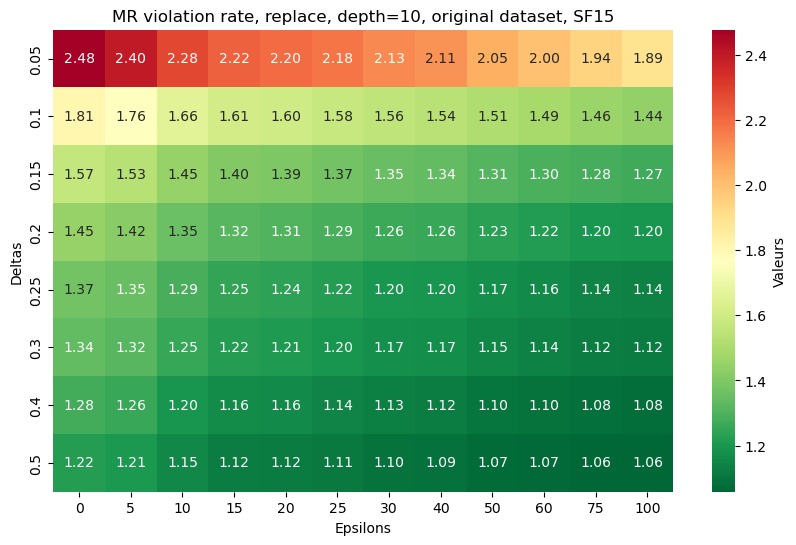

In [67]:
path = os.path.join('replace_d=10','evaluations50000_replace_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_10 = pickle.load(file)

tests(evaluations50000_replace_d_10,3,10, ', original dataset, SF15')

Using the original MR_better, not edited:

0         5         10        15        20        25        30   \
0.05  7.446414  7.367028  7.250595  7.187087  7.165917  7.144747  7.102408   
0.10  6.779571  6.731940  6.631384  6.578460  6.567875  6.546705  6.525536   
0.15  6.536121  6.499074  6.419688  6.372056  6.361471  6.340302  6.319132   
0.20  6.419688  6.393226  6.324424  6.287378  6.276793  6.255623  6.234454   
0.25  6.340302  6.319132  6.255623  6.218576  6.207992  6.192114  6.170945   
0.30  6.308547  6.287378  6.223869  6.192114  6.181530  6.165652  6.144483   
0.40  6.245038  6.229161  6.165652  6.133898  6.128605  6.112728  6.096851   
0.50  6.192114  6.176237  6.123313  6.091559  6.086266  6.080974  6.065097   

           40        50        60        75        100  
0.05  7.075946  7.017730  6.964806  6.911881  6.864250  
0.10  6.509659  6.477904  6.456735  6.430273  6.414395  
0.15  6.308547  6.282085  6.266208  6.250331  6.239746  
0.20  6.229161  6.202699  6.186822  6.170945  6.165652  
0.25  6.165652  6.144483  6.128605  6.112728  6.107436  
0.30  6.139190  6.118021  6.107436  6.091559  6.086266  
0.40  6.091559  6.070389  6.065097  6.054512  6.049219  
0.50  6.059804  6.043927  6.038635  6.033342  6.028050

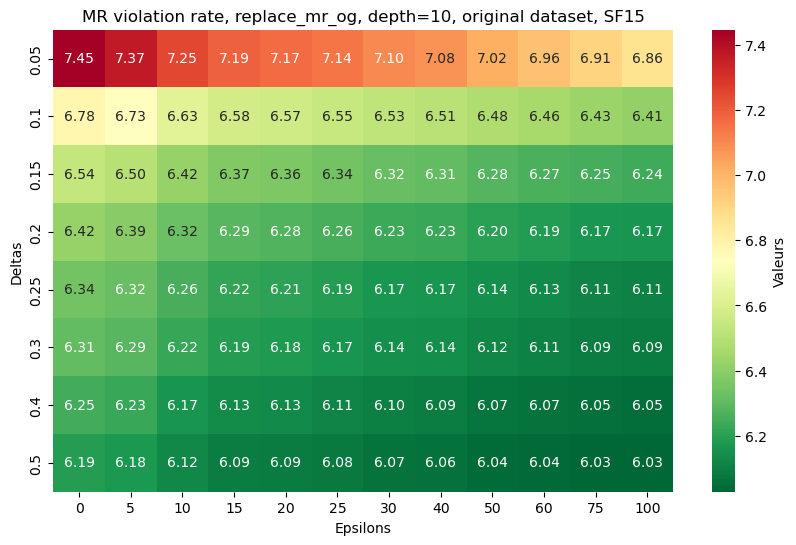

In [68]:
tests(evaluations50000_replace_d_10,6,10, ', original dataset, SF15')

The grid from the article.

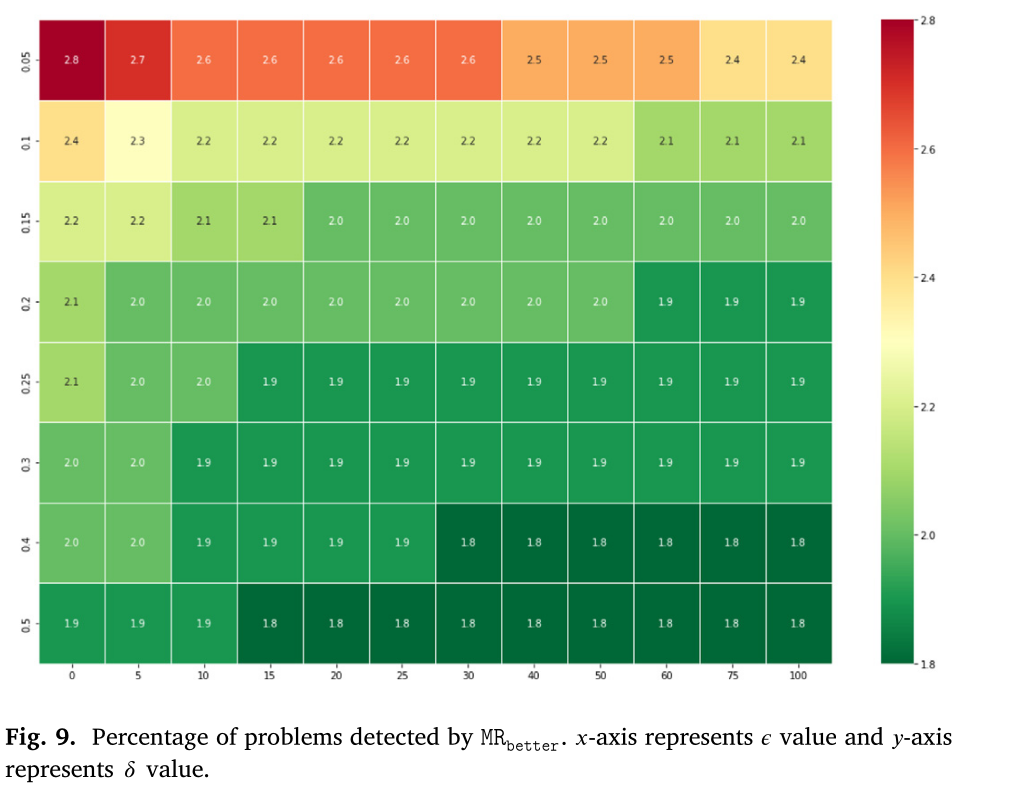

In [69]:
from IPython.display import display, Image

display(Image(filename='originalreplace10_am.png',width=900,height=900))

The grid from the article is closer to the grid with the corrected MR_better than the one with the MR_better that was in their GitHub. Two hypothesis: they actually used a correct MR_better and put somehow another one on GitHub, or they did not filter the positions which had no white bishops nor white rooks.

#### depth = 10, splitting

In [70]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_10)[1])/(len(split_mate_cp(evaluations50000_replace_d_10)[0])+len(split_mate_cp(evaluations50000_replace_d_10)[1])))

Mates proportion :  0.43926964805504104


##### Evaluations with a difference in centipawns

0         5         10        15        20        25        30   \
0.05  2.652194  2.510618  2.302973  2.189712  2.151958  2.114205  2.038697   
0.10  1.462954  1.378008  1.198679  1.104294  1.085418  1.047664  1.009910   
0.15  1.028787  0.962718  0.821142  0.736196  0.717319  0.679566  0.641812   
0.20  0.821142  0.773950  0.651251  0.585182  0.566305  0.528551  0.490798   
0.25  0.679566  0.641812  0.528551  0.462482  0.443605  0.415290  0.377537   
0.30  0.622935  0.585182  0.471921  0.415290  0.396413  0.368098  0.330345   
0.40  0.509674  0.481359  0.368098  0.311468  0.302029  0.273714  0.245399   
0.50  0.415290  0.386975  0.292591  0.235960  0.226522  0.217084  0.188768   

           40        50        60        75        100  
0.05  1.991505  1.887683  1.793299  1.698915  1.613969  
0.10  0.981595  0.924965  0.887211  0.840019  0.811704  
0.15  0.622935  0.575743  0.547428  0.519113  0.500236  
0.20  0.481359  0.434167  0.405852  0.377537  0.368098  
0.25  0.368098  0.330345  0.302029  0.273714  0.264276  
0.30  0.320906  0.283152  0.264276  0.235960  0.226522  
0.40  0.235960  0.198207  0.188768  0.169891  0.160453  
0.50  0.179330  0.151015  0.141576  0.132138  0.122699

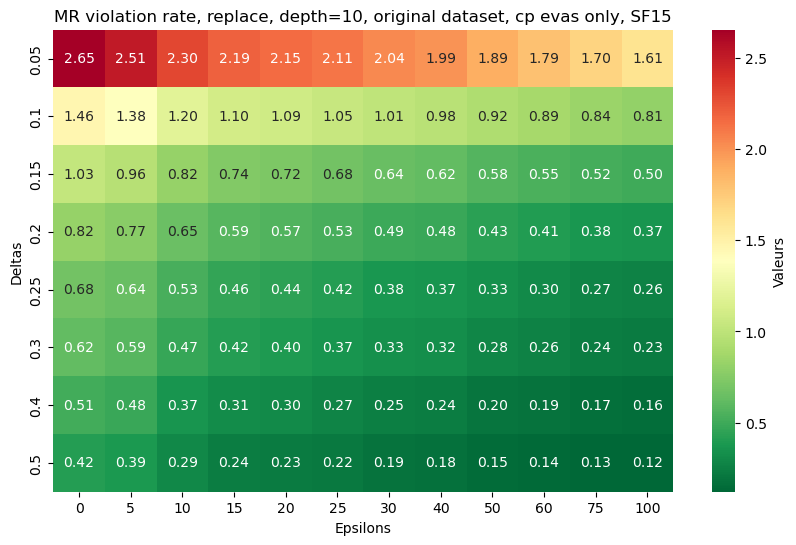

In [71]:
tests(split_mate_cp(evaluations50000_replace_d_10)[0],3,10, ', original dataset, cp evas only, SF15')

In [72]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_10)[1],3,1,1),'%')

Mates failure rate :  2.2530120481927725 %


#### depth = 10, real positions

0         5         10        15        20        25        30   \
0.05  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410   
0.10  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410   
0.15  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410   
0.20  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410   
0.25  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410  0.418410   
0.30  0.334728  0.334728  0.334728  0.334728  0.334728  0.334728  0.334728   
0.40  0.251046  0.251046  0.251046  0.251046  0.251046  0.251046  0.251046   
0.50  0.251046  0.251046  0.251046  0.251046  0.251046  0.251046  0.251046   

           40        50        60        75        100  
0.05  0.334728  0.334728  0.251046  0.251046  0.251046  
0.10  0.334728  0.334728  0.251046  0.251046  0.251046  
0.15  0.334728  0.334728  0.251046  0.251046  0.251046  
0.20  0.334728  0.334728  0.251046  0.251046  0.251046  
0.25  0.334728  0.334728  0.251046  0.251046  0.251046  
0.30  0.251046  0.251046  0.251046  0.251046  0.251046  
0.40  0.167364  0.167364  0.167364  0.167364  0.167364  
0.50  0.167364  0.167364  0.167364  0.167364  0.167364

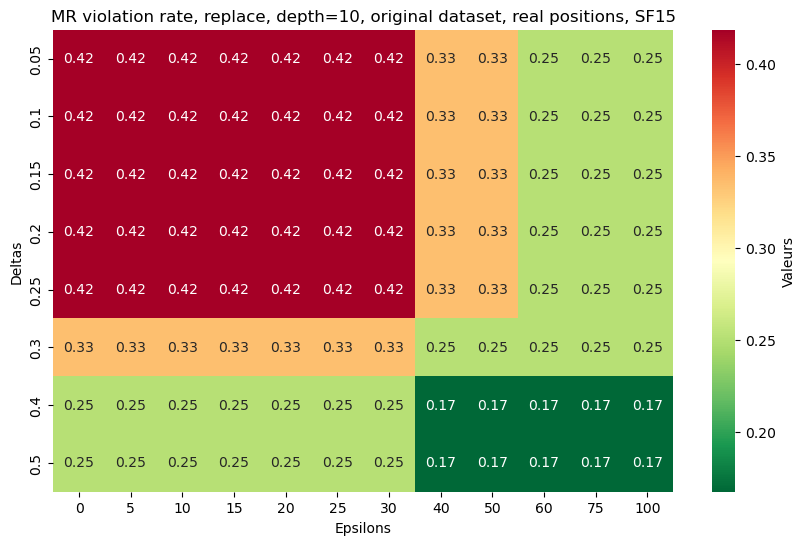

In [73]:
evaluations50000_replace_d_10_real = real_positions(evaluations50000_replace_d_10[17000:])
evaluations50000_replace_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_10_real,3,10, ', original dataset, real positions, SF15')

#### depth = 15, entire dataset

0         5         10        15        20        25        30   \
0.05  2.357991  2.267910  2.156634  2.108944  2.077151  2.040059  2.040059   
0.10  1.918186  1.854599  1.780415  1.743323  1.716829  1.690335  1.690335   
0.15  1.743323  1.690335  1.632047  1.594955  1.573760  1.552565  1.552565   
0.20  1.679737  1.632047  1.584358  1.547266  1.531369  1.515473  1.515473   
0.25  1.600254  1.552565  1.515473  1.478381  1.462484  1.457185  1.457185   
0.30  1.584358  1.536668  1.499576  1.467783  1.451886  1.446588  1.446588   
0.40  1.541967  1.494277  1.457185  1.425392  1.414794  1.409496  1.409496   
0.50  1.483680  1.435990  1.404197  1.372404  1.361806  1.356507  1.356507   

           40        50        60        75        100  
0.05  2.008266  1.992370  1.971174  1.902289  1.849301  
0.10  1.674438  1.669139  1.663841  1.642645  1.632047  
0.15  1.541967  1.541967  1.536668  1.526070  1.520772  
0.20  1.504875  1.504875  1.499576  1.488978  1.483680  
0.25  1.446588  1.446588  1.441289  1.441289  1.441289  
0.30  1.435990  1.435990  1.430691  1.430691  1.430691  
0.40  1.398898  1.398898  1.393599  1.393599  1.393599  
0.50  1.345909  1.345909  1.340610  1.340610  1.340610

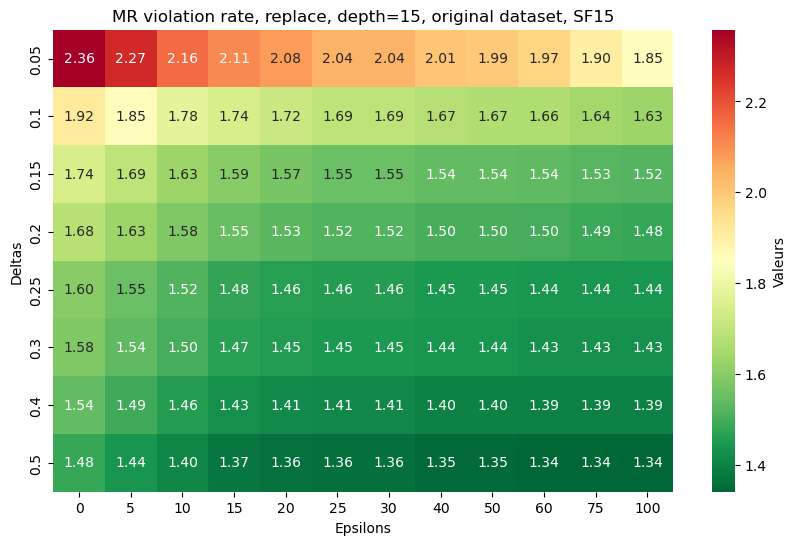

In [74]:
path = os.path.join('replace_d=15','evaluations50000_replace_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_15 = pickle.load(file)

tests(evaluations50000_replace_d_15,3,15, ', original dataset, SF15')

#### depth = 15, splitting

In [75]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_15)[1])/(len(split_mate_cp(evaluations50000_replace_d_15)[0])+len(split_mate_cp(evaluations50000_replace_d_15)[1])))

Mates proportion :  0.6127066553624417


##### Evaluations with a difference in centipawns

0         5         10        15        20        25        30   \
0.05  2.791079  2.558490  2.271173  2.148037  2.065946  1.970174  1.970174   
0.10  1.655493  1.491312  1.299767  1.203995  1.135586  1.067177  1.067177   
0.15  1.203995  1.067177  0.916678  0.820906  0.766179  0.711452  0.711452   
0.20  1.039814  0.916678  0.793542  0.697770  0.656725  0.615679  0.615679   
0.25  0.834587  0.711452  0.615679  0.519907  0.478862  0.465180  0.465180   
0.30  0.793542  0.670406  0.574634  0.492543  0.451498  0.437816  0.437816   
0.40  0.684088  0.560952  0.465180  0.383089  0.355726  0.342044  0.342044   
0.50  0.533589  0.410453  0.328362  0.246272  0.218908  0.205226  0.205226   

           40        50        60        75        100  
0.05  1.888083  1.847038  1.792311  1.614448  1.477630  
0.10  1.026132  1.012450  0.998769  0.944042  0.916678  
0.15  0.684088  0.684088  0.670406  0.643043  0.629361  
0.20  0.588316  0.588316  0.574634  0.547270  0.533589  
0.25  0.437816  0.437816  0.424135  0.424135  0.424135  
0.30  0.410453  0.410453  0.396771  0.396771  0.396771  
0.40  0.314681  0.314681  0.300999  0.300999  0.300999  
0.50  0.177863  0.177863  0.164181  0.164181  0.164181

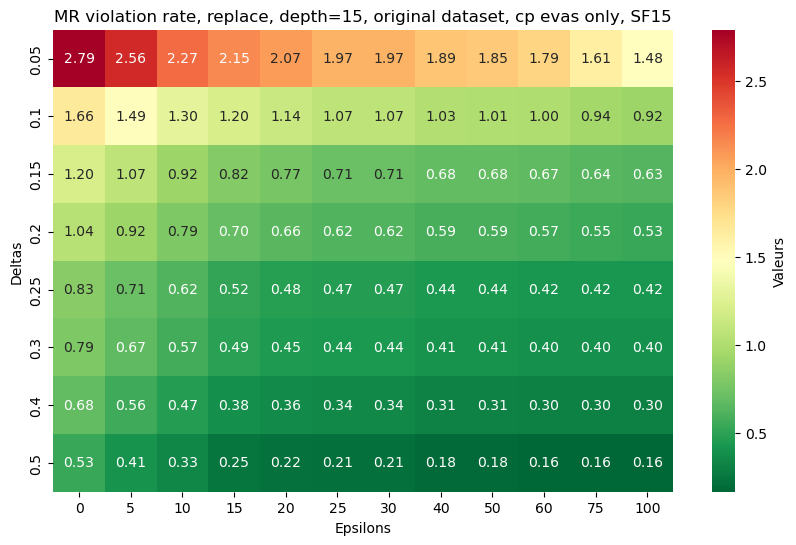

In [76]:
tests(split_mate_cp(evaluations50000_replace_d_15)[0],3,15, ', original dataset, cp evas only, SF15')

In [77]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_15)[1],3,1,1),'%')

Mates failure rate :  2.084234195278043 %


#### depth = 15, real positions

0         5         10        15        20        25        30   \
0.05  0.502092  0.502092  0.502092  0.418410  0.334728  0.334728  0.334728   
0.10  0.334728  0.334728  0.334728  0.251046  0.167364  0.167364  0.167364   
0.15  0.334728  0.334728  0.334728  0.251046  0.167364  0.167364  0.167364   
0.20  0.251046  0.251046  0.251046  0.167364  0.167364  0.167364  0.167364   
0.25  0.251046  0.251046  0.251046  0.167364  0.167364  0.167364  0.167364   
0.30  0.251046  0.251046  0.251046  0.167364  0.167364  0.167364  0.167364   
0.40  0.251046  0.251046  0.251046  0.167364  0.167364  0.167364  0.167364   
0.50  0.251046  0.251046  0.251046  0.167364  0.167364  0.167364  0.167364   

           40        50        60        75        100  
0.05  0.251046  0.167364  0.167364  0.167364  0.167364  
0.10  0.167364  0.167364  0.167364  0.167364  0.167364  
0.15  0.167364  0.167364  0.167364  0.167364  0.167364  
0.20  0.167364  0.167364  0.167364  0.167364  0.167364  
0.25  0.167364  0.167364  0.167364  0.167364  0.167364  
0.30  0.167364  0.167364  0.167364  0.167364  0.167364  
0.40  0.167364  0.167364  0.167364  0.167364  0.167364  
0.50  0.167364  0.167364  0.167364  0.167364  0.167364

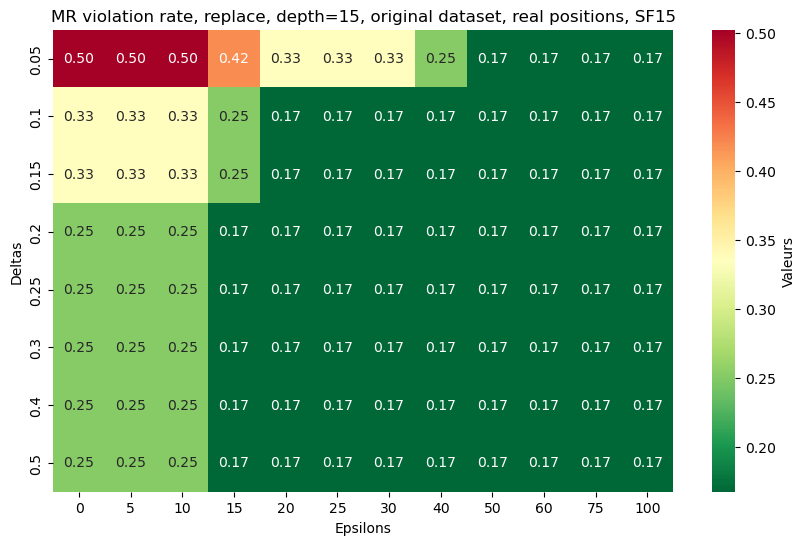

In [78]:
evaluations50000_replace_d_15_real = real_positions(evaluations50000_replace_d_15[17000:])
evaluations50000_replace_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_15_real,3,15, ', original dataset, real positions, SF15')

#### depth = 20, entire dataset <a id='replace15entire'>[(Link V16)](#replace16entire)</a>

0         5         10        15        20        25        30   \
0.05  2.060535  1.991139  1.916404  1.841670  1.814979  1.788288  1.777612   
0.10  1.745583  1.697539  1.654834  1.585437  1.569423  1.542732  1.532056   
0.15  1.601452  1.574761  1.537394  1.484012  1.467998  1.441307  1.430630   
0.20  1.553408  1.532056  1.500027  1.451983  1.441307  1.414616  1.403940   
0.25  1.494689  1.473336  1.441307  1.393263  1.387925  1.366572  1.355896   
0.30  1.462659  1.446645  1.414616  1.371911  1.366572  1.355896  1.345220   
0.40  1.430630  1.414616  1.382587  1.350558  1.345220  1.334543  1.323867   
0.50  1.398601  1.382587  1.350558  1.323867  1.318529  1.307852  1.297176   

           40        50        60        75        100  
0.05  1.761597  1.745583  1.734906  1.702877  1.692201  
0.10  1.526718  1.521379  1.521379  1.505365  1.494689  
0.15  1.425292  1.419954  1.419954  1.419954  1.414616  
0.20  1.398601  1.398601  1.398601  1.398601  1.393263  
0.25  1.350558  1.350558  1.350558  1.350558  1.345220  
0.30  1.339881  1.339881  1.339881  1.339881  1.334543  
0.40  1.318529  1.318529  1.318529  1.318529  1.313191  
0.50  1.291838  1.291838  1.291838  1.291838  1.291838

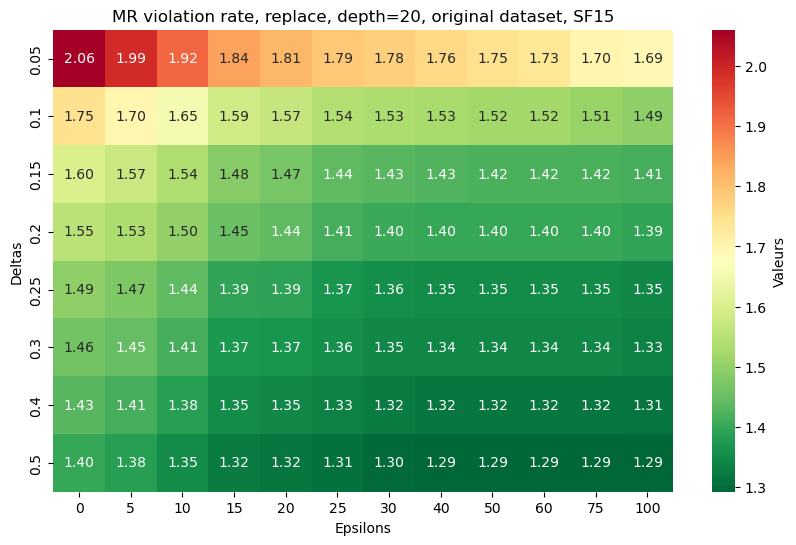

In [79]:
path = os.path.join('replace_d=20','evaluations50000_replace_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_20 = pickle.load(file)

tests(evaluations50000_replace_d_20,3,20, ', original dataset, SF15')

#### depth = 20, splitting <a id='replace15split'>[(Link V16)](#replace16split)</a>

In [80]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_20)[1])/(len(split_mate_cp(evaluations50000_replace_d_20)[0])+len(split_mate_cp(evaluations50000_replace_d_20)[1])))

Mates proportion :  0.7085891208028613


##### Evaluations with a difference in centipawns

0         5         10        15        20        25        30   \
0.05  2.857666  2.619527  2.363070  2.106613  2.015021  1.923429  1.886792   
0.10  1.776882  1.612017  1.465470  1.227331  1.172376  1.080784  1.044147   
0.15  1.282286  1.190694  1.062466  0.879282  0.824327  0.732735  0.696098   
0.20  1.117421  1.044147  0.934237  0.769372  0.732735  0.641143  0.604506   
0.25  0.915919  0.842645  0.732735  0.567870  0.549551  0.476278  0.439641   
0.30  0.806008  0.751053  0.641143  0.494596  0.476278  0.439641  0.403004   
0.40  0.696098  0.641143  0.531233  0.421323  0.403004  0.366367  0.329731   
0.50  0.586188  0.531233  0.421323  0.329731  0.311412  0.274776  0.238139   

           40        50        60        75        100  
0.05  1.831837  1.776882  1.740245  1.630335  1.593698  
0.10  1.025829  1.007511  1.007511  0.952555  0.915919  
0.15  0.677780  0.659461  0.659461  0.659461  0.641143  
0.20  0.586188  0.586188  0.586188  0.586188  0.567870  
0.25  0.421323  0.421323  0.421323  0.421323  0.403004  
0.30  0.384686  0.384686  0.384686  0.384686  0.366367  
0.40  0.311412  0.311412  0.311412  0.311412  0.293094  
0.50  0.219820  0.219820  0.219820  0.219820  0.219820

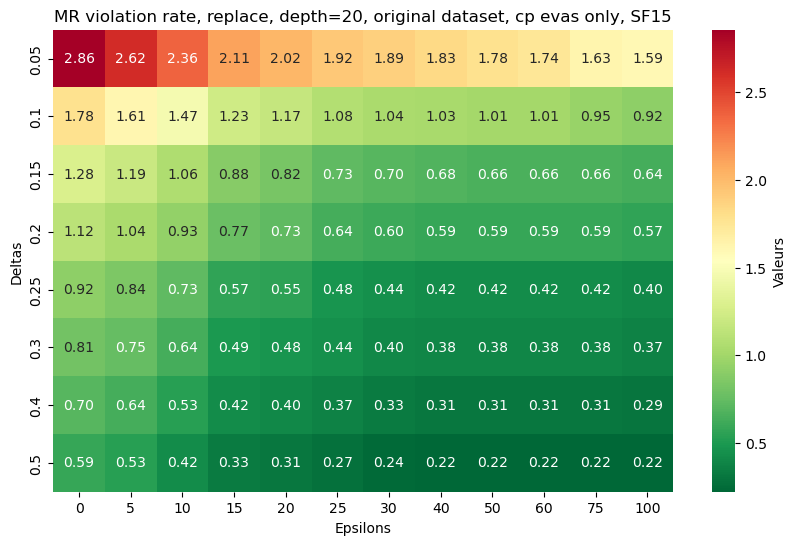

In [81]:
tests(split_mate_cp(evaluations50000_replace_d_20)[0],3,20, ', original dataset, cp evas only, SF15')

In [82]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_20)[1],3,1,1),'%')

Mates failure rate :  1.7327105620009036 %


#### depth = 20, real positions <a id='replace15real'>[(Link V16)](#replace16real)</a>

0         5         10        15        20        25        30   \
0.05  0.170068  0.170068  0.170068  0.170068  0.170068  0.085034  0.085034   
0.10  0.085034  0.085034  0.085034  0.085034  0.085034  0.000000  0.000000   
0.15  0.085034  0.085034  0.085034  0.085034  0.085034  0.000000  0.000000   
0.20  0.085034  0.085034  0.085034  0.085034  0.085034  0.000000  0.000000   
0.25  0.085034  0.085034  0.085034  0.085034  0.085034  0.000000  0.000000   
0.30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.40  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.50  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           40        50        60   75   100  
0.05  0.085034  0.085034  0.085034  0.0  0.0  
0.10  0.000000  0.000000  0.000000  0.0  0.0  
0.15  0.000000  0.000000  0.000000  0.0  0.0  
0.20  0.000000  0.000000  0.000000  0.0  0.0  
0.25  0.000000  0.000000  0.000000  0.0  0.0  
0.30  0.000000  0.000000  0.000000  0.0  0.0  
0.40  0.000000  0.000000  0.000000  0.0  0.0  
0.50  0.000000  0.000000  0.000000  0.0  0.0

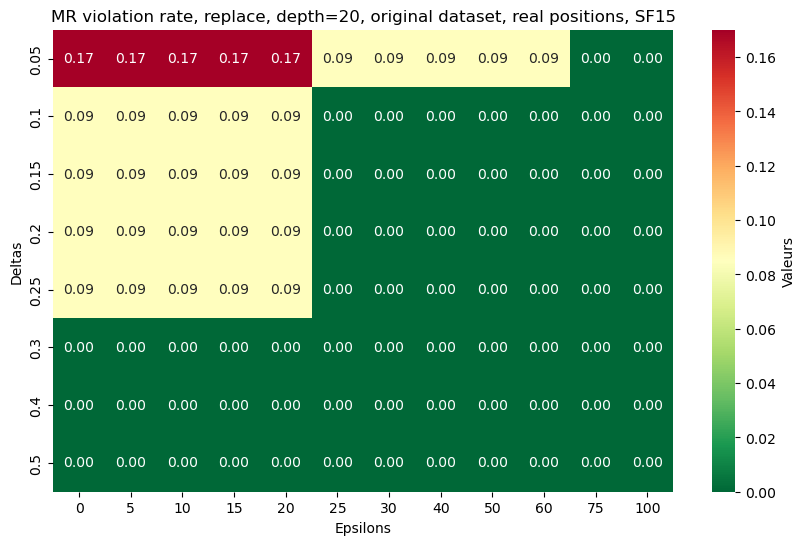

In [83]:
evaluations50000_replace_d_20_real = real_positions(evaluations50000_replace_d_20[17000:])
evaluations50000_replace_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_20_real,3,20, ', original dataset, real positions, SF15')

### best_move

In this part, we are using sim_axis then taking the evaluation after the best move (according to Stockfish) is played.

#### depth = 10, entire dataset

Our grid:

0          5          10         15         20         25   \
0.05  37.015573  34.216440  31.712990  30.159669  29.075498  28.235758   
0.10  25.992509  24.246008  22.562586  21.442933  20.701754  20.114331   
0.15  21.596688  20.256259  19.014390  18.237729  17.701557  17.212695   
0.20  19.203627  18.083974  17.157500  16.558250  16.136408  15.750049   
0.25  17.894737  16.873645  16.093042  15.592352  15.225705  14.918194   
0.30  17.062882  16.069387  15.375517  14.945791  14.626454  14.362310   
0.40  15.757934  14.898482  14.370195  14.035088  13.790656  13.597477   
0.50  14.965504  14.165188  13.723635  13.447664  13.226887  13.057363   

            30         40         50         60         75         100  
0.05  27.526119  26.370984  25.511532  24.797950  23.804455  22.243249  
0.10  19.582101  18.821210  18.359945  17.961758  17.468953  16.786911  
0.15  16.798738  16.199487  15.836783  15.556870  15.249359  14.780209  
0.20  15.426769  14.941849  14.642224  14.445102  14.184900  13.853735  
0.25  14.657993  14.267692  14.039030  13.885275  13.684211  13.416125  
0.30  14.145476  13.794599  13.609304  13.471319  13.305736  13.065247  
0.40  13.459491  13.163808  13.045535  12.946974  12.828701  12.655234  
0.50  12.935147  12.698600  12.600039  12.513306  12.402917  12.264932

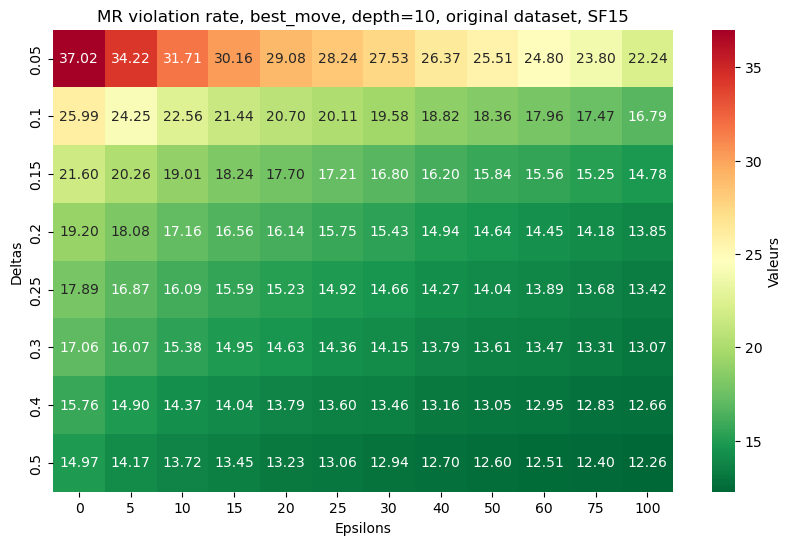

In [84]:
path = os.path.join('best_move_d=10','evaluations50000_best_move_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_10 = pickle.load(file)

tests(evaluations50000_best_move_d_10,4,10, ', original dataset, SF15')

The grid from their article.

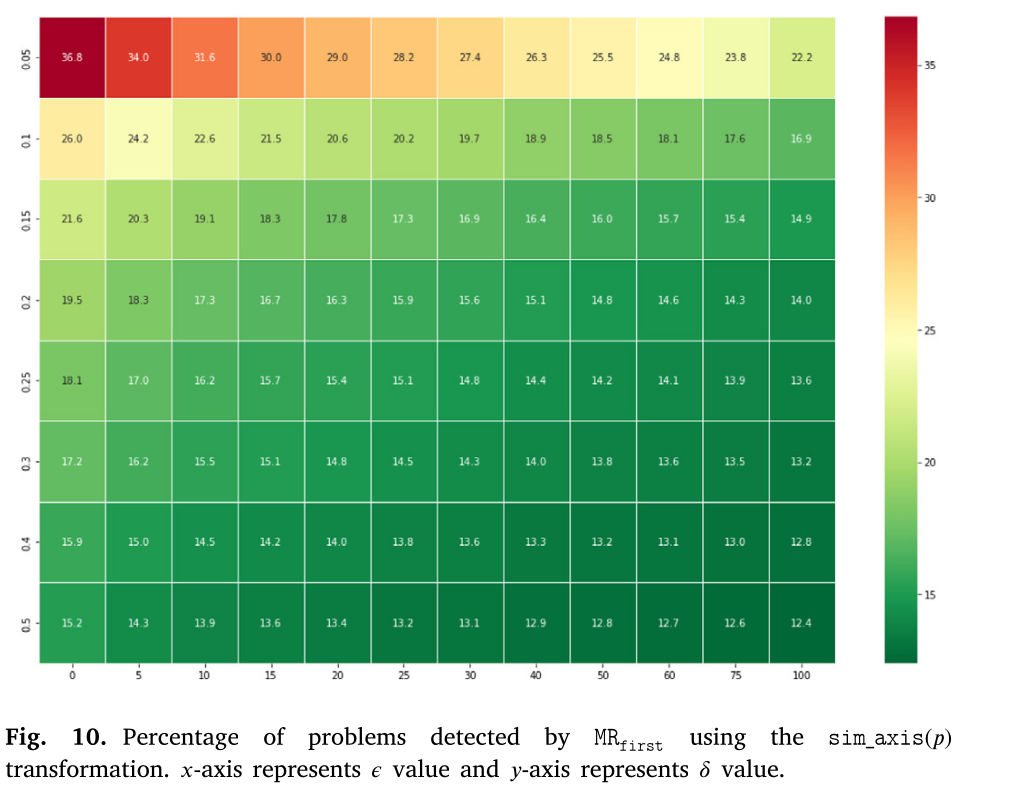

In [85]:
from IPython.display import display, Image

display(Image(filename='originalfirst10_am.png',width=900,height=900))

#### depth = 10, splitting

In [86]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_10)[1])/(len(split_mate_cp(evaluations50000_best_move_d_10)[0])+len(split_mate_cp(evaluations50000_best_move_d_10)[1])))

Mates proportion :  0.28685196136408436


0          5          10         15         20         25   \
0.05  38.094975  34.169938  30.659517  28.481398  26.961137  25.783625   
0.10  22.638067  20.189065  17.828515  16.258500  15.219194  14.395489   
0.15  16.474100  14.594505  12.853115  11.764056  11.012217  10.326718   
0.20  13.118470  11.548455  10.249323   9.409033   8.817513   8.275748   
0.25  11.283100   9.851291   8.756703   8.054619   7.540494   7.109293   
0.30  10.116645   8.723534   7.750567   7.147990   6.700205   6.329814   
0.40   8.286804   7.081652   6.340870   5.870971   5.528222   5.257339   
0.50   7.175632   6.053403   5.434242   5.047266   4.737686   4.499972   

            30         40         50         60         75         100  
0.05  24.788546  23.168777  21.963624  20.963016  19.569904  17.380729  
0.10  13.649179  12.582232  11.935430  11.377080  10.686052   9.729670  
0.15   9.746255   8.905965   8.397369   8.004865   7.573664   6.915805  
0.20   7.822434   7.142462   6.722317   6.445906   6.081044   5.616673  
0.25   6.744430   6.197136   5.876500   5.660899   5.378960   5.003041  
0.30   6.025762   5.533750   5.273923   5.080436   4.848250   4.511029  
0.40   5.063851   4.649234   4.483388   4.345182   4.179336   3.936094  
0.50   4.328597   3.996904   3.858699   3.737078   3.582288   3.388800

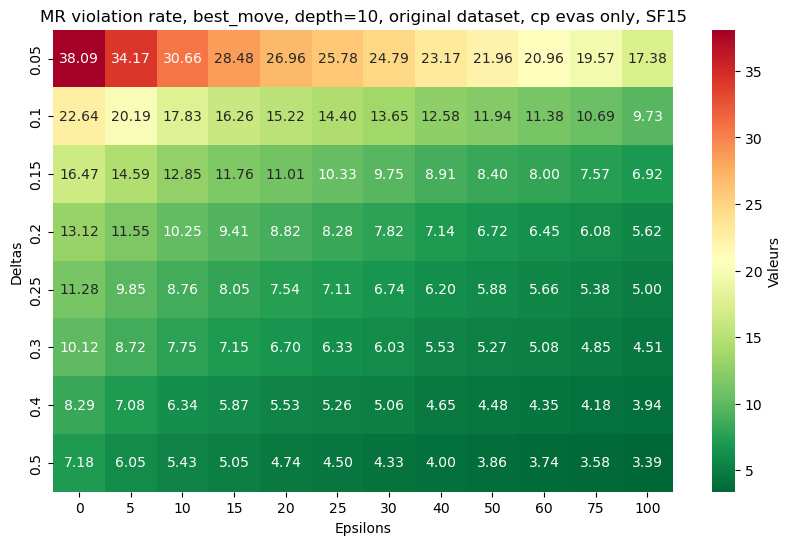

In [87]:
tests(split_mate_cp(evaluations50000_best_move_d_10)[0],4,10, ', original dataset, cp evas only, SF15')

In [88]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_10)[1],4,1,1),'%')

Mates failure rate :  34.33205057724025 %


#### depth = 10, real positions

0          5          10         15         20         25   \
0.05  65.174129  62.271973  55.140962  45.107794  37.230514  29.767828   
0.10  43.946932  42.205638  38.391376  32.255390  27.529022  22.553897   
0.15  31.840796  30.597015  27.611940  23.714760  21.310116  17.412935   
0.20  25.953566  24.875622  22.553897  19.071310  17.081260  13.847430   
0.25  21.061360  19.983416  17.827529  14.759536  13.101161  10.530680   
0.30  17.910448  16.832504  14.925373  12.271973  10.779436   8.540630   
0.40  13.515755  12.520730  10.945274   8.789386   7.628524   6.135987   
0.50  12.106136  11.111111   9.701493   7.628524   6.633499   5.389718   

            30         40         50        60        75        100  
0.05  24.046434  14.842454  10.033167  7.628524  5.638474  2.487562  
0.10  18.739635  11.857380   8.789386  6.882255  5.058043  2.404643  
0.15  14.427861   9.452736   7.213930  5.721393  4.311774  2.155887  
0.20  11.525705   7.462687   5.970149  5.058043  3.731343  2.072968  
0.25   8.955224   5.804312   4.643449  3.897181  3.067993  1.824212  
0.30   7.628524   4.892206   4.063018  3.316750  2.653400  1.492537  
0.40   5.472637   3.233831   2.819237  2.321725  1.741294  1.077944  
0.50   4.809287   2.819237   2.404643  1.907131  1.409619  0.912106

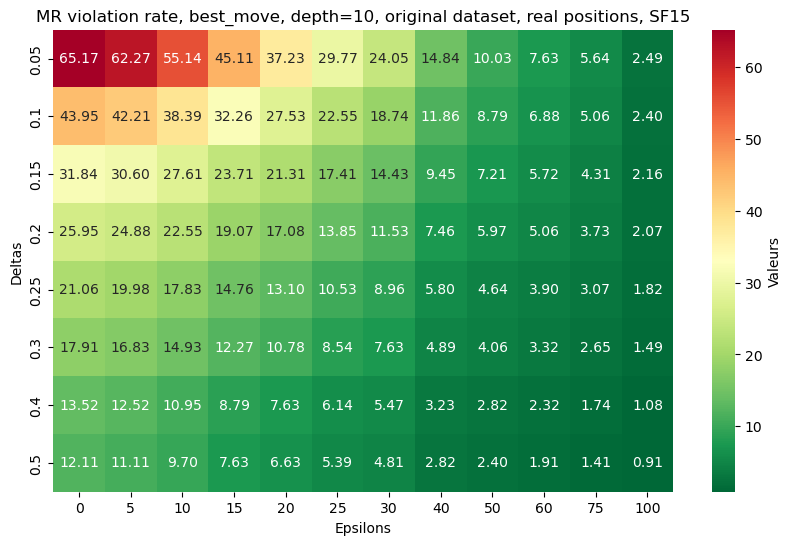

In [89]:
evaluations50000_best_move_d_10_real = real_positions(evaluations50000_best_move_d_10[24000:])
evaluations50000_best_move_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_10_real,4,10, ', original dataset, real positions, SF15')

#### depth = 15, entire dataset

0          5          10         15         20         25   \
0.05  38.023893  35.295509  32.878603  31.427670  30.524780  29.822970   
0.10  30.162047  28.474550  26.850136  25.789536  25.178409  24.677680   
0.15  26.582029  25.308520  24.173008  23.376572  22.931041  22.576194   
0.20  24.654024  23.636794  22.765446  22.166148  21.819185  21.519536   
0.25  23.711706  22.753617  22.043922  21.507708  21.208059  20.939952   
0.30  22.974412  22.067579  21.472223  20.999093  20.754643  20.522020   
0.40  21.803414  21.050349  20.569333  20.186886  20.005520  19.835982   
0.50  20.880811  20.198715  19.780783  19.465363  19.335252  19.216970   

            30         40         50         60         75         100  
0.05  29.361669  28.750542  28.320782  28.005362  27.599259  26.873793  
0.10  24.401687  24.038954  23.790561  23.632851  23.463313  23.230690  
0.15  22.375113  22.091235  21.917754  21.799472  21.669361  21.511651  
0.20  21.357884  21.121318  20.983322  20.900524  20.809841  20.711272  
0.25  20.798013  20.620589  20.498364  20.431337  20.372196  20.301226  
0.30  20.411623  20.261799  20.167173  20.104089  20.056776  20.005520  
0.40  19.761069  19.650672  19.587588  19.544218  19.504790  19.473248  
0.50  19.161771  19.067145  19.015889  18.972519  18.940977  18.917321

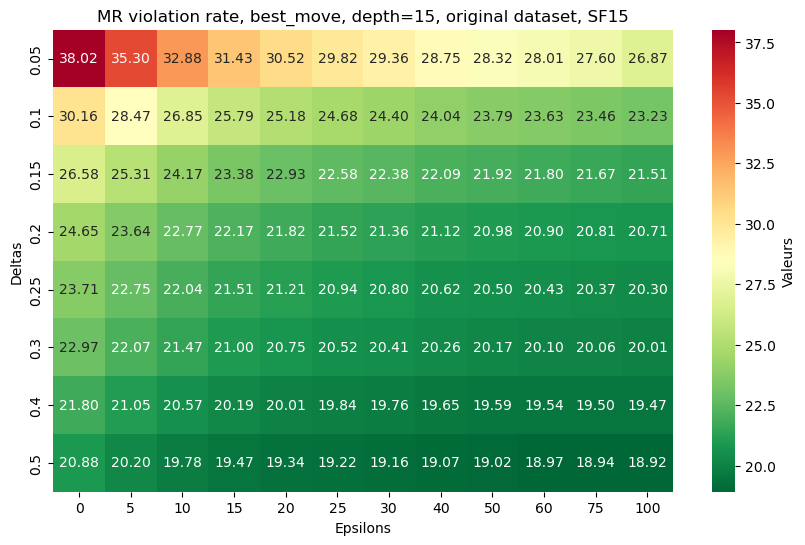

In [90]:
path = os.path.join('best_move_d=15','evaluations50000_best_move_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_15 = pickle.load(file)

tests(evaluations50000_best_move_d_15,4,15, ', original dataset, SF15')

#### depth = 15, splitting

In [91]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_15)[1])/(len(split_mate_cp(evaluations50000_best_move_d_15)[0])+len(split_mate_cp(evaluations50000_best_move_d_15)[1])))

Mates proportion :  0.43591057840160863


0          5          10         15         20         25   \
0.05  38.582512  33.745719  29.461103  26.888935  25.288320  24.044174   
0.10  24.645279  21.653736  18.774027  16.893828  15.810442  14.922765   
0.15  18.298735  16.041099  14.028098  12.616202  11.826379  11.197316   
0.20  14.880828  13.077515  11.532816  10.470399   9.855316   9.324107   
0.25  13.210317  11.511847  10.253722   9.303138   8.771930   8.296638   
0.30  11.903264  10.295659   9.240232   8.401482   7.968127   7.555742   
0.40   9.827357   8.492346   7.639617   6.961627   6.640106   6.339554   
0.50   8.191794   6.982596   6.241700   5.682533   5.451877   5.242189   

            30         40         50         60         75         100  
0.05  23.226393  22.143007  21.381142  20.821975  20.102048  18.815964  
0.10  14.433494  13.790452  13.350108  13.070525  12.769973  12.357587  
0.15  10.840847  10.337597  10.030055   9.820368   9.589711   9.310128  
0.20   9.037534   8.618159   8.373523   8.226742   8.065982   7.891242  
0.25   8.045013   7.730482   7.513804   7.394981   7.290138   7.164325  
0.30   7.360034   7.094429   6.926679   6.814846   6.730971   6.640106  
0.40   6.206752   6.011044   5.899210   5.822325   5.752429   5.696512  
0.50   5.144335   4.976585   4.885720   4.808835   4.752918   4.710981

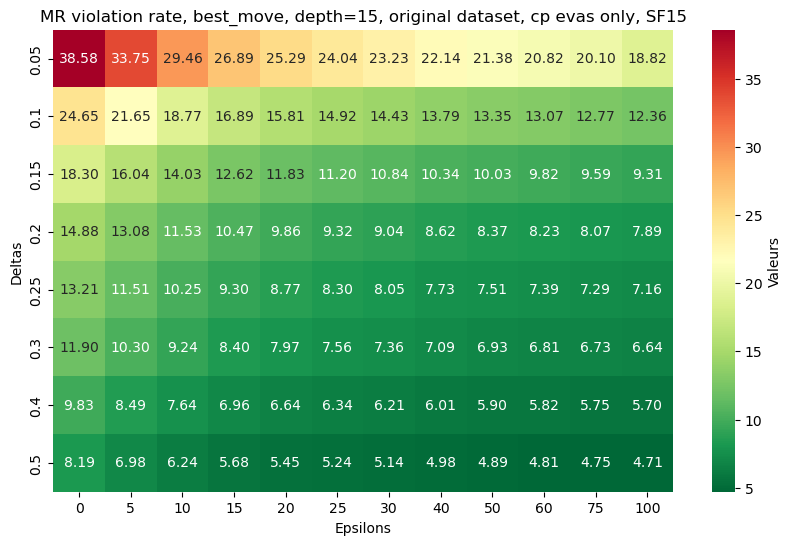

In [92]:
tests(split_mate_cp(evaluations50000_best_move_d_15)[0],4,15, ', original dataset, cp evas only, SF15')

In [93]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_15)[1],4,1,1),'%')

Mates failure rate :  37.30101302460203 %


#### depth = 15, real positions

0          5          10         15         20         25   \
0.05  56.301824  53.233831  44.444444  34.328358  25.538972  18.822554   
0.10  36.318408  34.411277  29.601990  23.880597  18.490879  13.764511   
0.15  24.461028  22.719735  19.817579  16.252073  12.686567   9.867330   
0.20  18.159204  16.500829  13.930348  11.111111   8.540630   6.384743   
0.25  14.925373  13.349917  11.028192   8.457711   6.467662   4.560531   
0.30  12.271973  10.945274   9.038143   6.633499   5.389718   3.648425   
0.40   9.535655   8.291874   6.633499   4.560531   3.731343   2.570481   
0.50   7.960199   6.882255   5.472637   3.648425   3.067993   2.404643   

            30         40        50        60        75        100  
0.05  15.008292  10.447761  7.877280  6.550580  4.726368  2.238806  
0.10  11.442786   7.960199  6.301824  5.472637  4.145937  2.155887  
0.15   8.457711   5.804312  4.809287  4.063018  2.902156  1.575456  
0.20   5.721393   3.565506  3.150912  2.736318  1.990050  1.160862  
0.25   3.980100   2.570481  2.155887  1.824212  1.326700  0.746269  
0.30   3.233831   2.072968  1.741294  1.409619  1.077944  0.580431  
0.40   2.321725   1.492537  1.243781  1.077944  0.746269  0.497512  
0.50   2.155887   1.326700  1.077944  0.912106  0.663350  0.414594

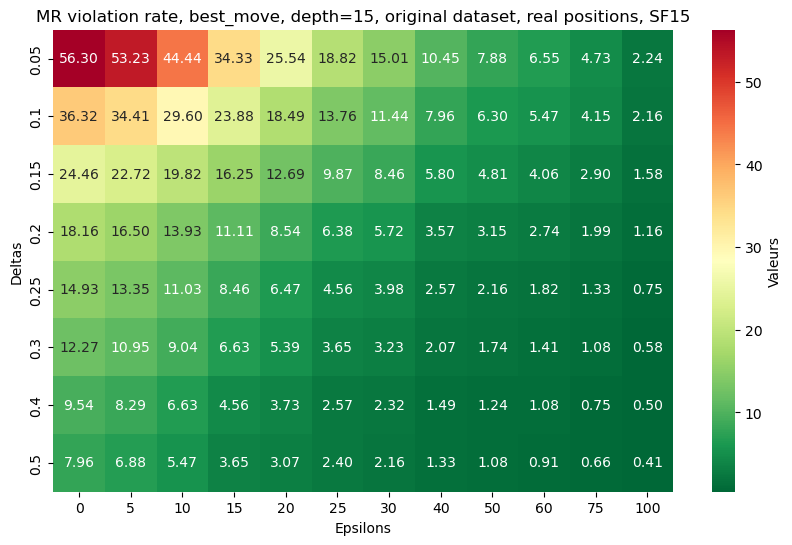

In [94]:
evaluations50000_best_move_d_15_real = real_positions(evaluations50000_best_move_d_15[24000:])
evaluations50000_best_move_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_15_real,4,15, ', original dataset, real positions, SF15')

#### depth = 20, entire dataset <a id='best15entire'>[(Link V16)](#best16entire)</a>

0          5          10         15         20         25   \
0.05  36.678652  34.446244  31.988621  30.546446  29.566557  29.045004   
0.10  29.898455  28.578766  27.002252  25.923584  25.204473  24.825161   
0.15  26.804694  25.888024  24.773796  23.912442  23.355328  23.058991   
0.20  25.014817  24.260145  23.477814  22.849579  22.391244  22.138370   
0.25  24.046782  23.367182  22.782409  22.241100  21.857837  21.652377   
0.30  23.386937  22.746849  22.241100  21.798570  21.490379  21.308625   
0.40  22.237149  21.687937  21.280967  20.956972  20.712000  20.577660   
0.50  21.344186  20.830535  20.463076  20.182544  20.008693  19.886206   

            30         40         50         60         75         100  
0.05  28.689399  28.223162  27.914971  27.630487  27.334150  26.970643  
0.10  24.588091  24.291754  24.161366  24.042831  23.975661  23.853175  
0.15  22.900944  22.687581  22.612509  22.533486  22.490023  22.426805  
0.20  22.027737  21.869691  21.810423  21.763009  21.735351  21.707693  
0.25  21.549646  21.415307  21.356039  21.312577  21.288870  21.277016  
0.30  21.213797  21.091311  21.047849  21.008337  20.988581  20.980679  
0.40  20.506539  20.411711  20.380102  20.352444  20.340590  20.332688  
0.50  19.822988  19.747916  19.716306  19.692599  19.680746  19.676795

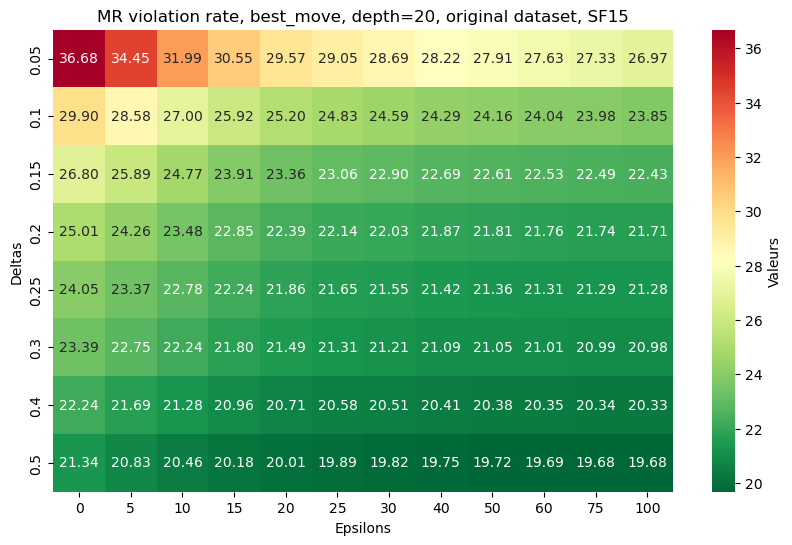

In [95]:
path = os.path.join('best_move_d=20','evaluations50000_best_move_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_20 = pickle.load(file)

tests(evaluations50000_best_move_d_20,4,20, ', original dataset, SF15')

#### depth = 20, splitting <a id='best15split'>[(Link V16)](#best16split)</a>

In [96]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_20)[1])/(len(split_mate_cp(evaluations50000_best_move_d_20)[0])+len(split_mate_cp(evaluations50000_best_move_d_20)[1])))

Mates proportion :  0.5246750167924453


0          5          10         15         20         25   \
0.05  41.579385  36.882793  31.712386  28.678304  26.616791  25.519534   
0.10  27.315046  24.538653  21.221945  18.952618  17.439734  16.641729   
0.15  20.806318  18.877805  16.533666  14.721530  13.549460  12.926018   
0.20  17.040732  15.453034  13.807149  12.485453  11.521197  10.989194   
0.25  15.004156  13.574397  12.344140  11.205320  10.399002   9.966750   
0.30  13.615960  12.269327  11.205320  10.274314   9.625935   9.243558   
0.40  11.197007  10.041563   9.185370   8.503741   7.988362   7.705736   
0.50   9.318371   8.237739   7.464672   6.874480   6.508728   6.251039   

            30         40         50         60         75         100  
0.05  24.771405  23.790524  23.142145  22.543641  21.920200  21.155445  
0.10  16.142976  15.519534  15.245220  14.995844  14.854530  14.596841  
0.15  12.593516  12.144638  11.986700  11.820449  11.729011  11.596010  
0.20  10.756442  10.423940  10.299252  10.199501  10.141313  10.083126  
0.25   9.750623   9.467997   9.343308   9.251870   9.201995   9.177057  
0.30   9.044057   8.786367   8.694929   8.611804   8.570241   8.553616  
0.40   7.556110   7.356608   7.290108   7.231920   7.206983   7.190357  
0.50   6.118038   5.960100   5.893599   5.843724   5.818786   5.810474

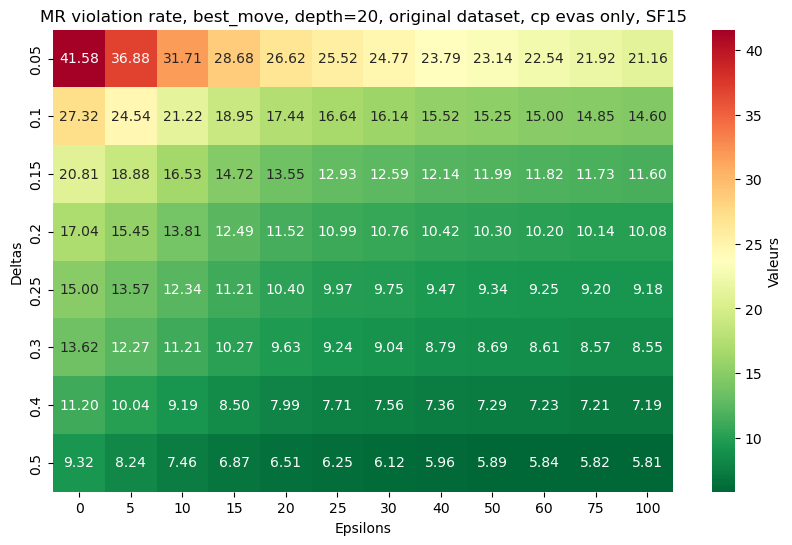

In [97]:
tests(split_mate_cp(evaluations50000_best_move_d_20)[0],4,20, ', original dataset, cp evas only, SF15')

In [98]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_20)[1],4,1,1),'%')

Mates failure rate :  32.23887340914226 %


#### depth = 20, real positions <a id='best15real'>[(Link V16)](#best16real)</a>

0          5          10         15         20         25   \
0.05  48.950462  46.431570  37.027708  27.959698  19.143577  14.441646   
0.10  27.120067  26.028547  21.914358  17.128463  11.670865   8.900084   
0.15  17.548279  16.624685  14.021830  10.915197   7.640638   5.793451   
0.20  12.342569  11.502939   9.655751   7.304786   5.037783   3.694374   
0.25   9.907641   9.151973   7.808564   5.877414   4.030227   3.106633   
0.30   8.480269   7.808564   6.633081   4.785894   3.442485   2.686818   
0.40   6.717045   6.129303   4.953820   3.526448   2.518892   1.847187   
0.50   5.625525   5.037783   4.030227   2.854744   2.183039   1.511335   

            30        40        50        60        75        100  
0.05  10.831234  7.892527  6.297229  5.121746  3.106633  2.183039  
0.10   6.549118  4.701931  3.778338  2.854744  2.434929  1.847187  
0.15   4.366079  3.274559  2.854744  2.183039  1.931150  1.511335  
0.20   2.770781  1.931150  1.763224  1.343409  1.259446  1.091520  
0.25   2.267003  1.427372  1.259446  0.839631  0.755668  0.671704  
0.30   2.015113  1.343409  1.175483  0.755668  0.671704  0.587741  
0.40   1.343409  0.839631  0.755668  0.503778  0.503778  0.419815  
0.50   1.091520  0.755668  0.671704  0.419815  0.419815  0.335852

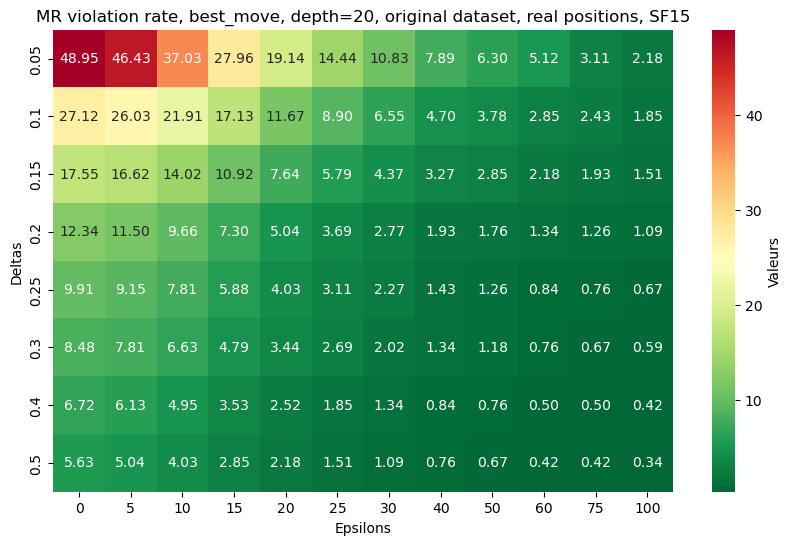

In [99]:
evaluations50000_best_move_d_20_real = real_positions(evaluations50000_best_move_d_20[22000:])
evaluations50000_best_move_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_20_real,4,20, ', original dataset, real positions, SF15')

### Analysis on biggest gaps

#### Additional function

Here is a function to plot evaluations by depth, until the MR is verified and the minimum depth (min_d) is reached. Will stop at max_d if can't verify MR before.

In [100]:
def plotevas(data1,data2,val,type):
    print('MR verified at depth = ', val)
    ind1 = 0
    ind2 = 0
    cp1 = []
    cp2 = []
    mate1 = []
    mate2 = []
    values1cp = []
    values1mate = []
    values2cp = []
    values2mate = []
    if type == 4:
        for data in data1:
            ind1+=1
            if data.get('Mate') == None:
                cp1.append(ind1)
                values1cp.append(data.get('Centipawn'))
            else:
                mate1.append(ind1)
                values1mate.append(data.get('Mate'))

        for data in data2:
            ind2+=1
            if data.get('Mate') == None:
                cp2.append(ind2)
                values2cp.append(data.get('Centipawn'))
            else:
                mate2.append(ind2)
                values2mate.append(data.get('Mate'))
    else:
        for data in data1:
            ind1+=1
            if data.get('type') == 'cp':
                cp1.append(ind1)
                values1cp.append(data.get('value'))
            else:
                values1mate.append(data.get('value'))
                mate1.append(ind1)
        for data in data2:
            ind2+=1
            if type == 0:
                if data.get('type') == 'cp':
                    cp2.append(ind2)
                    values2cp.append(data.get('value') * (-1))
                else:
                    mate2.append(ind2)
                    values2mate.append(data.get('value') * (-1))

            else:
                if data.get('type') == 'cp':
                    cp2.append(ind2)
                    values2cp.append(data.get('value'))
                else:
                    mate2.append(ind2)
                    values2mate.append(data.get('value'))


    plt.plot(cp1, values1cp, '-', color='#17d1d3')
    plt.plot(cp2, values2cp, '--',color='#405ee3')

    plt.grid(axis='y', color='#D3D3D3', linestyle='-', linewidth=0.5)


    plt.ylabel('Centipawn advantage', color='blue')
    plt.tick_params('y', colors='blue')



    plt.twinx()

    plt.plot(mate1, values1mate, '-', color='#f7766d')
    plt.plot(mate2, values2mate, '--', color='#df2c1f')
    
    plt.ylabel('Mate in', color='red')
    plt.tick_params('y', colors='red')
    
    plt.show()

We are using delta = 0.25 and epsilon = 25 for these tests.

#### Stockfish returning opposite evaluations

#### sim_mirror, sim_axis

No evidences of really large gaps.

REMINDER : with sim_mirror, since the mutation swap colors, the evaluation of the original position has to match with (-1)*the mutated evaluation.

In [101]:
p8mirror = 'r1b2rk1/p3n1pp/1pn1p3/q1ppPp2/3P4/P1PB1NQ1/2PB1PPP/R3K2R w'

show_pos([p8mirror],300)
print(evaluationdouble(p8mirror,sim_mirror(p8mirror),50000,20))
print(evaluationdouble(p8mirror,sim_axis(p8mirror),50000,20))


({'type': 'cp', 'value': -32}, {'type': 'cp', 'value': -63})
({'type': 'cp', 'value': -32}, {'type': 'cp', 'value': 40})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 28, 29, 30]


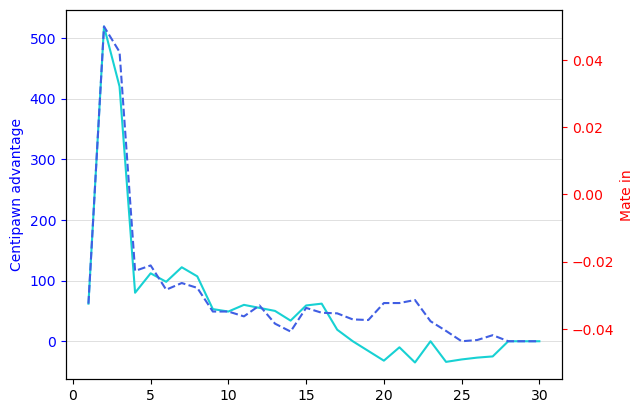

MR verified at depth =  [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 21, 23, 24, 25, 27, 30]


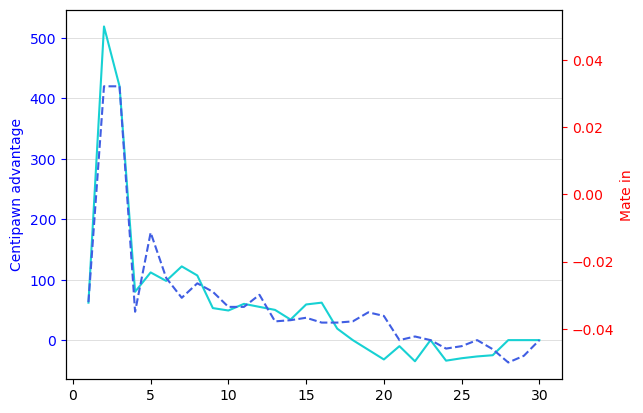

In [102]:
chemin = os.path.join('plotevas', 'p8mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot8mirror = pickle.load(fichier)

plotevas(plot8mirror[0],plot8mirror[1],plot8mirror[2], 0)

chemin = os.path.join('plotevas', 'p8axis.pkl')
with open(chemin, 'rb') as fichier:
    plot8axis = pickle.load(fichier)

plotevas(plot8axis[0],plot8axis[1],plot8axis[2], 1)

#### best_move

In [103]:
p1best = 'r2q1rk1/4bppp/3pb3/2n1pP2/1p2P1PP/1P3Q2/1BP1N1B1/2KR3R w'

show_pos([p1best],300)
print(evaluation(p1best,50000,20)[1],evaluation(sim_axis(p1best),50000,20)[1])

[{'Move': 'f5e6', 'Centipawn': 74, 'Mate': None}] [{'Move': 'c5d6', 'Centipawn': -12, 'Mate': None}]


MR verified at depth =  [2, 5, 6, 7, 10, 11, 12, 14, 15, 17, 21, 23, 24, 25, 26, 28, 29, 30]


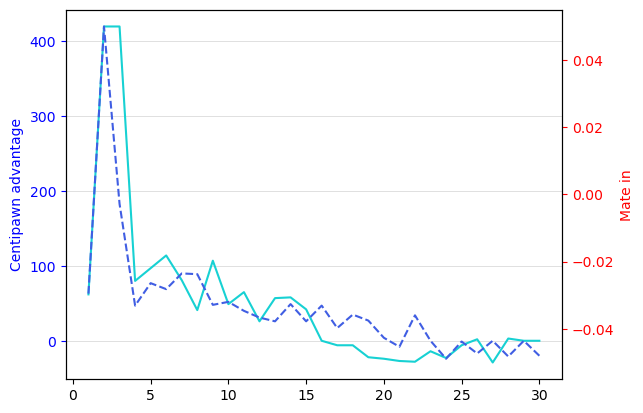

In [104]:
chemin = os.path.join('plotevas', 'p1best.pkl')
with open(chemin, 'rb') as fichier:
    plot1best = pickle.load(fichier)

plotevas(plot1best[0],plot1best[1],plot1best[2], 4)

#### Stockfish having troubles with draw positions at depth = 20

#### sim_mirror

In [105]:
p1mirror = '8/8/7k/8/4K3/4r3/2B4P/8 w'
p2mirror = '7b/8/kq6/8/8/1N2R3/K2P4/8 w'

show_pos([p1mirror,p2mirror],300)
print(evaluationdouble(p1mirror,sim_mirror(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_mirror(p2mirror),50000,20))

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': -402})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': 0})


It was in fact verified with a lower depth, but it is verified again with an higher depth. For the first one, it also gets verified at depth 23 with false values.

MR verified at depth =  [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 25, 28, 29, 30]


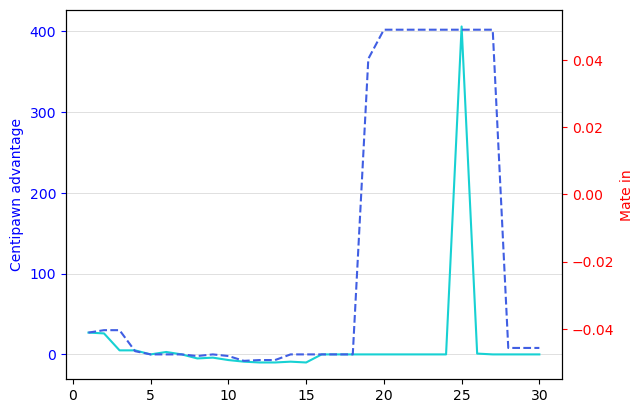

MR verified at depth =  [2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 29, 30]


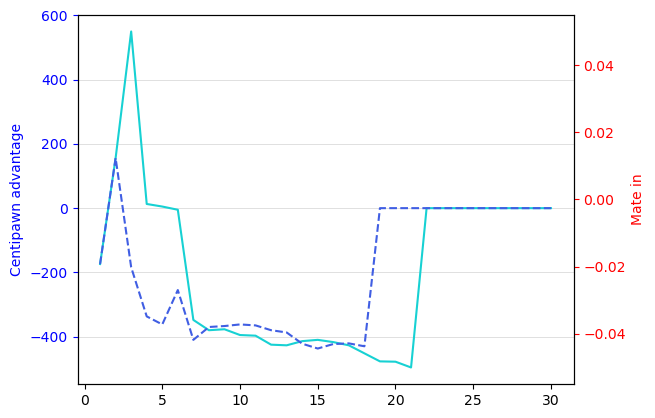

In [106]:
chemin = os.path.join('plotevas', 'p1mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot1mirror = pickle.load(fichier)

plotevas(plot1mirror[0],plot1mirror[1],plot1mirror[2], 0)

chemin = os.path.join('plotevas', 'p2mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot2mirror = pickle.load(fichier)


plotevas(plot2mirror[0],plot2mirror[1],plot2mirror[2], 0)

#### sim_axis, sim_diag

In [107]:
print(evaluationdouble(p1mirror,sim_axis(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_axis(p2mirror),50000,20))

print(evaluationdouble(p1mirror,sim_diag(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_diag(p2mirror),50000,20))

print(evaluation(p1mirror,50000,20)[1],evaluation(sim_axis(p1mirror),50000,20)[1])
print(evaluation(p2mirror,50000,20)[1],evaluation(sim_axis(p2mirror),50000,20)[1])

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': 0})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': -477})
({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': 0})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': -698})
[{'Move': 'e4e3', 'Centipawn': 0, 'Mate': None}] [{'Move': 'd4d3', 'Centipawn': 0, 'Mate': None}]
[{'Move': 'a2b1', 'Centipawn': -501, 'Mate': None}] [{'Move': 'h2g1', 'Centipawn': -498, 'Mate': None}]


Stockfish doesn't fail on the two previous position in sim_axis. Couldn't find other examples.

#### Stockfish showing gaps in evaluation on non-draw positions at depth = 20

#### sim_mirror

In [108]:
p3mirror = '8/K7/3N4/2PR2r1/n2k4/3p3N/4Pn2/6B1 b'
p4mirror = '8/2p1k3/3p3p/2PP1pp1/1P1K1P2/6P1/8/8 w'
show_pos([p3mirror,p4mirror],300)

print(evaluationdouble(p3mirror,sim_mirror(p3mirror),50000,20))
print(evaluationdouble(p4mirror,sim_mirror(p4mirror),50000,20))


({'type': 'cp', 'value': -222}, {'type': 'cp', 'value': 2})
({'type': 'cp', 'value': -1}, {'type': 'cp', 'value': -277})


MR verified at depth =  [2, 3, 4, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30]


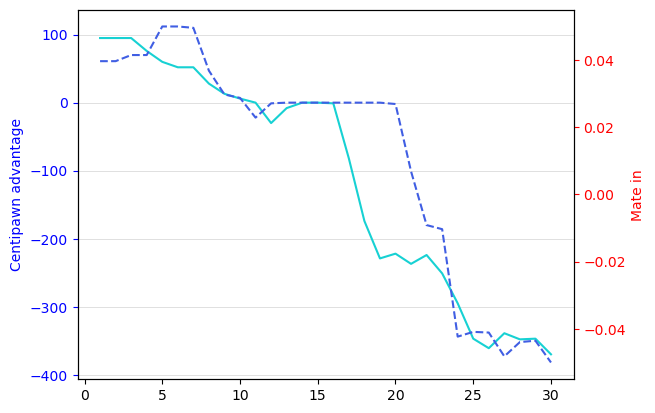

MR verified at depth =  [2, 3, 4, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30]


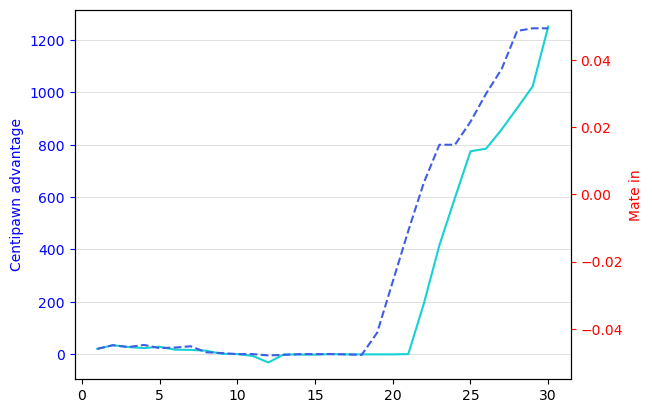

In [109]:
chemin = os.path.join('plotevas', 'p3mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot3mirror = pickle.load(fichier)

plotevas(plot3mirror[0],plot3mirror[1],plot3mirror[2], 0)

chemin = os.path.join('plotevas', 'p4mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot4mirror = pickle.load(fichier)

plotevas(plot4mirror[0],plot4mirror[1],plot3mirror[2], 0)

Stockfish shows a similar behaviour with the second position when using sim_axis.

#### sim_axis

In [110]:
p3axis = '1K6/3R2kr/8/8/8/BQ5r/2b1r3/5n2 b'
p2axis = 'rn1qr1k1/1p2bppp/p3p3/3pP3/P2P1B2/2RB1Q1P/1P3PP1/R5K1 w'
show_pos([p3axis,p2axis],300)

print(evaluationdouble(p3axis,sim_axis(p3axis),50000,20))
print(evaluationdouble(p2axis,sim_axis(p2axis),50000,20))

({'type': 'cp', 'value': 286}, {'type': 'cp', 'value': 48})
({'type': 'cp', 'value': 129}, {'type': 'cp', 'value': 344})


MR verified at depth =  [2, 4, 7, 9, 10, 11, 12, 13, 14, 15, 23, 28, 29, 30]


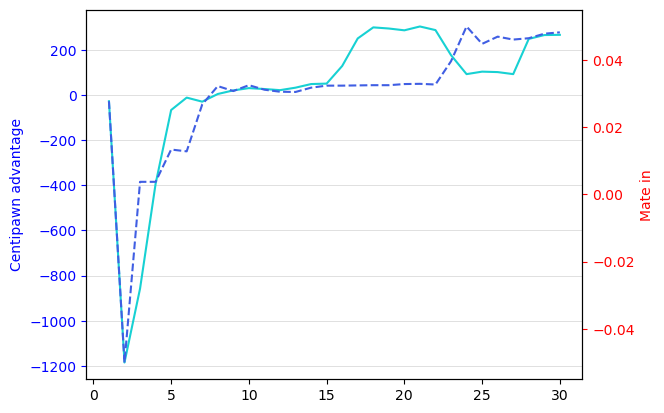

MR verified at depth =  [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25, 26, 27, 28, 29, 30]


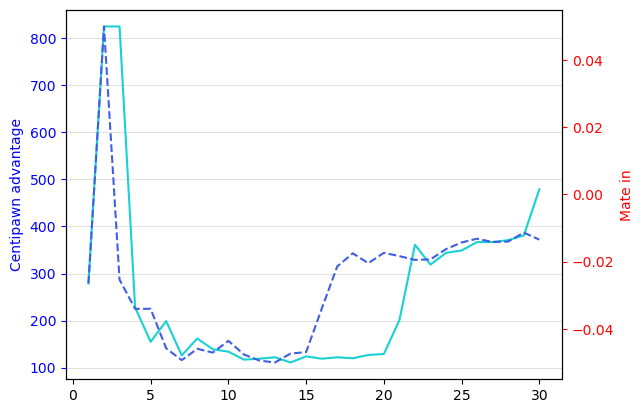

In [111]:
chemin = os.path.join('plotevas', 'p3axis.pkl')
with open(chemin, 'rb') as fichier:
    plot3axis = pickle.load(fichier)

plotevas(plot3axis[0],plot3axis[1],plot3axis[2], 1)

chemin = os.path.join('plotevas', 'p2axis.pkl')
with open(chemin, 'rb') as fichier:
    plot2axis = pickle.load(fichier)

plotevas(plot2axis[0],plot2axis[1],plot2axis[2], 1)

#### sim_diag

In [112]:
p3diag = 'N7/8/1n6/3B4/4r3/4k3/2K5/6r1 w '
p2diag = '8/8/8/n3N3/2Q1r3/5k2/1K6/8 b'
show_pos([p3diag,p2diag],300)

print(evaluationdouble(p3diag,sim_diag(p3diag),50000,20))
print(evaluationdouble(p2diag,sim_diag(p2diag),50000,20))

({'type': 'cp', 'value': -89}, {'type': 'cp', 'value': -246})
({'type': 'cp', 'value': 360}, {'type': 'cp', 'value': 145})


MR verified at depth =  [2, 9, 11, 12, 13, 14, 15, 16, 18, 37]


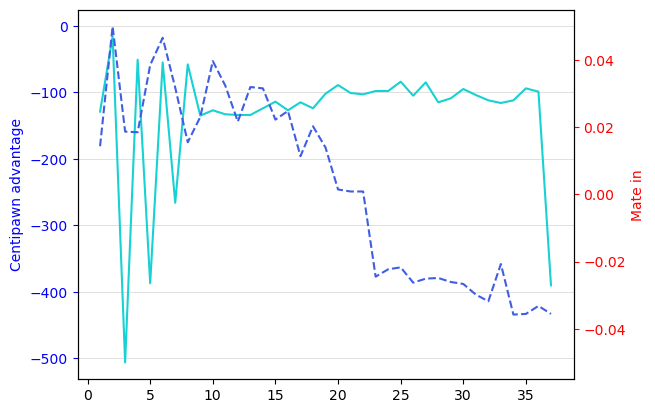

MR verified at depth =  [3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


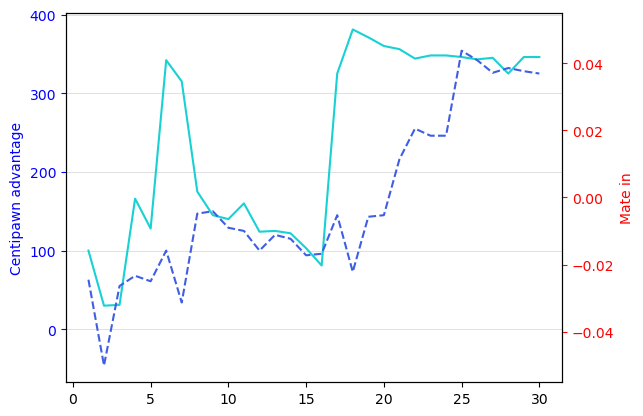

In [113]:
chemin = os.path.join('plotevas', 'p3diag.pkl')
with open(chemin, 'rb') as fichier:
    plot3diag = pickle.load(fichier)

plotevas(plot3diag[0],plot3diag[1],plot3diag[2], 2)

chemin = os.path.join('plotevas', 'p2diag.pkl')
with open(chemin, 'rb') as fichier:
    plot2diag = pickle.load(fichier)

plotevas(plot2diag[0],plot2diag[1],plot2diag[2], 2)

#### best_move

In [114]:
p2best = '8/1BK5/8/1pk5/8/8/5P2/8 b'
p3best = '4K3/1P6/4Rqk1/6B1/4N2N/2q3r1/b1np4/8 b'
show_pos([p2best,p3best],300)

print(evaluation(p2best,50000,20)[1],evaluation(sim_axis(p2best),50000,20)[1])
print(evaluation(p3best,50000,20)[1],evaluation(sim_axis(p3best),50000,20)[1])

[{'Move': 'b5b4', 'Centipawn': 0, 'Mate': None}] [{'Move': 'g5g4', 'Centipawn': 731, 'Mate': None}]
[{'Move': 'g6h5', 'Centipawn': -300, 'Mate': None}] [{'Move': 'b6a5', 'Centipawn': -43, 'Mate': None}]


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 22, 23, 24, 25]


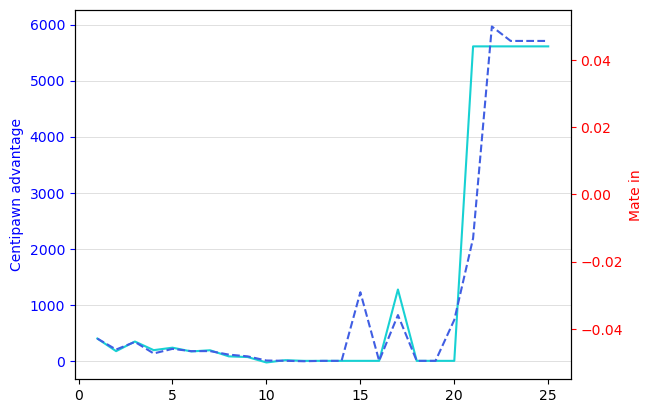

MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25]


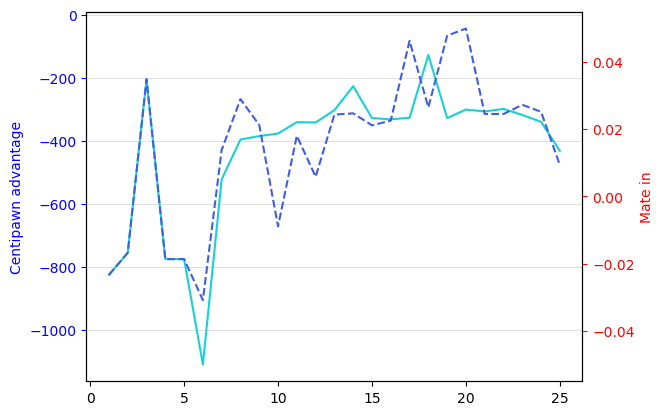

In [115]:
chemin = os.path.join('plotevas', 'p2best.pkl')
with open(chemin, 'rb') as fichier:
    plot2best = pickle.load(fichier)

plotevas(plot2best[0],plot2best[1],plot2best[2], 4)

chemin = os.path.join('plotevas', 'p3best.pkl')
with open(chemin, 'rb') as fichier:
    plot3best = pickle.load(fichier)

plotevas(plot3best[0],plot3best[1],plot3best[2], 4)

#### Stockfish fails to get the same mate value at depth = 20 on positions

#### sim_mirror

In [116]:
p5mirror = '3b4/6k1/8/8/4N3/8/q7/2K1Rn2 w'
show_pos([p5mirror],300)
print(evaluationdouble(p5mirror,sim_mirror(p5mirror),50000,20))

({'type': 'mate', 'value': -25}, {'type': 'mate', 'value': 32})


MR verified at depth =  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 24, 26, 27, 32]


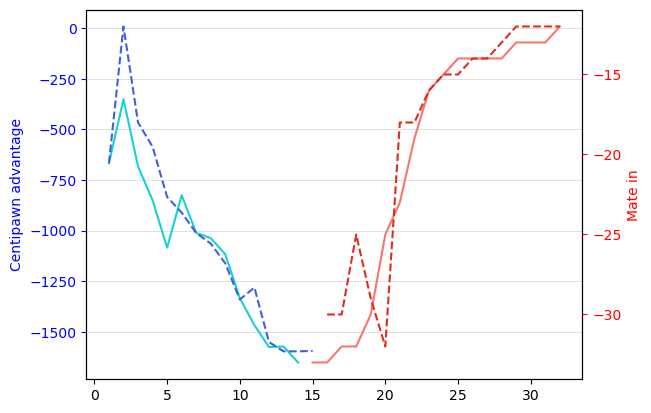

In [117]:
chemin = os.path.join('plotevas', 'p5mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot5mirror = pickle.load(fichier)

plotevas(plot5mirror[0],plot5mirror[1],plot5mirror[2], 0)

#### sim_axis

In [118]:
p4axis = '3N4/8/B3k3/1RK2B2/8/8/4P2r/6B1 b'
show_pos([p4axis],300)
print(evaluationdouble(p4axis,sim_axis(p4axis),50000,20))

({'type': 'mate', 'value': 11}, {'type': 'mate', 'value': 17})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 24, 25, 26, 27, 28, 29, 30]


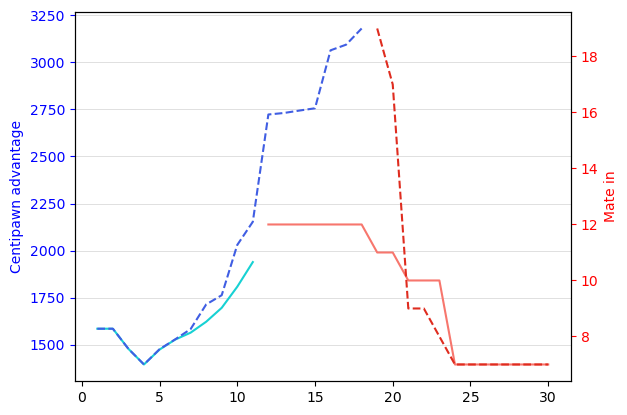

In [119]:
chemin = os.path.join('plotevas', 'p4axis.pkl')
with open(chemin, 'rb') as fichier:
    plot4axis = pickle.load(fichier)

plotevas(plot4axis[0],plot4axis[1],plot4axis[2], 1)

#### sim_diag

In [120]:
p4diag = '8/1nK5/6k1/8/6n1/8/8/4B1Qn b'
show_pos([p4diag],300)
print(evaluationdouble(p4diag,sim_diag(p4diag),50000,20))

({'type': 'cp', 'value': 15265}, {'type': 'mate', 'value': 40})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30]


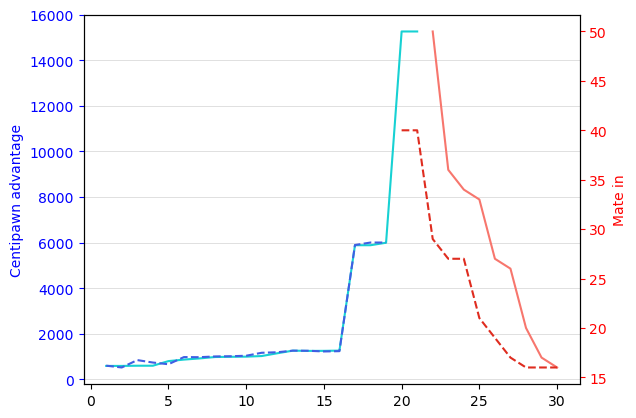

In [121]:
chemin = os.path.join('plotevas', 'p4diag.pkl')
with open(chemin, 'rb') as fichier:
    plot4diag = pickle.load(fichier)

plotevas(plot4diag[0],plot4diag[1],plot4diag[2], 2)

#### best_move

In [122]:
p4best = '1n6/8/8/8/1K6/5pP1/3P1n2/2k5 w'
show_pos([p4best],300)

print(evaluation(p4best,50000,20)[1],evaluation(sim_axis(p4best),50000,20)[1])

[{'Move': 'd2d4', 'Centipawn': None, 'Mate': -56}] [{'Move': 'e2e4', 'Centipawn': None, 'Mate': -52}]


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 31]


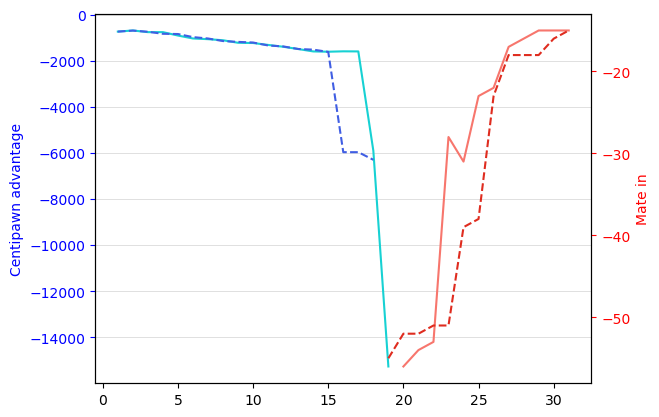

In [123]:
chemin = os.path.join('plotevas', 'p4best.pkl')
with open(chemin, 'rb') as fichier:
    plot4best = pickle.load(fichier)

plotevas(plot4best[0],plot4best[1],plot4best[2], 4)

#### Stockfish behaviour with near-mate positions

#### sim_mirror

In [124]:
p6mirror = '8/1BK5/8/1pk5/8/8/5P2/8 b'
p7mirror = '3K4/8/7N/6n1/8/3k4/3p4/8 w'
show_pos([p6mirror,p7mirror],300)
print(evaluationdouble(p6mirror,sim_mirror(p6mirror),50000,20))
print(evaluationdouble(p7mirror,sim_mirror(p7mirror),50000,20))

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': -1293})
({'type': 'cp', 'value': -15265}, {'type': 'cp', 'value': 5964})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 21, 23, 24, 26, 35]


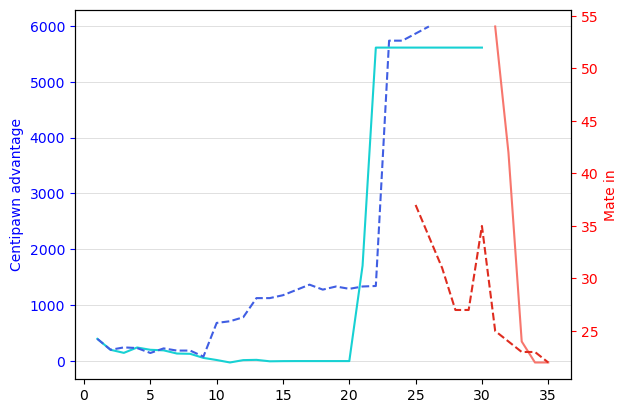

MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 27, 29, 49]


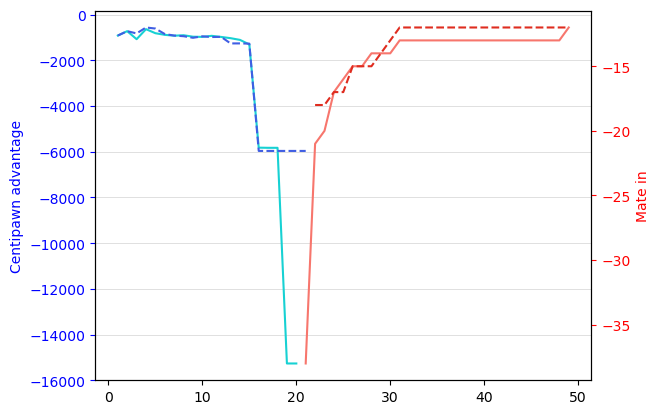

In [125]:
chemin = os.path.join('plotevas', 'p6mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot6mirror = pickle.load(fichier)

plotevas(plot6mirror[0],plot6mirror[1],plot6mirror[2], 0)

chemin = os.path.join('plotevas', 'p7mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot7mirror = pickle.load(fichier)

plotevas(plot7mirror[0],plot7mirror[1],plot7mirror[2], 0)

#### sim_axis

In [126]:
p5axis = '3RR3/6k1/K7/8/8/7r/8/8 b'
show_pos([p5axis],300)
print(evaluationdouble(p5axis,sim_axis(p5axis),50000,20))

({'type': 'cp', 'value': 740}, {'type': 'cp', 'value': 5480})


MR verified at depth =  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 27, 28, 31, 40]


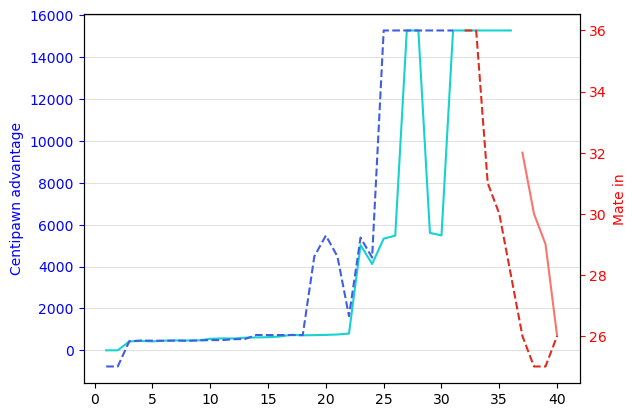

In [127]:
chemin = os.path.join('plotevas', 'p5axis.pkl')
with open(chemin, 'rb') as fichier:
    plot5axis = pickle.load(fichier)

plotevas(plot5axis[0],plot5axis[1],plot5axis[2], 1)

It eventually converges at a certain point.

#### sim_diag

In [128]:
p5diag = '3r4/8/8/R2K4/8/8/2N3r1/5k2 w'
show_pos([p5diag],300)
print(evaluationdouble(p5diag,sim_diag(p5diag),50000,20))

({'type': 'cp', 'value': -727}, {'type': 'cp', 'value': -5502})


MR verified at depth =  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 31, 53]


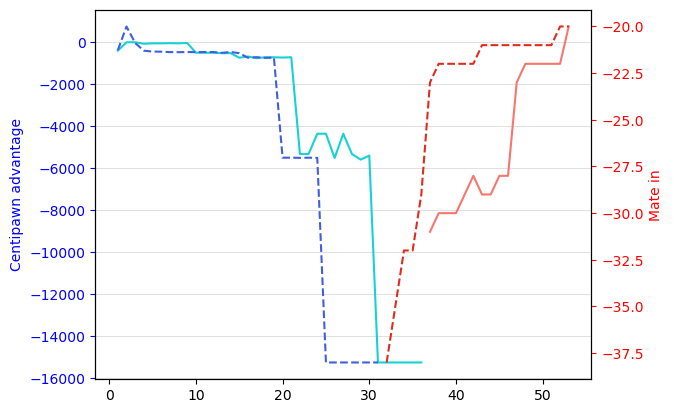

In [129]:
chemin = os.path.join('plotevas', 'p5diag.pkl')
with open(chemin, 'rb') as fichier:
    plot5diag = pickle.load(fichier)

plotevas(plot5diag[0],plot5diag[1],plot5diag[2], 2)

#### best_move

In [130]:
p5best = 'q1B1R3/2k4R/8/pP6/2B5/r4q2/1R1B4/1K2R2q b'
show_pos([p5best,sim_axis(p5best)],300)
print(evaluation(p5best,50000,20)[1],evaluation(sim_axis(p5best),50000,20)[1])

[{'Move': 'h1h7', 'Centipawn': -7925, 'Mate': None}] [{'Move': 'a1a7', 'Centipawn': -3229, 'Mate': None}]


MR verified at depth =  [2, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 30]


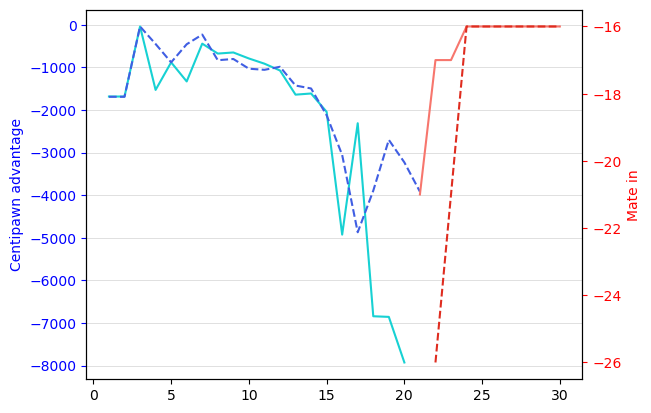

In [131]:
chemin = os.path.join('plotevas', 'p5best.pkl')
with open(chemin, 'rb') as fichier:
    plot5best = pickle.load(fichier)

plotevas(plot5best[0],plot5best[1],plot5best[2], 4)

## Tests on the Carlsen-Nepo game

The article used the MR_mirror on the 20 first positions of a Carlsen-Nepo game, and it was violated on 4 positions. Experience is reproduced below.

In [132]:
STOCKFISH16_LOCATION = "/home/mathieuacher/Downloads/stockfish-ubuntu-x86-64-avx2/stockfish/stockfish-ubuntu-x86-64-avx2"
def carlsen_nepo_analysis(depth,v):
    if v==15:
        stockfish = Stockfish(STOCKFISH15_LOCATION)
    if v==16:
        stockfish = Stockfish(STOCKFISH16_LOCATION)
    stockfish.set_elo_rating(50000)
    stockfish.set_depth(depth)
    moves1 = ['d2d4','g8f6','g1f3','d7d5','g2g3','e7e6','f1g2','f8e7','e1g1','e8g8','b2b3','c7c5','d4c5','e7c5','c2c4','d5c4','d1c2','d8e7','b1d2','b8c6']
    index = 0
    indexy = []
    pos1s = []
    pos2s =  []
    ev1s = []
    ev2s = []
    MR = []
    epsilons = []
    deltas = []
    for move in moves1:
        indexy.append(index)
        print(index, end='', flush=True)
        print('\r', end='', flush=True)
        stockfish.make_moves_from_current_position([move])
        pos1s.append(stockfish.get_fen_position())
        ev1s.append(stockfish.get_evaluation())
        index+=1
    stockfish.set_fen_position('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq - 0 1')
    print('   II', end='', flush=True)
    print('\r', end='', flush=True)
    moves2 = ['d7d5','g1f3','g8f6','d2d4','g7g6','e2e3','f8g7','f1e2','e8g8','e1g1','b7b6','c2c4','d5c4','e2c4','c7c5','d4c5','d8c7','d1e2','b8d7','b1c3']
    index = 0
    for move in moves2:
        print(index, end='', flush=True)
        print('\r', end='', flush=True)
        stockfish.make_moves_from_current_position([move])
        pos2s.append(stockfish.get_fen_position())
        ev2s.append(stockfish.get_evaluation())
        index+=1
    for k in range(len(pos1s)):
        MR.append(MR_mirror(ev1s[k],ev2s[k],0.25,25))
        epsilons.append(abs(ev1s[k].get('value')+ev2s[k].get('value')))
        if ev1s[k].get('value')==0 and ev2s[k].get('value')==0:
            deltas.append(0)
        else:
            deltas.append(round(abs(ev1s[k].get('value')+ev2s[k].get('value'))/(abs(ev1s[k].get('value'))+abs(ev2s[k].get('value'))),3))
    
    d = {'index': indexy, 'moves1': moves1, 'evaluation pos1': ev1s,
                 'moves2': moves2, 'evaluation pos2': ev2s, 'epsilons': epsilons, 'deltas': deltas, 'MR respected': MR}
    df = pd.DataFrame(data=d)
    print('Done!', end='', flush=True)
    print('\r', end='', flush=True)
    return df

In [133]:
carlsen_nepo_analysis(30,15)

KeyboardInterrupt: 

For some reasons we are getting only one error, and not 4 as the article got.

In [ ]:
carlsen_nepo_analysis(30,16)

Trying with Stockfish 16, and MR are not violated anymore.

## Tests with Stockfish 16

Since the original paper was using Stockfish 15, the previous tests were conducted on this version. The following tests have been conducted with the latest version, Stockfish 16. 

### sim_mirror

#### depth = 10, entire dataset <a id='mirror16entire10'>[(Link V15)](#mirror15entire10)</a>

In [ ]:
path = os.path.join('sim_mirror_d=10','evaluations50000_sim_mirror_d_10_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_10_v16 = pickle.load(file)


tests(evaluations50000_sim_mirror_d_10_v16,0,10, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 10.48% and 36.15%.  

#### depth = 20, entire dataset <a id='mirror16entire'>[(Link V15)](#mirror15entire)</a>

In [ ]:
path = os.path.join('sim_mirror_d=20','evaluations50000_sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_20_v16 = pickle.load(file)


tests(evaluations50000_sim_mirror_d_20_v16,0,20, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 19.32% and 36.31%.  

Similar behaviour: increasing depth isn't better on the entire dataset.

#### depth = 10, splitting <a id='mirror16split10'>[(Link V15)](#mirror15split10)</a>

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_10_v16)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_10_v16)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_10_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10_v16)[0],0,10, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.93% and 36.74%.

In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_10_v16)[1],0,1,1),'%')

Note : the mates failure rate with Stockfish 15 was ~34.6%.

#### depth = 20, splitting <a id='mirror16split'>[(Link V15)](#mirror15split)</a>

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[0],0,20, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 2.01% and 38.67%.

In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[1],0,1,1),'%')

Note : the mates failure rate with Stockfish 15 was ~34.3%.

#### depth = 10, real positions <a id='mirror16real10'>[(Link V15)](#mirror15real10)</a>

In [ ]:
evaluations50000_sim_mirror_d_10_v16_real = real_positions(evaluations50000_sim_mirror_d_10_v16[24000:])
evaluations50000_sim_mirror_d_10_v16_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_10_v16_real,0,10, ', original dataset, real positions, SF16')

Note : the failure rate with Stockfish 15 was comprised between 1.00% and 66.25%.

#### depth = 20, real positions <a id='mirror16real'>[(Link V15)](#mirror15real)</a>

In [ ]:
evaluations50000_sim_mirror_d_20_v16_real = real_positions(evaluations50000_sim_mirror_d_20_v16[24000:])
evaluations50000_sim_mirror_d_20_v16_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_20_v16_real,0,20, ', original dataset, real positions, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.25% and 50.67%.

### sim_axis

#### depth = 10, entire dataset <a id='axis16entire10'>[(Link V15)](#axis15entire10)</a>

In [ ]:
path = os.path.join('sim_axis_d=10','evaluations50000_sim_axis_d_10_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_10_v16 = pickle.load(file)


tests(evaluations50000_sim_axis_d_10_v16,1,10, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 10.42% and 35.90%.  

#### depth = 20, entire dataset <a id='axis16entire'>[(Link V15)](#axis15entire)</a>

In [ ]:
path = os.path.join('sim_axis_d=20','evaluations50000_sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_20_v16 = pickle.load(file)


tests(evaluations50000_sim_axis_d_20_v16,1,20, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 19.15% and 36.11%.  

#### depth = 10, splitting <a id='axis16split10'>[(Link V15)](#axis15split10)</a>


In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_10_v16)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_10_v16)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_10_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_sim_axis_d_10_v16)[0],1,10, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.96% and 36.54%.

#### depth = 20, splitting <a id='axis16split'>[(Link V15)](#axis15split)</a>


In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[0],1,20, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 2.05% and 38.59%.

In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[1],1,1,1),'%')

Note : the mates failure rate with Stockfish 15 was ~34.0%.


#### depth = 20, real positions <a id='axis16real'>[(Link V15)](#axis15real)</a>

In [ ]:
evaluations50000_sim_axis_d_20_v16_real = real_positions(evaluations50000_sim_axis_d_20_v16[24000:])
evaluations50000_sim_axis_d_20_v16_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_20_v16_real,1,20, ', original dataset, real positions, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.25% and 50.04%.  

### sim_diag

#### depth = 20, entire dataset <a id='diag16entire'>[(Link V15)](#diag15entire)</a>

In [ ]:
path = os.path.join('sim_diag_d=20','evaluations50000_sim_diag_d_20_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_20_v16 = pickle.load(file)

tests(evaluations50000_sim_diag_d_20_v16,2,20, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 22.28% and 41.36%.
#### depth = 20, splitting <a id='diag16split'>[(Link V15)](#diag15split)</a>

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_20_v16)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_20_v16)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_20_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_sim_diag_d_20_v16)[0],2,20, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 2.41% and 48.55%.

In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_20_v16)[1],2,1,1),'%')

Note : the mates failure rate with Stockfish 15 was ~38.5%.

### replace

#### depth = 20, entire dataset <a id='replace16entire'>[(Link V15)](#replace15entire)</a>

In [ ]:
path = os.path.join('replace_d=20','evaluations50000_replace_d_20_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_20_v16 = pickle.load(file)


tests(evaluations50000_replace_d_20_v16,3,20, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 1.29% and 2.06%.

#### depth = 20, splitting <a id='replace16split'>[(Link V15)](#replace15split)</a>

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_20_v16)[1])/(len(split_mate_cp(evaluations50000_replace_d_20_v16)[0])+len(split_mate_cp(evaluations50000_replace_d_20_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_replace_d_20_v16)[0],3,20, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.22% and 2.86%.

In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_20_v16)[1],3,1,1),'%')

#### depth = 20, real positions <a id='replace16real'>[(Link V15)](#replace15real)</a>

In [ ]:
evaluations50000_replace_d_20_v16_real = real_positions(evaluations50000_replace_d_20_v16[17000:])
evaluations50000_replace_d_20_v16_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_20_v16_real,3,20, ', original dataset, real positions, SF16')

### best_move

#### depth = 20, entire dataset <a id='best16entire'>[(Link V15)](#best15entire)</a>

In [ ]:
path = os.path.join('best_move_d=20','evaluations50000_best_move_d_20_v16.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_20_v16 = pickle.load(file)


tests(evaluations50000_best_move_d_20_v16,4,20, ', original dataset, SF16')

Note : the failure rate with Stockfish 15 was comprised between 19.68% and 36.68%.

#### depth = 20, splitting <a id='best16split'>[(Link V15)](#best15split)</a>

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_20_v16)[1])/(len(split_mate_cp(evaluations50000_best_move_d_20_v16)[0])+len(split_mate_cp(evaluations50000_best_move_d_20_v16)[1])))

##### Evaluations with a difference in centipawns

In [ ]:
tests(split_mate_cp(evaluations50000_best_move_d_20_v16)[0],4,20, ', original dataset, cp evas only, SF16')

Note : the failure rate with Stockfish 15 was comprised between 5.81% and 41.58%.


In [ ]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_20_v16)[1],4,1,1),'%')

#### depth = 20, real positions <a id='best16real'>[(Link V15)](#best15real)</a>

In [ ]:
evaluations50000_best_move_d_20_v16_real = real_positions(evaluations50000_best_move_d_20_v16[22000:])
evaluations50000_best_move_d_20_v16_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_20_v16_real,4,20, ', original dataset, real positions, SF16')

Note : the failure rate with Stockfish 15 was comprised between 0.34% and 48.95%.

### Differences in evaluations between SF15 and SF16

We'll also show grids with using MR_equi to check the variations between SF15 and SF16 on the both original and mutated positions, by merging two dataframes and keeping only the columns about the positions we want, using the functions below. 

In [ ]:
def merge(evas1,evas2):
    evas1 = evas1[['pos1','evaluation pos1']]
    evas2 = evas2[['pos1','evaluation pos1']]

    evas2 = evas2.rename(columns={'evaluation pos1': 'evaluation pos2'})

    evas1.reset_index(drop=True, inplace=True)
    evas2.reset_index(drop=True, inplace=True)

    merged_dataset = pd.merge(evas1, evas2, on='pos1', how='inner')
    merged_dataset.insert(0, 'index', range(1, len(merged_dataset) + 1))
    
    
    return merged_dataset


def merge2(evas1,evas2):
    evas1 = evas1[['pos2','evaluation pos2']]
    evas2 = evas2[['pos2','evaluation pos2']]

    evas1 = evas1.rename(columns={'pos2': 'pos1'})
    evas2 = evas2.rename(columns={'pos2': 'pos1'})
    
    evas1 = evas1.rename(columns={'evaluation pos2': 'evaluation pos1'})

    evas1.reset_index(drop=True, inplace=True)
    evas2.reset_index(drop=True, inplace=True)

    merged_dataset = pd.merge(evas1, evas2, on='pos1', how='inner')
    merged_dataset.insert(0, 'index', range(1, len(merged_dataset) + 1))
    
    
    return merged_dataset

#### Entire dataset

##### Original Positions

In [ ]:
tests(merge(evaluations50000_sim_mirror_d_20_v16,evaluations50000_sim_mirror_d_20),5,20, ', original dataset, original positions')

##### sim_mirror

In [ ]:
tests(merge2(evaluations50000_sim_mirror_d_20_v16,evaluations50000_sim_mirror_d_20),5,20, ', original dataset, sim_mirror positions')

##### sim_axis

In [ ]:
tests(merge2(evaluations50000_sim_axis_d_20_v16,evaluations50000_sim_axis_d_20),5,20, ', original dataset, sim_axis positions')

#### Splitting, positions with evaluations in centipawns only

##### Original Positions

In [ ]:
tests(merge(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[0],split_mate_cp(evaluations50000_sim_mirror_d_20)[0]),5,20, ', original dataset, original positions, cp evas only')

##### sim_mirror

In [ ]:
tests(merge2(split_mate_cp(evaluations50000_sim_mirror_d_20_v16)[0],split_mate_cp(evaluations50000_sim_mirror_d_20)[0]),5,20, ', original dataset, sim_mirror positions, cp evas only')

##### sim_axis

In [ ]:
tests(merge2(split_mate_cp(evaluations50000_sim_axis_d_20_v16)[0],split_mate_cp(evaluations50000_sim_axis_d_20)[0]),5,20, ', original dataset, sim_axis positions, cp evas only')

#### Real positions

##### Original Positions

In [ ]:
tests(merge(evaluations50000_sim_mirror_d_20_v16_real,evaluations50000_sim_mirror_d_20_real),5,20, ', original dataset, original & real positions')

##### sim_mirror

In [ ]:
tests(merge2(evaluations50000_sim_mirror_d_20_v16_real,evaluations50000_sim_mirror_d_20_real),5,20, ', original dataset, sim_mirror on real positions')

##### sim_axis

In [ ]:
tests(merge2(evaluations50000_sim_axis_d_20_v16_real,evaluations50000_sim_axis_d_20_real),5,20, ', original dataset, sim_axis on real positions')

### Conclusions with Stockfish 16

This newer version shows slightly better results.

## Tests with positions from lichess, Stockfish 15

We took games from the lichess database, and picked position at move 10, 20, 30 and 40. We then split the positions by elo, and also added Carlsen's games. We are using Stockfish 15 there.
Moreover, we'll also show grids for positions where castling isn't possible anymore ; the original paper decided to remove the ability to castle on every positions, but if we does that on real positions, even if they still look real, some may actually not be anymore.

### sim_mirror

#### Openings (move=10)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-10sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, low elos, move=10, SF15')

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-10sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, medium elos, move=10, SF15')

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, high elos, move=10, SF15')

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, high elos, move=10, no castling, SF15')

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, move=10, SF15')

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ', lichess positions, move=10, no castling, SF15')

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-10sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", Carlsen's games, move=10, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-10_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs01510 = pickle.load(file)

print('move = 10')
tests(evs01510,0,20, ", Carlsen's games, move=10, no castling, SF15")

#### Middlegames (move=20)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-20sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, low elos, move=20, SF15')

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-20sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, medium elos, move=20, SF15')

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, high elos, move=20, SF15')

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, low elos, move=20, no castling, SF15')

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, move=20, SF15')

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ', lichess positions, move=20, no castling, SF15')

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-20sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", Carlsen's games, move=20, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-20_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs01520 = pickle.load(file)

print('move = 20')
tests(evs01520,0,20, ", Carlsen's games, move=20, no castling, SF15")

#### Middle/Endgames (move=30)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-30sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, low elos, move=30, SF15")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-30sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, medium elos, move=30, SF15")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, high elos, move=30, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, high elos, move=30, no castling, SF15")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, move=30, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, move=30, no castling, SF15")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-30sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", Carlsen's games, move=30, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-30_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs01530 = pickle.load(file)

print('move = 30')
tests(evs01530,0,20, ", Carlsen's games, move=30, no castling, SF15")

#### Endgames (move=40)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-40sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, low elos, move=40, SF15")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-40sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, medium elos, move=40, SF15")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, high elos, move=40, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, high elos, move=40, no castling, SF15")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, move=40, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, move=40, no castling, SF15")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-40sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", Carlsen's games, move=40, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-40_nocastlingsim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evs01540 = pickle.load(file)

print('move = 40')
tests(evs01540,0,20, ", Carlen's games, move=40, no castling, SF15")

### sim_axis

#### Openings (move=10)

##### Lichess positions - 1000 to 1500 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-10sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, low elos, move=10, SF15")

##### Lichess positions - 1500 to 2000 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-10sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, medium elos, move=10, SF15")

##### Lichess positions - 2000 to 2500 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, high elos, move=10, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)


print('move = 10')
tests(evs,1,20, ", lichess positions, high elos, move=10, no castling, SF15")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, move=10, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)
    
print('move = 10')
tests(evs,1,20, ", lichess positions, move=10, no castling, SF15")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-10sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", Carlsen's games, move=10, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-10_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs11510 = pickle.load(file)

print('move = 10')
tests(evs11510,1,20, ", Carlsen's games, move=10, no castling, SF15")

#### Middlegames (move=20)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-20sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, low elos, move=20, SF15")

##### Lichess positions - 1500 to 2000 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-20sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, medium elos, move=20, SF15")

##### Lichess positions - 2000 to 2500 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, high elos, move=20, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, high elos, move=20, no castling, SF15")


##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, move=20, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)


print('move = 20')
tests(evs,1,20)

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-20sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", Carlsen's games, move=20, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-20_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs11520 = pickle.load(file)

print('move = 20')
tests(evs11520,1,20, ", Carlsen's games, move=20, no castling, SF15")

#### Middle/Endgames (move=30)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-30sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, low elos, move=30, SF15")

##### Lichess positions - 1500 to 2000 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-30sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, medium elos, move=30, SF15")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, high elos, move=30, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, high elos, move=30, no castling, SF15")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, move=30, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, move=30, no castling, SF15")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-30sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", Carlsen's games, move=30, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-30_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs11530 = pickle.load(file)

print('move = 30')
tests(evs11530,1,20, "Carlsen's games, move=30, no castling, SF15")

#### Endgames (move=40)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, low elos, move=40, SF15")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, medium elos, move=40, SF15")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, high elos, move=40, SF15")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, high elos, move=40, no castling, SF15")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, move=40, SF15")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, move=40, no castling, SF15")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", Carlsen's games, move=40, SF15")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-40_nocastlingsim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs11540 = pickle.load(file)

print('move = 40')
tests(evs11540,1,20, ", Carlsen's games, move=40, no castling, SF15")

## Stockfish 16, lichess 

### sim_mirror

#### Openings (move=10)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-10sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, low elos, move=10, SF16")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-10sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, medium elos, move=10, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, high elos, move=10, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, high elos, move=10, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, move=10, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", lichess positions, move=10, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-10sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,0,20, ", Carlsen's games, move=10, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-10_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs01610 = pickle.load(file)

print('move = 10')
tests(evs01610,0,20, ", Carlsen's games, move=10, no castling, SF16")

#### Middlegames (move=20)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-20sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, low elos, move=20, SF16")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-20sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, medium elos, move=20, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, high elos, move=20, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, high elos, move=20, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, move=20, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", lichess positions, move=20, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-20sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,0,20, ", Carlsen's games, move=20, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-20_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs01620 = pickle.load(file)

print('move = 20')
tests(evs01620,0,20, ", Carlsen's games, move=20, no castling, SF16")

#### Middle/Endgames (move=30)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-30sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, low elos, move=30, SF16")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-30sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, medium elos, move=30, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, high elos, move=30, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, high elos, move=30, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", lichess positions, move=30, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)
    
print('move = 30')
tests(evs,0,20, ", lichess positions, move=30, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-30sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,0,20, ", Carlsen's games, move=30, SF16")

##### Carlsen's games, no castling avaialble

In [ ]:
path = os.path.join('reals','ev_Carlsen-30_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs01630 = pickle.load(file)

print('move = 30')
tests(evs01630,0,20, ", Carlsen's games, move=30, no castling, SF16")

#### Endgames (move=40)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-40sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, low elos, move=40, SF16")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-40sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, medium elos, move=40, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, high elos, move=40, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, high elos, move=40, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, move=40, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", lichess positions, move=40, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-40sim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,0,20, ", Carlsen's games, move=40, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-40_nocastlingsim_mirror_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs01640 = pickle.load(file)

print('move = 40')
tests(evs01640,0,20, ", Carlsen's games, move=40, no castling, SF16")

### sim_axis

#### Openings (move=10)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-10sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
dfA = tests(evs,1,20, ", lichess positions, low elos, move=10, SF16")
dfA.values.flatten().mean(), dfA.values.flatten().std()


##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-10sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, medium elos, move=10, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, high elos, move=10, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-10_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
dfA = tests(evs,1,20, ", lichess positions, high elos, move=10, no castling, SF16")

dfA.values.flatten().mean(), dfA.values.flatten().std()

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
dfA = tests(evs,1,20, ", lichess positions, move=10, SF16")

dfA.values.flatten().mean(), dfA.values.flatten().std()

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-10_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", lichess positions, move=10, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-10sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 10')
tests(evs,1,20, ", Carlsen's games, move=10, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-10_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs11610 = pickle.load(file)

print('move = 10')
tests(evs11610,1,20, ", Carlsen's games, move=10, no castling, SF16")

#### Middlegames (move=20)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-20sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, low elos, move=20, SF16")

##### Lichess positions - 1500 to 2000 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-20sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, medium elos, move=20, SF16")

##### Lichess positions - 2000 to 2500 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, high elos, move=20, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available


In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-20_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, high elos, move=20, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, move=20, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-20_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", lichess positions, high elos, move=20, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-20sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 20')
tests(evs,1,20, ", Carlsen's games, move=20, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-20_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs11620 = pickle.load(file)

print('move = 20')
tests(evs11620,1,20, ", Carlsen's games, move=20, no castling, SF16")

#### Middle/Endgames (move=30)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-30sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, low elos, move=30, SF16")

##### Lichess positions - 1500 to 2000 elo rating


In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-30sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, medium elos, move=30, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, high elos, move=30, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-30_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, high elos, move=30, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, move=30, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-30_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", lichess positions, move=30, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-30sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 30')
tests(evs,1,20, ", Carlsen's games, move=30, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-30_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs11630 = pickle.load(file)

print('move = 30')
tests(evs11630,1,20, ", Carlsen's games, move=30, no castling, SF16")

#### Endgames (move=40)

##### Lichess positions - 1000 to 1500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1000-1500-40sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, low elos, move=40, SF16")

##### Lichess positions - 1500 to 2000 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess1500-2000-40sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, medium elos, move=40, SF16")

##### Lichess positions - 2000 to 2500 elo rating

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, high elos, move=40, SF16")

##### Lichess positions - 2000 to 2500 elo rating, no castling available

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, high elos, move=40, no castling, SF16")

##### Lichess positions - All elos

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, move=40, SF16")

##### Lichess positions - All elos, no castling available

In [ ]:
path = os.path.join('reals','ev_lichessAllElos-40_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", lichess positions, move=40, no castling, SF16")

##### Carlsen's games

In [ ]:
path = os.path.join('reals','ev_Carlsen-40sim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, ", Carlsen's games, move=40, SF16")

##### Carlsen's games, no castling available

In [ ]:
path = os.path.join('reals','ev_Carlsen-40_nocastlingsim_axis_d_20_v16.pkl')
with open(path, 'rb') as file:
    evs11640 = pickle.load(file)

print('move = 40')
tests(evs11640,1,20, ", Carlsen's games, move=40, no castling, SF16")

### Differences between SF15 and SF16

For this part, we'll show the grids of gaps between SF15 and SF16, on Carlsen's games.

##### move=10

In [ ]:
tests(merge(evs11610,evs11510),5,20, ", Carlsen's games, move=10, no castling available")

##### move=20

In [ ]:
tests(merge(evs11620,evs11520),5,20, ", Carlsen's games, move=20, no castling available")

##### move=30

In [ ]:
tests(merge(evs11630,evs11530),5,20, ", Carlsen's games, move=30, no castling available")

##### move=40

In [ ]:
tests(merge(evs11640,evs11540),5,20, ", Carlsen's games, move=40, no castling available")

##### Comments on SF15 vs SF16

As we can see, SF16 is slightly better and SF15 and SF16 tend to have bigger gaps on endgame positions.

### Analysis on some gaps

We can observe that Stockfish tends to violate MRs more frequently in endgame positions. This is due to the higher rate of mate-positions where Stockfish doesn't return the same mate value when the position is mutated. Actually, it may be interesting to try what happens if we consider that as long as the mate is for the same side on both positions, MRs are not violated.

Editing MR_equi as shown below:



In [ ]:
#for sim_axis and sim_diag
def MR_equi(o1, o2, delta, epsilon):
    final = False
    if o1.get('type') != o2.get('type'):
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value')*o2.get('value')<0:
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and dif1(o1.get('value'), o2.get('value')) > delta and dif2(
            o1.get('value'), o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final


##### Move 40, Lichess positions - 1500 to 2000 elo rating

This grid originally showed more than 10% of failure.

In [ ]:
path = os.path.join('reals','ev_lichess2000-2500-40sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evs = pickle.load(file)

print('move = 40')
tests(evs,1,20, "lichess positions, medium elos, move=40, MR edited, SF15")

The difference is due to the relatively high percentage of mate positions.

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evs)[1])/(len(split_mate_cp(evs)[0])+len(split_mate_cp(evs)[1])))
print('Mates failure rate : ',100-MR(split_mate_cp(evs)[1],1,1,1),'%')

We'll now print evaluations as a function of depth on biggest gaps.

#### sim_mirror

##### Carlsen positions, move 10

In [ ]:
carlsen10 = 'r2qkb1r/pp2p2p/n4pN1/1Npn3Q/8/8/PPPP1PPP/R1B1K2R b'

show_pos([carlsen10, sim_mirror(carlsen10)],300)

print(evaluationdouble(carlsen10,sim_mirror(carlsen10),50000,20))

In [ ]:
chemin = os.path.join('plotevas', 'calsen10.pkl')
with open(chemin, 'rb') as fichier:
    carlsen10p = pickle.load(fichier)

plotevas(carlsen10p[0],carlsen10p[1],carlsen10p[2], 0)

#### sim_axis

##### Lichess positions - 1500 to 2000 elo rating, move 40

In [ ]:
pos = '8/1p5p/p3k3/4p1P1/P2bP3/7N/2p4P/2B4K b'

show_pos([pos],300)
print(evaluationdouble(pos,sim_axis(pos),50000,20))

In [ ]:
chemin = os.path.join('plotevas', 'L152040.pkl')
with open(chemin, 'rb') as fichier:
    l152040 = pickle.load(fichier)

plotevas(l152040[0],l152040[1],l152040[2], 1)

In [ ]:
sim_axis(pos)

In [ ]:
sim_axis('1N5k/3Kb2q/1NP3p1/1R4B1/3R4/1B6/8/n3Q3 w')

In [ ]:
with open('massplotevas/evas_axis_1.pkl','rb') as fichier:
    loaded = pickle.load(fichier)

In [ ]:
tableau = [0] * 25
for k in range(len(loaded)):
    for l in loaded[k][2]:
        if l<len(tableau):
            tableau[l]+=1
tableau

In [ ]:
import pandas as pd
pd.__version__

In [ ]:
evaluations50000_sim_mirror_d_20_real

In [135]:
import pandas as pd
import numpy as np

# Assuming 'df' is your original dataframe
# Extract the 'value' from the 'evaluation pos1' column where 'type' is 'cp', else set to NaN
evaluations50000_sim_mirror_d_20_real['eval_pos1'] = evaluations50000_sim_mirror_d_20_real['evaluation pos1'].apply(lambda x: x['value'] if x['type'] == 'cp' else np.nan)

# Extract the 'value' from the 'evaluation pos2' column where 'type' is 'cp', else set to NaN
evaluations50000_sim_mirror_d_20_real['eval_pos2'] = evaluations50000_sim_mirror_d_20_real['evaluation pos2'].apply(lambda x: x['value'] if x['type'] == 'cp' else np.nan)

# Compute the 'ratio_eval' column as |x - (-y)| / (|x| + |y|) where x is eval_pos1 and y is eval_pos2
evaluations50000_sim_mirror_d_20_real['ratio_eval'] = abs(evaluations50000_sim_mirror_d_20_real['eval_pos1'] - (-evaluations50000_sim_mirror_d_20_real['eval_pos2'])) / (abs(evaluations50000_sim_mirror_d_20_real['eval_pos1']) + abs(evaluations50000_sim_mirror_d_20_real['eval_pos2']))

# Compute the 'cpdiff_eval' column as |x - (-y)| where x is eval_pos1 and y is eval_pos2
evaluations50000_sim_mirror_d_20_real['cpdiff_eval'] = abs(evaluations50000_sim_mirror_d_20_real['eval_pos1'] - (-evaluations50000_sim_mirror_d_20_real['eval_pos2']))

# when eval_pos1 is 0 (or eval_pos2 is 0) the ratio is 1... which is stupid! 
evaluations50000_sim_mirror_d_20_real.sort_values(by="ratio_eval", ascending=False, na_position='last')

evaluations50000_sim_mirror_d_20_real.sort_values(by="cpdiff_eval", ascending=False, na_position='last')


index                                               pos1  \
100    100                        7b/8/kq6/8/8/1N2R3/K2P4/8 w   
116    116     r1b2rk1/pp1p2pR/8/1pb2p2/5N2/7Q/qPPB1PPP/6K1 w   
40      40           8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w   
88      88             8/2p1k3/3p3p/2PP1pp1/1P1K1P2/6P1/8/8 w   
8        8  3q1r1k/1b3ppp/p1n5/1p1pPB2/2rP4/P6N/1P2Q1PP/R4...   
..     ...                                                ...   
679    679  1rbq1rk1/1p3pbp/p2p1np1/2pP4/Pn2PP2/2N1B3/1P1N...   
873    873   2r5/6bk/q4np1/1N2pp1p/PBb1p3/Q3P1PP/5PB1/3R2K1 b   
107    107                  8/3R1P2/1ppP1p2/3r4/8/K7/p4k2/8 b   
117    117     r1b2rk1/pp1p2pR/8/1pb2p2/5N2/7Q/qPPB1PPP/6K1 b   
245    245  3r3r/k1p2pb1/B1b2q2/2RN3p/3P2p1/1Q2B1Pn/PP3PKP...   

                   evaluation pos1  \
100  {'type': 'cp', 'value': -478}   
116   {'type': 'cp', 'value': 362}   
40    {'type': 'cp', 'value': 197}   
88     {'type': 'cp', 'value': -1}   
8     {'type': 'cp', 'value': 468}   
..                             ...   
679     {'type': 'cp', 'value': 0}   
873     {'type': 'cp', 'value': 0}   
107  {'type': 'mate', 'value': -4}   
117  {'type': 'mate', 'value': -2}   
245  {'type': 'mate', 'value': -1}   

                                                  pos2  \
100                        8/k2p4/1n2r3/8/8/KQ6/8/7B b   
116     6k1/Qppb1ppp/7q/5n2/1PB2P2/8/PP1P2Pr/R1B2RK1 b   
40            5k2/5p2/1p4pp/1p2P3/1Ppn4/P4NPP/5PK1/8 b   
88              8/8/6p1/1p1k1p2/2pp1PP1/3P3P/2P1K3/8 b   
8    r4rk1/1p2q1pp/p6n/2Rp4/1P1Ppb2/P1N5/1B3PPP/3Q1...   
..                                                 ...   
679  r2q1rk1/1p1nb1pp/2n1b3/pN2pp2/2Pp4/P2P1NP1/1P3...   
873   3r2k1/5pb1/q3p1pp/pbB1P3/1n2PP1P/Q4NP1/6BK/2R5 w   
107                  8/P4K2/k7/8/3R4/1PPp1P2/3r1p2/8 w   
117     6k1/Qppb1ppp/7q/5n2/1PB2P2/8/PP1P2Pr/R1B2RK1 w   
245  5r2/pp3pkp/1q2b1pN/3p2P1/2rn3P/b1B2Q2/K1P2PB1/...   

                   evaluation pos2  eval_pos1  eval_pos2  ratio_eval  \
100     {'type': 'cp', 'value': 0}     -478.0        0.0    1.000000   
116  {'type': 'cp', 'value': -824}      362.0     -824.0    0.389545   
40   {'type': 'cp', 'value': -513}      197.0     -513.0    0.445070   
88   {'type': 'cp', 'value': -277}       -1.0     -277.0    1.000000   
8    {'type': 'cp', 'value': -199}      468.0     -199.0    0.403298   
..                             ...        ...        ...         ...   
679     {'type': 'cp', 'value': 0}        0.0        0.0         NaN   
873     {'type': 'cp', 'value': 0}        0.0        0.0         NaN   
107   {'type': 'mate', 'value': 4}        NaN        NaN         NaN   
117   {'type': 'mate', 'value': 2}        NaN        NaN         NaN   
245   {'type': 'mate', 'value': 1}        NaN        NaN         NaN   

     cpdiff_eval  
100        478.0  
116        462.0  
40         316.0  
88         278.0  
8          269.0  
..           ...  
679          0.0  
873          0.0  
107          NaN  
117          NaN  
245          NaN  

[1192 rows x 9 columns]

In [ ]:
show_pos(["8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w"], 300)

In [ ]:
evaluation("8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w", 50000, 10)

In [ ]:
evaluationdouble("8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w", "5k2/5p2/1p4pp/1p2P3/1Ppn4/P4NPP/5PK1/8 b", 50000, 32)

In [ ]:
evaluation("8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w", 50000, 20)

8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w mirror 5k2/5p2/1p4pp/1p2P3/1Ppn4/P4NPP/5PK1/8 b
MR verified at depth =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


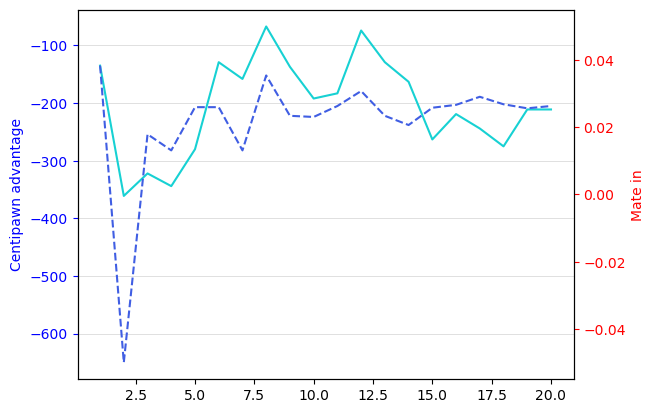

In [145]:
import subprocess

# Function to extract the evaluation scores and best moves from Stockfish output
def extract_info(output):
    info_lines = re.findall(r"info depth (\d+) seldepth \d+ multipv (\d+) score cp (-?\d+)(?: .+)? pv (.+)", output)

    scores = {}
    best_moves = {}
    evs = {}
    for depth, multipv, score, pv in info_lines:
        d = int(depth)
        m = int(multipv)
        if m == 1:
            scores[d] = int(score)
            best_moves[d] = pv.split()[0]
            evs[d] = scores[d]
    return best_moves, scores, evs


CRYSTAL_LOCATION = "/home/mathieuacher/SANDBOX/crystalSF/Stockfish/src/crystal"

# analyze fen 
# depth is max depth and actually we get the number (scores) from 1 to depth
def analyze_fen(fen, depth,sf=15):   

    if sf == 15:
        command = STOCKFISH15_LOCATION # f"docker run -i --rm {IMAGE_NAME}:{version}"
    elif sf == "crystal":
        command = CRYSTAL_LOCATION
    else:
        command = STOCKFISH16_LOCATION
    
    input_str = f"position fen {fen}\ngo depth {depth}\nucinewgame\nquit\n"

    try:
        process = subprocess.run(
            command, input=input_str, text=True, capture_output=True, shell=True
        )
        output = process.stdout
        # print(output)
    except Exception as e:
        print("Error or timeout...", e)
        return 
    
    results = []
    best_moves, scores, evs = extract_info(output)
    for d in range(1, depth + 1):
        result = {
            "type" : "cp",
            "value" : evs[d] if d in evs else None
        }
        results.append(result)
    return results


def analyze_fen_evolution(fen, fen_t, depth_max, sf=15):
    ev1 = analyze_fen(fen, depth_max, sf)
    ev2 = analyze_fen(fen_t, depth_max, sf)
    ev1 = [{"value" : i["value"] * (-1), "type" : i["type"] } for i in ev1] # hack?
    return (ev1, ev2, [i for i in range(1, depth_max + 1)])
    

def analyze_evo(fen_base, fen_transform=None, depth=10, sf=15):
    if fen_transform is None:
        fen_transform = sim_mirror(fen_base)
    print(fen_base, "mirror", fen_transform)
    rs = analyze_fen_evolution(fen_base, fen_transform, depth, sf)
    plotevas(rs[0], rs[1], rs[2], 0)
    show_pos([fen_base, fen_transform], 300)
    
# fen_base = "r2qkb1r/pp2p2p/n4pN1/1Npn3Q/8/8/PPPP1PPP/R1B1K2R b" # "8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w"
# analyze_evo(fen_base, None, depth=15)

i = 2
analyze_evo(evaluations50000_sim_mirror_d_20_real.sort_values(by="cpdiff_eval", ascending=False, na_position='last').iloc[i]['pos1'],evaluations50000_sim_mirror_d_20_real.sort_values(by="cpdiff_eval", ascending=False, na_position='last').iloc[i]['pos2'], depth=20, sf=15)



In [ ]:
fen_base = "r2qkb1r/pp2p2p/n4pN1/1Npn3Q/8/8/PPPP1PPP/R1B1K2R b" # "8/5pk1/p4npp/1pPN4/1P2p3/1P4PP/5P2/5K2 w"
analyze_evo(fen_base, None, depth=25)


In [150]:
fen_base = "6k1/p1p4p/2p5/5PPP/p5p1/2p2pP1/P1P2P2/5KbN w" # Yosha study https://twitter.com/IglesiasYosha/status/1780599165304877534
analyze_evo(fen_base, None, depth=70, sf="crystal")

6k1/p1p4p/2p5/5PPP/p5p1/2p2pP1/P1P2P2/5KbN w mirror 5kBn/p1p2p2/2P2Pp1/P5P1/5ppp/2P5/P1P4P/6K1 b


KeyboardInterrupt: 

In [ ]:
fen_base = "3B4/1r2p3/r2p1p2/bkp1P1p1/1p1P1PPp/p1P4P/PP1K4/3B4 w" # Crystal use case 1

In [ ]:
plotevas(carlsen10p[0],carlsen10p[1],carlsen10p[2], 0)

In [ ]:
tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')
tests(evaluations50000_sim_mirror_d_15,0,15, ', original dataset, SF15')
tests(evaluations50000_sim_mirror_d_20,0,20, ', original dataset, SF15')
tests(evaluations50000_sim_mirror_d_20_real,0,20, ', original dataset, real positions, SF15')

In [ ]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_10)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])))

In [ ]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10)[0],0,10, ', original dataset, cp evas only, SF15')


In [ ]:
tests(evaluations50000_best_move_d_10,4,10, ', original dataset, SF15')
tests(evaluations50000_best_move_d_20,4,20, ', original dataset, SF15')
tests(evaluations50000_best_move_d_20_v16,4,20, ', original dataset, SF16')

tests(evaluations50000_best_move_d_20_real,4,20, ', original dataset, real positions, SF15')
tests(evaluations50000_best_move_d_10_real,4,10, ', original dataset, real positions, SF15')
tests(evaluations50000_best_move_d_20_v16_real,4,20, ', original dataset, real positions, SF16')

tests(split_mate_cp(evaluations50000_best_move_d_10)[0],4,10, ', original dataset, cp evas only, SF15')

In [ ]:
tests(evaluations50000_sim_axis_d_10,1,10, ', original dataset, SF15')
tests(evaluations50000_sim_axis_d_15,1,15, ', original dataset, SF15')
tests(evaluations50000_sim_axis_d_20,1,20, ', original dataset, SF15')
tests(evaluations50000_sim_axis_d_20_v16,1,20, ', original dataset, SF16')

tests(evaluations50000_sim_axis_d_20_real,1,20, ', original dataset, real positions, SF15')
tests(evaluations50000_sim_axis_d_10_real,1,10, ', original dataset, real positions, SF15')
tests(evaluations50000_sim_axis_d_20_v16_real,1,20, ', original dataset, real positions, SF16')

tests(split_mate_cp(evaluations50000_sim_axis_d_10)[0],1,10, ', original dataset, cp evas only, SF15')


In [ ]:


def heat_diff(dfT, typent, d, add, size1 = 100):

    plt.figure(figsize=(10*size1//100, 6*size1//100))
    sns.heatmap(dfT, cmap='RdYlGn_r', annot=True, fmt=".2f", cbar_kws={'label': 'Valeurs'},annot_kws={"size": 10*size1//100})
    typent = ["sim_mirror", "sim_axis", "sim_diag", "replace", "best_move","SF15 vs SF16","replace_mr_og"][typent]

    label = 'MR violation rate, ' + typent + ', depth=' + str(d) + add

    plt.title(label)
    plt.xlabel('Epsilons')
    plt.ylabel('Deltas')
    plt.plot()
    
    


In [ ]:
################ MIX real vs original
df1 = tests(evaluations50000_sim_axis_d_10,1,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_axis_d_20_real,1,20, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

In [ ]:
################ MIX real vs original
df1 = tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_mirror_d_20_real,0,20, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 0, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

Original dataset, SF=15: effect of depth=15 and depth=20?

In [ ]:
############ Original Dataset
df1 = tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_mirror_d_20,0,20, ', original dataset, SF15')
df12 = df1 - df2
    
heat_diff(df12, 0, 20, 'original dataset, depth=10 vs original dataset, depth=20 | SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
############ Original Dataset

df1 = tests(evaluations50000_sim_axis_d_10,1,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_axis_d_20,1,20, ', original dataset, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset, depth=20 | SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
############ Original Dataset

df1 = tests(evaluations50000_sim_diag_d_10,2,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_diag_d_20,2,20, ', original dataset, SF15')
df12 = df1 - df2
    
heat_diff(df12, 2, 20, 'original dataset, depth=10 vs original dataset, depth=20 | SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
############ Original Dataset

df1 = tests(evaluations50000_best_move_d_10,4,10, ', original dataset, SF15')
df2 = tests(evaluations50000_best_move_d_20,4,20, ', original dataset, SF15')
df12 = df1 - df2
    
heat_diff(df12, 4, 20, 'original dataset, depth=10 vs original dataset, SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

Original dataset with only real positions!

In [ ]:
############ real vs real

df1 = tests(evaluations50000_sim_mirror_d_10_real,0,10, ', original dataset, real positions, SF15')
df2 = tests(evaluations50000_sim_mirror_d_20_real,0,20, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 0, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
############ real vs real

df1 = tests(evaluations50000_sim_axis_d_10_real,1,10, ', original dataset, real positions, SF15')
df2 = tests(evaluations50000_sim_axis_d_20_real,1,20, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
############ real vs real

df1 = tests(evaluations50000_best_move_d_10_real,4,10, ', original dataset, real positions, SF15')
df2 = tests(evaluations50000_best_move_d_20_real,4,20, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
# without Mate
df1 = tests(split_mate_cp(evaluations50000_best_move_d_10)[0],4,10, ', original dataset, SF15')
df2 = tests(split_mate_cp(evaluations50000_best_move_d_20)[0],4,20, ', original dataset, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset, real positions, SF15')

In [ ]:
df1 = tests(split_mate_cp(evaluations50000_sim_axis_d_10)[0],1,10, ', original dataset cp evals, SF15')
df2 = tests(split_mate_cp(evaluations50000_sim_axis_d_20)[0],1,20, ', original dataset cp evals, SF15')
df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=10 vs original dataset cp evals, SF15')

In [ ]:
############ real vs original

df1 = tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')
df2 = tests(evaluations50000_sim_mirror_d_10_real,0,10, ', original dataset, real positions, SF15')
df12 = df1 - df2
    
heat_diff(df12, 0, 10, 'original dataset, depth=10 vs original dataset, real positions, SF15')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
df1 = tests(evaluations50000_sim_mirror_d_10_v16,0,10, ', original dataset, SF16')
df2 = tests(evaluations50000_sim_mirror_d_10,0,10, ', original dataset, SF15')

df12 = df1 - df2
    
heat_diff(df12, 0, 10, 'original dataset, depth=10 SF16')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
df1 = tests(evaluations50000_sim_axis_d_10_v16,1,10, ', original dataset, SF16')
df2 = tests(evaluations50000_sim_axis_d_10,1,10, ', original dataset, SF15')

df12 = df1 - df2
    
heat_diff(df12, 0, 10, 'original dataset, depth=10 SF16')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
df1 = tests(evaluations50000_sim_mirror_d_20_v16,0,20, ', original dataset, SF16')
df2 = tests(evaluations50000_sim_mirror_d_20,0,20, ', original dataset, SF15')

df12 = df1 - df2
    
heat_diff(df12, 0, 20, 'original dataset, depth=20 SF16')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
df1 = tests(evaluations50000_sim_axis_d_20_v16,1,10, ', original dataset, SF16')
df2 = tests(evaluations50000_sim_axis_d_20,1,10, ', original dataset, SF15')

df12 = df1 - df2
    
heat_diff(df12, 1, 20, 'original dataset, depth=20 SF16')

df12.values.flatten().mean(), df12.values.flatten().std()

In [ ]:
df1 = tests(evaluations50000_sim_mirror_d_10_v16_real,0,10, ', original dataset, real, SF16')
df2 = tests(evaluations50000_sim_mirror_d_10_real,0,10, ', original dataset, real, SF15')

df12 = df1 - df2
    
heat_diff(df12, 0, 10, 'original dataset, depth=10 SF16')

df12.values.flatten().mean(), df12.values.flatten().std()